# Data Fusion1 Contest 2024 - Задача 2 «Отток»
https://ods.ai/competitions/data-fusion2024-churn

Данные:
1. Табличные клиентские данные:
Участникам доступны несколько наборов данных и артефактов:   
- Базовая информация про все 96,000 клиентов в табличном .csv формате: clients.csv (2.5 MB)
- Тренировочные данные по целевой переменной и времени последней транзакции для 64,000 клиентов: train.csv (745 KB)
- Информация об отчетах, в рамках которых клиенты сгруппированы по времени: report_dates.csv (288 KB)
2. Данные клиентских транзакций:  
- Клиентские транзакции для всех 96,000 клиентов (~13М) в табличном  .csv  формате:  transactions.csv.zip (197 MB)

In [ ]:
# !pip install lifelines
# !pip install threadpoolctl==3.1.0

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from tqdm import tqdm, trange

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report

from scipy.stats import skew, mode

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Включаем tqdm для pandas, чтобы можно было запускать progress_apply() вместо простого apply()
tqdm.pandas() 
pd.options.display.max_columns = None
pd.options.display.max_rows = 200

# Загружаем данные

In [3]:
# Загрузка словарей mcc кодов
# from groups_mcc import type_1_group_mcc_codes_dict, type_2_group_mcc_codes_dict

In [4]:
PATH = ''
DATASETS_PATH = PATH + 'datasets/'

In [6]:
clients_df = pd.read_csv(DATASETS_PATH +  'clients.csv')
src_train_df = pd.read_csv(DATASETS_PATH +  'train.csv')
report_dates_df = pd.read_csv(DATASETS_PATH + 'report_dates.csv')
transactions_df = pd.read_csv(DATASETS_PATH + 'transactions.csv')
currency_df = pd.read_csv(DATASETS_PATH + 'currency_rk.csv')

clients_df.shape, src_train_df.shape, report_dates_df.shape, transactions_df.shape, currency_df.shape

((96000, 5), (64000, 3), (12, 2), (13075023, 5), (3, 2))

In [69]:
transactions_df['transaction_dttm'] = pd.to_datetime(transactions_df['transaction_dttm'])

user_time_acitve = transactions_df.groupby('user_id').agg(
            first_date = ('transaction_dttm', 'first'),
            last_date = ('transaction_dttm', 'last'),
        )
user_reports_df = clients_df.merge(report_dates_df, on='report', how='left').merge(
        user_time_acitve, on='user_id'
).merge(src_train_df, on='user_id', how='left')

user_reports_df['last_date'] = pd.to_datetime(user_reports_df['last_date'])
user_reports_df['first_date'] = pd.to_datetime(user_reports_df['first_date'])
user_reports_df['report_dt'] = pd.to_datetime(user_reports_df['report_dt'])

user_reports_df['duration_last_first'] = (user_reports_df['last_date'] - user_reports_df['first_date']).dt.days + 1
user_reports_df['duration_report_last'] = (user_reports_df['report_dt'] - user_reports_df['last_date']).dt.days + 1
user_reports_df['duration_report_first'] = (user_reports_df['report_dt'] - user_reports_df['first_date']).dt.days + 1

user_reports_df.shape

(96000, 13)

In [52]:
src_transactions_df = transactions_df.merge(user_reports_df, on='user_id')
# report_dt
src_transactions_df['report_dt'] = pd.to_datetime(src_transactions_df['report_dt'])
src_transactions_df['transaction_dttm'] = pd.to_datetime(src_transactions_df['transaction_dttm'])


In [62]:
# src_transactions_df[(src_transactions_df['report_dt'] - src_transactions_df['transaction_dttm']).dt.days < 200]['user_id'].unique().shape
src_transactions_df[(src_transactions_df['report_dt'] - src_transactions_df['transaction_dttm']).dt.days < 200].shape, src_transactions_df.shape


((7058670, 17), (13075023, 17))

In [1]:
# tmp_df = transactions_df[transactions_df['user_id'] == 3].copy()
# tmp_df['pre_transaction_dttm'] = tmp_df['transaction_dttm'].shift(1)
# tmp_df['pre_transaction_dttm'] = pd.to_datetime(tmp_df['pre_transaction_dttm'])
# tmp_df['transaction_dttm'] = pd.to_datetime(tmp_df['transaction_dttm'])

# tmp_df['no_active_period'] = (tmp_df['transaction_dttm'] - tmp_df['pre_transaction_dttm']).dt.days


# tmp_df

In [205]:
def no_active_period(sub_df):
    sub_df = sub_df.sort_values(by=['user_id', 'transaction_dttm'], ascending=True)
    sub_df['pre_transaction_dttm'] = sub_df['transaction_dttm'].shift(1)
    sub_df['no_active_period'] = (sub_df['transaction_dttm'] - sub_df['pre_transaction_dttm']).dt.days
    unique_active_days = len(sub_df['transaction_dttm'].dt.date.unique())
    active_period = len(sub_df[sub_df['no_active_period'] <= 1])
    all_period = (sub_df['transaction_dttm'].max() - sub_df['transaction_dttm'].min()).days + 1
    
    count_account_hit = len(sub_df[sub_df['transaction_amt'] > 0])
    count_account_charge = len(sub_df[sub_df['transaction_amt'] < 0])
    
    
    last_account_hit = sub_df[sub_df['transaction_amt'] > 0]['transaction_dttm'].max()
    last_account_charge = sub_df[sub_df['transaction_amt'] < 0]['transaction_dttm'].max()

    first_account_hit = sub_df[sub_df['transaction_amt'] > 0]['transaction_dttm'].min()
    first_account_charge = sub_df[sub_df['transaction_amt'] < 0]['transaction_dttm'].min()

    return last_account_hit, last_account_charge, first_account_hit, first_account_charge, \
            active_period, unique_active_days, all_period, sub_df['no_active_period'].median(), \
            sub_df['no_active_period'].max(), active_period/len(sub_df), active_period/all_period,\
            unique_active_days/len(sub_df), unique_active_days/all_period, \
            count_account_hit, count_account_charge

no_active_period_df = transactions_df.groupby(by='user_id').progress_apply(lambda x: pd.Series(no_active_period(x)))
no_active_period_df.columns = ['last_account_hit', 'last_account_charge', 'first_account_hit', 
                               'first_account_charge', 'active_period', 'unique_active_days', 
                               'all_period', 'median_no_active_period', 'max_no_active_period', 
                               'prc_no_active_period', 'prc_no_active_period_by_days', 
                               'freq_active_transact_count', 'freq_active_day', 'count_account_hit', 'count_account_charge']
no_active_period_df.shape


100%|██████████| 96000/96000 [04:52<00:00, 327.86it/s]


(96000, 15)

In [191]:
# no_active_period_df['first_account_charge'].isna().sum()
no_active_period_df[no_active_period_df['first_account_charge'].isna()].index

Int64Index([   326,    594,   1548,   2681,   3319,   3855,   4095,   5159,
              6870,   7301,
            ...
            525063, 526703, 529329, 529437, 530388, 538291, 542511, 545028,
            552830, 552888],
           dtype='int64', name='user_id', length=440)

In [232]:
# save_no_active_period_df = no_active_period_df.copy()

In [237]:
tmp_df = no_active_period_df.reset_index().merge(src_train_df, on='user_id')
tmp_df.corr()['target'].sort_values()

C:\Users\Profit77\AppData\Local\Temp\ipykernel_29060\395814182.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  tmp_df.corr()['target'].sort_values()


time                           -0.481098
all_period                     -0.100865
unique_active_days             -0.060267
freq_active_day                -0.042769
count_account_charge           -0.041247
active_period                  -0.032160
freq_active_transact_count     -0.024057
prc_no_active_period_by_days   -0.020069
median_no_active_period        -0.015035
prc_no_active_period            0.011625
count_account_hit               0.048230
max_no_active_period            0.072919
user_id                         0.152825
target                          1.000000
Name: target, dtype: float64

In [241]:
no_active_period_df.to_csv('ivan_publ8.csv')

In [285]:
# src_transactions_df
# user_id
# transactions_df[transactions_df['user_id'] == 3].shape

In [229]:
# src_train_df[src_train_df['user_id'].isin(no_active_period_df[no_active_period_df['first_account_hit'].isna()].index)]['target'].value_counts()
# src_train_df['target'].value_counts()
# src_train_df[src_train_df['user_id'].isin(no_active_period_df[no_active_period_df['first_account_hit'].isna()].index)]['target'].value_counts()
# no_active_period_df[no_active_period_df['first_account_hit'].isna()
# no_active_period_df[no_active_period_df['last_account_hit'] < no_active_period_df['first_account_hit']]

# src_train_df[src_train_df['user_id'].isin(no_active_period_df[no_active_period_df['count_account_charge'] < 1].index)]['target'].value_counts()
# no_active_period_df

In [227]:
# 5417/58583, 18/278, 1544/16111, 1277/13132, 46/121

In [166]:
(transactions_df[transactions_df['user_id'] == 37]['transaction_dttm'].max() - transactions_df[transactions_df['user_id'] == 37]['transaction_dttm'].min()).days
# transactions_df[transactions_df['user_id'] == 37]['transaction_dttm'].dt.date.unique().shape

179

In [174]:
# transactions_df[transactions_df['user_id'] == 37]['transaction_amt']
transactions_df[transactions_df['transaction_amt'] > 0]['user_id'].unique().shape

(69467,)

In [ ]:
# no_active_period_df

In [181]:
# last_account_hit transactions_df[transactions_df['transaction_amt'] < 0]['transaction_dttm'].max()

Timestamp('2023-03-20 20:56:29')

In [179]:
# no_active_period_df['all_period'].max()

183.0

In [210]:
# no_active_period_df['count_account_hit']


In [157]:
# (transactions_df[transactions_df['user_id'] == 37]['transaction_dttm'].max() - transactions_df[transactions_df['user_id'] == 37]['transaction_dttm'].min()).days
# sub_df['transaction_dttm'] - sub_df['pre_transaction_dttm']).dt.days
#     sub_df['transaction_dttm'] - sub_df['pre_transaction_dttm']).dt.days
no_active_period_df

,median_no_active_period,max_no_active_period,prc_no_active_period,prc_no_active_period_by_days
user_id,,,,
3,7.0,30.0,0.272727,0.028037
9,0.0,21.0,0.711111,0.351648
13,8.0,21.0,0.272727,0.035503
37,0.0,6.0,0.946032,1.655556
41,2.0,31.0,0.375000,0.038961
...,...,...,...,...
562043,0.0,53.0,0.702703,0.209677
562205,0.0,8.0,0.794702,0.670391
562312,1.0,37.0,0.732143,0.259494


In [149]:
no_active_period_df
# transactions_df[transactions_df['user_id'] == 562043]

,median_no_active_period,max_no_active_period,prc_no_active_period
user_id,,,
3,7.0,30.0,0.272727
9,0.0,21.0,0.711111
13,8.0,21.0,0.272727
37,0.0,6.0,0.946032
41,2.0,31.0,0.375000
...,...,...,...
562043,0.0,53.0,0.702703
562205,0.0,8.0,0.794702
562312,1.0,37.0,0.732143


In [91]:
# transactions_df.sort_values(by=['user_id', 'transaction_dttm'], ascending=False)

In [104]:
tmp_df = transactions_df[transactions_df['user_id'] == 3].copy()
tmp_df['pre_transaction_dttm'] = tmp_df['transaction_dttm'].shift(1)
tmp_df['pre_transaction_dttm'] = pd.to_datetime(tmp_df['pre_transaction_dttm'])
tmp_df['transaction_dttm'] = pd.to_datetime(tmp_df['transaction_dttm'])

tmp_df['no_active_period'] = (tmp_df['transaction_dttm'] - tmp_df['pre_transaction_dttm']).dt.days


tmp_df

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,pre_transaction_dttm,no_active_period
0,3,3,1,-183.883957,2022-01-28 12:05:33,NaT,NaN
1,3,3,1,-3206.437012,2022-01-28 12:52:30,2022-01-28 12:05:33,0.0
2,3,16,1,-153866.890625,2022-02-16 14:45:56,2022-01-28 12:52:30,19.0
3,3,56,1,-15144.601562,2022-03-09 19:58:29,2022-02-16 14:45:56,21.0
4,3,0,1,5297.908691,2022-03-12 18:11:31,2022-03-09 19:58:29,2.0
5,3,0,1,534.363098,2022-04-11 20:48:26,2022-03-12 18:11:31,30.0
6,3,0,1,4549.455078,2022-04-11 20:53:35,2022-04-11 20:48:26,0.0
7,3,0,1,37991.929688,2022-04-29 18:42:58,2022-04-11 20:53:35,17.0
8,3,0,1,28335.613281,2022-05-05 20:32:38,2022-04-29 18:42:58,6.0
9,3,0,1,5386.999023,2022-05-14 20:14:31,2022-05-05 20:32:38,8.0


In [109]:
tmp_df['no_active_period'].median(), tmp_df['no_active_period'].max(), len(tmp_df[tmp_df['no_active_period'] <= 1])/len(tmp_df)

(7.0, 30.0, 0.2727272727272727)

In [247]:
# transactions_df['transaction_dttm']
# bins_dt = pd.date_range('2000-01-01', freq='3D', periods=6)

In [248]:
# transactions_df[transactions_df['user_id'] == 3]['transaction_dttm']
# # df['bin'] = pd.cut(df.Processed_date, Filedate_bin_list)
# tmp_df_2 = transactions_df[transactions_df['user_id'] == 3]['transaction_dttm']
# pd.cut(tmp_df_2.transaction_dttm, Filedate_bin_list)

In [275]:
from datetime import timedelta
# no_active_period_df#.to_csv('ivan_publ8.csv')
tmp_df_3 = transactions_df[transactions_df['user_id'] == 3]

min_datetime = transactions_df[transactions_df['user_id'] == 3]['transaction_dttm'].min().date() - timedelta(days=1)
max_datetime = transactions_df[transactions_df['user_id'] == 3]['transaction_dttm'].max().date() + timedelta(days=1)



periods = (max_datetime - min_datetime)// timedelta(days=30) + 2
periods

5

In [276]:
min_datetime, max_datetime

(datetime.date(2022, 1, 27), datetime.date(2022, 5, 15))

In [277]:
tmp_df_3['transaction_dttm']

0    2022-01-28 12:05:33
1    2022-01-28 12:52:30
2    2022-02-16 14:45:56
3    2022-03-09 19:58:29
4    2022-03-12 18:11:31
5    2022-04-11 20:48:26
6    2022-04-11 20:53:35
7    2022-04-29 18:42:58
8    2022-05-05 20:32:38
9    2022-05-14 20:14:31
10   2022-05-14 20:39:45
Name: transaction_dttm, dtype: datetime64[ns]

In [279]:
# tmp_df_3 = transactions_df[transactions_df['user_id'] == 3]


# bins_dt = pd.date_range('2000-01-01', freq='3D', periods=6)
bins_dt = pd.date_range(min_datetime, freq='30D', periods=periods+1)
# bins_dt
tmp_df_3['date_cut'] = pd.cut(tmp_df_3['transaction_dttm'], bins=bins_dt)
# bins_dt

C:\Users\Profit77\AppData\Local\Temp\ipykernel_29060\1656961093.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df_3['date_cut'] = pd.cut(tmp_df_3['transaction_dttm'], bins=bins_dt)


In [281]:
# tmp_df_3.group_by()

user_id  mcc_code  currency_rk  transaction_amt  transaction_dttm     date_cut                
3        0         1             534.363098      2022-04-11 20:48:26  (2022-03-28, 2022-04-27]    1
                                 4549.455078     2022-04-11 20:53:35  (2022-03-28, 2022-04-27]    1
                                 5297.908691     2022-03-12 18:11:31  (2022-02-26, 2022-03-28]    1
                                 5386.999023     2022-05-14 20:14:31  (2022-04-27, 2022-05-27]    1
                                 28335.613281    2022-05-05 20:32:38  (2022-04-27, 2022-05-27]    1
                                 37991.929688    2022-04-29 18:42:58  (2022-04-27, 2022-05-27]    1
                                 104011.960938   2022-05-14 20:39:45  (2022-04-27, 2022-05-27]    1
         3         1            -3206.437012     2022-01-28 12:52:30  (2022-01-27, 2022-02-26]    1
                                -183.883957      2022-01-28 12:05:33  (2022-01-27, 2022-02-26]    1
     

In [83]:
# user_reports_df

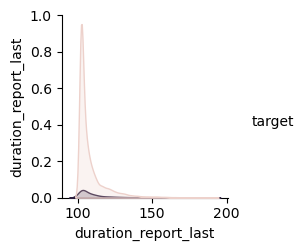

In [81]:
# user_reports_df.sort_values('duration_report_last')['duration_report_last'].hist()
# user_reports_df[['duration_report_last','target']].hist()
import seaborn as sns
sns.pairplot(user_reports_df,vars=['duration_report_last'], hue='target')

In [ ]:


last_date
user_time_acitve['last_date'] = pd.to_datetime(user_time_acitve['last_date'])
user_time_acitve['first_date'] = pd.to_datetime(user_time_acitve['first_date'])


<Axes: >

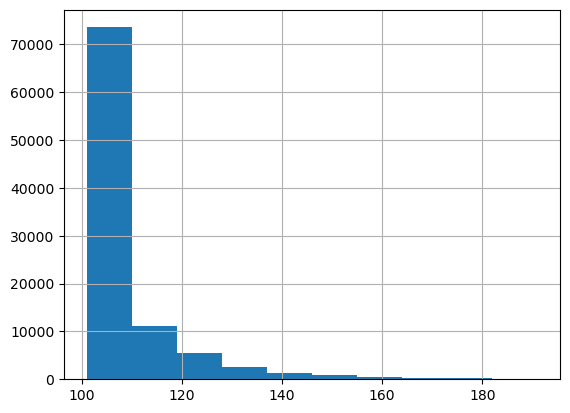

In [67]:
user_reports_df.sort_values('duration_report_last')['duration_report_last'].hist()

<Axes: >

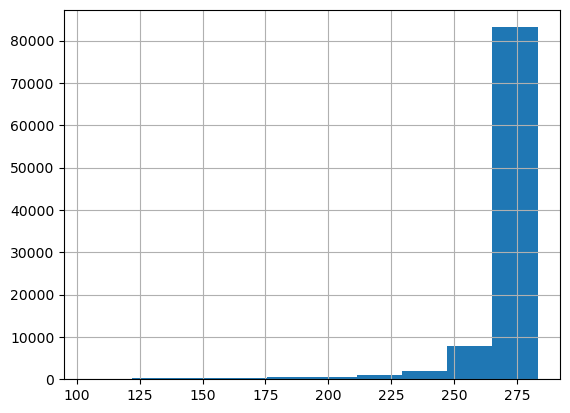

In [47]:
user_reports_df.sort_values('duration_report_first')['duration_report_first'].hist()

In [32]:

# 320 in src_train_df['user_id'].unique()
# 320 in transactions_df['user_id'].unique()
# clients_df.shape

In [ ]:
# Загружаем курсы
# Курсы валют за каждый день доступны по ссылке: https://www.cbr.ru/currency_base/dynamics/
# График инфляции и ключ.ставки за каждый месяц доступны по ссылке: https://www.cbr.ru/hd_base/infl/
# Тип используемой валюты
# 1 — рубль
# 2,3 — евро и доллар 
# 0 — все остальное
# Возьмем за 0 белорусский рубль, потому что: 
#   1. он является 3ей самой популярной валютой в Россиии после доллара и евро (https://www.rbc.ru/finances/15/11/2019/5dce1f329a794794883bd4fa)
#   2. курс бел.рубля ~30 руб, что попадает в диапозон 20-40 рублей за большинство других валют
dollar_curs_df = pd.read_excel(DATASETS_PATH + 'outside_dataset/dollar_RC_F01_01_2021_T06_03_2024.xlsx')
euro_curs_df = pd.read_excel(DATASETS_PATH + 'outside_dataset/euro_RC_F01_01_2021_T06_03_2024.xlsx')
belarus_curs_df = pd.read_excel(DATASETS_PATH + 'outside_dataset/belarus_RC_F01_01_2021_T06_03_2024.xlsx')
# Загружаем инфляцию
# Например с января 2021 года по января 2024 года рубль инфляция съела 0,3 рубля
inflation_df = pd.read_excel(DATASETS_PATH + 'outside_dataset/inflation.xlsx').rename(columns={'Месяц': 'month', 'Год': 'year'})

In [ ]:
# inflation_df

## Предварительная обработка

In [ ]:
# employee_count_nm - кодируем по возрастанию, т.к. природа фичи подразумевает ранговое представление 
clients_df['employee_count_nm'] = clients_df['employee_count_nm'].fillna('НЕТ')
clients_df['employee_count_nm_code'] = clients_df['employee_count_nm'].replace({
    'НЕТ': 0,
    'ДО 10': 1, 
    'ОТ 11 ДО 30': 2,
    'ОТ 11 ДО 50': 3,
    'ОТ 31 ДО 50': 4,
    'ОТ 51 ДО 100': 5,
    'ОТ 101 ДО 500': 6, 
    'БОЛЕЕ 500': 7,
    'ОТ 501 ДО 1000': 8, 
    'БОЛЕЕ 1001': 9, 
}).fillna(0)

clients_df = clients_df.merge(report_dates_df, on='report', how='left')
clients_df.shape
# clients_df['employee_count_nm'].value_counts(dropna=False)

In [ ]:
# Обрабатываем даты
dates = pd.to_datetime(transactions_df['transaction_dttm']).dt

In [ ]:
# Формируем фичи из даты и времени
transactions_df['date'] = dates.date
transactions_df['weekday'] = dates.weekday
transactions_df['year'] = dates.year
transactions_df['month'] = dates.month
transactions_df['hour'] = dates.hour
# Выходные
transactions_df['is_holiday'] = np.where(transactions_df['weekday'].isin([5, 6]), 1, 0)
# Определяем период начала или конца года
transactions_df['end_of_year'] = np.where(transactions_df['month'].isin([11,12]), 1, 0)
transactions_df['begin_of_year'] = np.where(transactions_df['month'].isin([1,2]), 1, 0)
# Время года
transactions_df['season_of_year'] = np.where(
                    transactions_df['month'].isin([12, 1, 2]), 'winter', 
                    np.where(transactions_df['month'].between(3,5), 'spring',
                        np.where(transactions_df['month'].between(6,8), 'summer', 'fall')
                            )
                    )
# Время дня
transactions_df['time_of_day'] = np.where(
                    transactions_df['hour'].between(0, 4), 'night', 
                    np.where(transactions_df['hour'].between(5, 9), 'morning',
                        np.where(transactions_df['hour'].between(10,18), 'day', 'evening')
                            )
                    )
transactions_df.shape

In [ ]:
# transactions_df[transactions_df['month'] == 12][:1]['season_of_year']

In [ ]:
# pd.to_datetime(transactions_df['transaction_dttm'][:10]).dt.weekday
# transactions_df['transaction_date']
# date_format.weekday

### Группировка кодов mcc

In [ ]:
# import pickle
# with open(DATASETS_PATH + 'outside_dataset/mcc_code_group_1.pkl', 'rb') as file:
#     type_1_group_mcc_codes_dict = pickle.load(file)

# with open(DATASETS_PATH + 'outside_dataset/mcc_code_group_2.pkl', 'rb') as file:
#     type_2_group_mcc_codes_dict = pickle.load(file)

In [ ]:
# # Перевод в группы по названиям
# mcc_code_to_group_1 = {}
# for group in type_1_group_mcc_codes_dict:
#     for item in type_1_group_mcc_codes_dict[group]:
#         if len(item.split('-')) > 1:
#             item = item.split('-')
#             for item in range(int(item[0]), int(item[1])+1):
#                 if item not in mcc_code_to_group_1:
#                     mcc_code_to_group_1[item] = group
#         else:
#             item = int(item)
#             if item not in mcc_code_to_group_1:
#                 mcc_code_to_group_1[item] = group

In [ ]:
# # Перевод в группы по названиям
# mcc_code_to_group_2 = {}
# for group in type_2_group_mcc_codes_dict:
#     for item in type_2_group_mcc_codes_dict[group]:
#         if item not in mcc_code_to_group_2:
#             mcc_code_to_group_2[item] = group

In [ ]:
# mcc_group_1_df = pd.DataFrame.from_dict(mcc_code_to_group_1, orient='index', columns=['group_1'])
# mcc_group_2_df = pd.DataFrame.from_dict(mcc_code_to_group_2, orient='index', columns=['group_2'])

In [ ]:
# type_1_group_mcc_codes_dict

In [ ]:
# mcc_codes_df

In [ ]:
# mcc_codes_df = pd.read_csv(DATASETS_PATH + 'mcc_codes.csv')
# mcc_codes_df = mcc_codes_df.merge(mcc_group_1_df, left_on='MCC', right_index=True, how='left')
# mcc_codes_df = mcc_codes_df.merge(mcc_group_2_df, left_on='Название', right_index=True, how='left')
# # mcc_codes_df

### Нормализация цен
- инфляция за период с 2021 по 2023  
- курс доллара и евро с 2021 по 2023  
- курс "другой" валюты

Курс доллара и евро с 2021 по 2024 за каждый день доступны по ссылке: https://www.cbr.ru/currency_base/dynamics/  
График инфляции и ключ.ставки за каждый месяц доступны по ссылке: https://www.cbr.ru/hd_base/infl/  


Тип валюты:   
1 — рубль    
2,3 — евро и доллар     
0 — все остальное  

In [ ]:
# transactions_df['normal_transaction_amt'] = np.where(
#             transactions_df['currency_rk'].isin([2,3]), transactions_df['transaction_amt'] * 95,
#          (np.where(transactions_df['currency_rk'] == 0, transactions_df['transaction_amt']*30, transactions_df['transaction_amt']))
# )

dollar_curs_dict = {d.strftime('%Y-%m-%d') : c for d, c in dollar_curs_df[['data', 'curs']].to_dict('split')['data']}
eu1o_curs_dict = {d.strftime('%Y-%m-%d') : c for d, c in euro_curs_df[['data', 'curs']].to_dict('split')['data']}
belarus_curs_dict = {d.strftime('%Y-%m-%d') : c for d, c in belarus_curs_df[['data', 'curs']].to_dict('split')['data']}

# inflation_df = pd.read_excel(DATASETS_PATH + 'outside_dataset/inflation.xlsx')
# for d, c in belarus_curs_df[['data', 'curs']].to_dict('split')['data']
inflation_dict = {}
for y, m, c in inflation_df[['year', 'month', 'cumulative_inflation']].to_dict('split')['data']:
    if y not in inflation_dict:
        inflation_dict[y] = {}
    inflation_dict[y][m] = c

In [ ]:
dollar_curs_df['year'] = dollar_curs_df['data'].dt.year
dollar_curs_df['month'] = dollar_curs_df['data'].dt.month

euro_curs_df['year'] = euro_curs_df['data'].dt.year
euro_curs_df['month'] = euro_curs_df['data'].dt.month

belarus_curs_df['year'] = belarus_curs_df['data'].dt.year
belarus_curs_df['month'] = belarus_curs_df['data'].dt.month

def create_money_dict(df:pd.DataFrame):
    money_dict = {}
    for y, m, c in df.reset_index()[['year', 'month', 'curs']].to_dict('split')['data']:
        if y not in money_dict:
            money_dict[y] = {}
        money_dict[y][m] = c
    return money_dict

dollar_curs_dict = create_money_dict(dollar_curs_df.groupby(by=['year', 'month'])['curs'].mean())
euro_curs_dict = create_money_dict(euro_curs_df.groupby(by=['year', 'month'])['curs'].mean())
belarus_curs_dict = create_money_dict(belarus_curs_df.groupby(by=['year', 'month'])['curs'].mean())
inflation_dict = create_money_dict(inflation_df[['year', 'month', 'cumulative_inflation']].rename(columns={'cumulative_inflation': 'curs'}))



In [ ]:
# Нормализация цен
def amt_normalize(x):
    normal_amt = x.transaction_amt
    # Приводим валюту к рублям
    if x.currency_rk == 2:
        normal_amt = normal_amt * euro_curs_dict[x.year][x.month]
    elif x.currency_rk == 3:
        normal_amt = normal_amt * dollar_curs_dict[x.year][x.month]
    elif x.currency_rk == 0:
        normal_amt = normal_amt * belarus_curs_dict[x.year][x.month]
    # Нормируем к инфляции рублевой
    normal_amt = normal_amt * inflation_dict[x.year][x.month]
    return normal_amt

transactions_df['normal_transaction_amt'] = transactions_df.progress_apply(lambda x: amt_normalize(x), axis=1)

In [ ]:
transactions_df['plus_normal_transaction_amt'] = np.where(transactions_df['normal_transaction_amt'] > 0, transactions_df['normal_transaction_amt'], 0) 
transactions_df['minus_normal_transaction_amt'] = np.where(transactions_df['normal_transaction_amt'] < 0, transactions_df['normal_transaction_amt'], 0) 

In [ ]:
save_transactions_df = transactions_df.copy()
save_transactions_df.shape, transactions_df.shape

In [ ]:
# 1+1

## Фичи

### Фичи по пользователю

In [ ]:
# mcc_group_transactions_df = transactions_df.merge(mcc_codes_df[['group_1', 'group_2']], left_on='mcc_code', right_index=True) 
# mcc_group_transactions_df = transactions_df.merge(mcc_codes_df[['group_2']], left_on='mcc_code', right_index=True) 
# mcc_group_transactions_df.shape

In [ ]:
#agg__mcc_group_transactions_df = mcc_group_transactions_df.copy()
agg__mcc_group_transactions_df = transactions_df.copy()

In [ ]:
agg__mcc_group_transactions_df = agg__mcc_group_transactions_df.merge(clients_df, on='user_id')
agg__mcc_group_transactions_df['report_dt'] = pd.to_datetime(agg__mcc_group_transactions_df['report_dt'])
agg__mcc_group_transactions_df['transaction_dttm'] = pd.to_datetime(agg__mcc_group_transactions_df['transaction_dttm'])
agg__mcc_group_transactions_df.shape

In [ ]:
# from datetime import timedelta
# agg__mcc_group_transactions_df = agg__mcc_group_transactions_df[
#     (agg__mcc_group_transactions_df['transaction_dttm'] > (agg__mcc_group_transactions_df['report_dt'] - timedelta(days=200)))
    
# ]
# agg__mcc_group_transactions_df.shape

In [ ]:
# agg__mcc_group_transactions_df['user_id'].unique().shape

In [ ]:
# mcc_group_transactions_df

In [ ]:
%%time
# https://github.com/pandas-dev/pandas/issues/39983
# transactions_df[transactions_df['mcc_code'].isin(pop_mcc)].groupby(by=['user_id', 'mcc_code']).agg(
# tmp_df = transactions_df.groupby(by=['user_id']).agg(
# tmp_df = mcc_group_transactions_df.groupby(by=['user_id']).agg(
tmp_df = agg__mcc_group_transactions_df.groupby(by=['user_id']).agg(
        amt_count = ('transaction_amt', len),
        amt_sum = ('transaction_amt', sum),
        amt_std = ('transaction_amt', np.std),
        amt_median = ('transaction_amt', np.median),
        amt_min = ('transaction_amt', min),
        amt_max = ('transaction_amt', max),
    
        amt_var = ('transaction_amt', 'var'),
        amt_mad = ('transaction_amt', 'mad'),
        amt_skew = ('transaction_amt', skew),
    
#         amt_normal_sum = ('normal_transaction_amt', sum),
#         amt_normal_std = ('normal_transaction_amt', np.std),
#         amt_normal_median = ('normal_transaction_amt', np.median),
#         amt_normal_min = ('normal_transaction_amt', min),
#         amt_normal_max = ('normal_transaction_amt', max),

        amt_normal_count = ('normal_transaction_amt', len),
        amt_normal_sum = ('normal_transaction_amt', sum),
        amt_normal_std = ('normal_transaction_amt', np.std),
        amt_normal_median = ('normal_transaction_amt', np.median),
        amt_normal_min = ('normal_transaction_amt', min),
        amt_normal_max = ('normal_transaction_amt', max),
        amt_normal_var = ('normal_transaction_amt', 'var'),
        amt_normal_mad = ('normal_transaction_amt', 'mad'),
        amt_normal_skew = ('normal_transaction_amt', skew),            

    
        plus_amt_normal_count = ('plus_normal_transaction_amt', len),
        plus_amt_normal_sum = ('plus_normal_transaction_amt', sum),
        plus_amt_normal_std = ('plus_normal_transaction_amt', np.std),
        plus_amt_normal_median = ('plus_normal_transaction_amt', np.median),
        plus_amt_normal_min = ('plus_normal_transaction_amt', min),
        plus_amt_normal_max = ('plus_normal_transaction_amt', max),
        plus_amt_normal_var = ('plus_normal_transaction_amt', 'var'),
        plus_amt_normal_mad = ('plus_normal_transaction_amt', 'mad'),
        plus_amt_normal_skew = ('plus_normal_transaction_amt', skew),            

    
        minus_amt_normal_count = ('minus_normal_transaction_amt', len),
        minus_amt_normal_sum = ('minus_normal_transaction_amt', sum),
        minus_amt_normal_std = ('minus_normal_transaction_amt', np.std),
        minus_amt_normal_median = ('minus_normal_transaction_amt', np.median),
        minus_amt_normal_min = ('minus_normal_transaction_amt', min),
        minus_amt_normal_max = ('minus_normal_transaction_amt', max),
        minus_amt_normal_var = ('minus_normal_transaction_amt', 'var'),
        minus_amt_normal_mad = ('minus_normal_transaction_amt', 'mad'),
        minus_amt_normal_skew = ('minus_normal_transaction_amt', skew),
    
    
# transactions_df['plus_normal_transaction_amt'] = np.where(transactions_df['normal_transaction_amt'] > 0, transactions_df['normal_transaction_amt'], 0) 
# transactions_df['minus_normal_transaction_amt'] = np.where(transactions_df['normal_transaction_amt'] < 0, transactions_df['normal_transaction_amt'], 0)     
    
        uniq_mcc = ('mcc_code', pd.Series.nunique),
        uniq_currency = ('currency_rk', pd.Series.nunique),
        
        min_date = ('date', min),
        max_date = ('date', max),
    
        # Кол-во уникальных дней недели когда клиент совершал операции, если 7 то значит каждый день, если 1 то только в один день
        count_weekday = ('weekday', pd.Series.nunique),
        # Чаще всего встречаемые 
        mode_weekday = ('weekday', mode), # наиболее часто встречающееся значение 
        skew_weekday = ('weekday', skew), # асимметрия 
        
        mean_is_holiday = ('is_holiday', 'mean'),
        mean_end_of_year = ('end_of_year', 'mean'),
        mean_begin_of_year = ('begin_of_year', 'mean'),
        mean_hour = ('hour', 'mean'),
        
    
        mode_month = ('month', mode), # наиболее часто встречающееся значение 
        mode_season_of_year = ('season_of_year', mode), # наиболее часто встречающееся значение 
        mode_time_of_day = ('time_of_day', mode), # наиболее часто встречающееся значение 
        mode_mcc_code = ('mcc_code', mode), # наиболее часто встречающееся значение 
    
#         mode_mcc_group_1 = ('group_1', mode), # наиболее часто встречающееся значение 
#         mode_mcc_group_2 = ('group_2', mode), # наиболее часто встречающееся значение 
        
    
    
        # weekday	is_holiday	month	season_of_year	end_of_year	begin_of_year	hour	time_of_day	year
#         datetime_id = ('datetime_id', np.median),

#         # sum_sum = ('sum', sum),
#         # mean_sum = ('sum', np.mean),
#         median_sum = ('sum', np.median),

#         # sum_avg = ('avg', sum),
#         # mean_avg = ('avg', np.mean),
#         median_avg = ('avg', np.median),

#         # sum_min = ('min', sum),
#         mean_min = ('min', np.mean), 
#         # median_min = ('min', np.median),

#         # sum_max = ('max', sum),
#         # mean_max = ('max', np.mean),
#         median_max = ('max', np.median),

#         # sum_std = ('std', sum),
#         # mean_std = ('std', np.mean),
#         median_std = ('std', np.median),    
        
#         uniq_terminal_09 = ('h3_09', pd.Series.nunique),
#         uniq_terminal_08 = ('h3_08', pd.Series.nunique),
#         uniq_terminal_07 = ('h3_07', pd.Series.nunique),
#         uniq_terminal_06 = ('h3_06', pd.Series.nunique),
#         uniq_customer = ('customer_id', pd.Series.nunique)
    ).add_suffix('__agg_user')  

In [ ]:
tmp_df['count_most_weekday__agg_user'] = tmp_df['mode_weekday__agg_user'].apply(lambda x: x[1][0])
tmp_df['most_weekday__agg_user'] = tmp_df['mode_weekday__agg_user'].apply(lambda x: x[0][0])

tmp_df['count_most_month__agg_user'] = tmp_df['mode_month__agg_user'].apply(lambda x: x[1][0])
tmp_df['most_month__agg_user'] = tmp_df['mode_month__agg_user'].apply(lambda x: x[0][0])

tmp_df['count_most_season_of_year__agg_user'] = tmp_df['mode_season_of_year__agg_user'].apply(lambda x: x[1][0])
tmp_df['most_season_of_year__agg_user'] = tmp_df['mode_season_of_year__agg_user'].apply(lambda x: x[0][0])

tmp_df['count_most_time_of_day__agg_user'] = tmp_df['mode_time_of_day__agg_user'].apply(lambda x: x[1][0])
tmp_df['most_time_of_day__agg_user'] = tmp_df['mode_time_of_day__agg_user'].apply(lambda x: x[0][0])

# tmp_df['count_most_mode_mcc_group_1__agg_user'] = tmp_df['mode_mcc_group_1__agg_user'].apply(lambda x: x[1][0])
# tmp_df['most_mode_mcc_group_1__agg_user'] = tmp_df['mode_mcc_group_1__agg_user'].apply(lambda x: x[0][0])

# tmp_df['count_most_mode_mcc_group_2__agg_user'] = tmp_df['mode_mcc_group_2__agg_user'].apply(lambda x: x[1][0])
# tmp_df['most_mode_mcc_group_2__agg_user'] = tmp_df['mode_mcc_group_2__agg_user'].apply(lambda x: x[0][0])

tmp_df.shape

In [ ]:
# save_tmp_df = tmp_df.copy()
# tmp_df = save_tmp_df.copy()
# save_tmp_df.shape, tmp_df.shape

In [ ]:
# agg__mcc_group_transactions_df

### Работает с транзакциями как с двумя сущностями:
    1. Пополнение средств
    2. Трата/оплата услуг и товаров

### Кластеризация пользователей по типу транзакций по коду mcc

In [ ]:
# transactions_df[transactions_df['transaction_amt'] == 0]

In [ ]:
income_transactions_df = transactions_df[transactions_df['normal_transaction_amt'] > 0]
expense_transactions_df = transactions_df[transactions_df['normal_transaction_amt'] <= 0]

income_transactions_df.shape, expense_transactions_df.shape

In [ ]:
# transactions_df[transactions_df['transaction_amt'] > 0]['mcc_code'].value_counts()

In [ ]:
# transactions_df[transactions_df['transaction_amt'] < 0]['mcc_code'].value_counts()[:100]

In [ ]:
# # Формируем вектора клиентов по видам операций (только пополнение)
# user_mcc_transactions_df = pd.pivot_table(income_transactions_df, values='normal_transaction_amt', index=['user_id'],
#                        columns=['mcc_code'], aggfunc="sum").rename_axis(None, axis=1).add_prefix('mcc_code_').fillna(0)
# user_mcc_transactions_df.shape

In [ ]:
# Формируем вектора клиентов по видам операций с указанием сумм по операциям (только снятие)
expense_user_mcc_transactions_df = pd.pivot_table(expense_transactions_df, values='normal_transaction_amt', index=['user_id'],
                       columns=['mcc_code'], aggfunc="sum").rename_axis(None, axis=1).add_prefix('mcc_code_').fillna(0)
expense_user_mcc_transactions_df = np.abs(expense_user_mcc_transactions_df)
expense_user_mcc_transactions_df.shape

In [ ]:
# Формируем вектора клиентов по видам операций с указанием сумм по операциям (только снятие)
income_user_mcc_transactions_df = pd.pivot_table(income_transactions_df, values='normal_transaction_amt', index=['user_id'],
                       columns=['mcc_code'], aggfunc="sum").rename_axis(None, axis=1).add_prefix('mcc_code_').fillna(0)
income_user_mcc_transactions_df = np.abs(income_user_mcc_transactions_df)
income_user_mcc_transactions_df.shape

In [ ]:
expense_user_mcc_transactions_df

In [ ]:
# # Формируем вектора клиентов по видам операций с указанием сумм по операциям
# user_mcc_transactions_df = pd.pivot_table(expense_user_mcc_transactions_df, values='normal_transaction_amt', index=['user_id'],
#                        columns=['mcc_code'], aggfunc="sum").rename_axis(None, axis=1).add_prefix('mcc_code_').fillna(0)
# user_mcc_transactions_df.shape

In [ ]:
# # Нормализация векторов mcc
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# user_mcc_transactions_df = expense_user_mcc_transactions_df
# normal_user_mcc_transactions_df = pd.DataFrame(StandardScaler().fit_transform(user_mcc_transactions_df), columns=user_mcc_transactions_df.columns)
# # normal_user_mcc_transactions_df = pd.DataFrame(MinMaxScaler().fit_transform(user_mcc_transactions_df), columns=user_mcc_transactions_df.columns)
# normal_user_mcc_transactions_df.shape

In [ ]:
# def softmax(X, theta = 1.0, axis = None):
#     """
#     Compute the softmax of each element along an axis of X.

#     Parameters
#     ----------
#     X: ND-Array. Probably should be floats. 
#     theta (optional): float parameter, used as a multiplier
#         prior to exponentiation. Default = 1.0
#     axis (optional): axis to compute values along. Default is the 
#         first non-singleton axis.

#     Returns an array the same size as X. The result will sum to 1
#     along the specified axis.
#     """

#     # make X at least 2d
#     y = np.atleast_2d(X)

#     # find axis
#     if axis is None:
#         axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

#     # multiply y against the theta parameter, 
#     y = y * float(theta)

#     # subtract the max for numerical stability
#     y = y - np.expand_dims(np.max(y, axis = axis), axis)

#     # exponentiate y
#     y = np.exp(y)

#     # take the sum along the specified axis
#     ax_sum = np.expand_dims(np.sum(y, axis = axis), axis)

#     # finally: divide elementwise
#     p = y / ax_sum

#     # flatten if X was 1D
#     if len(X.shape) == 1: p = p.flatten()

#     return p
# softmax(tmp_ttt)

In [ ]:
# tmp_ttt = user_mcc_transactions_df[2:3]#.sum(axis=1)
# # tmp_ttt = tmp_ttt + tmp_ttt.min(axis=1).item() * -1
# tmp_ttt

In [ ]:
# x = np.array(tmp_ttt)
# z = x - np.max(x, axis=1)[:, np.newaxis]
# z

In [ ]:
# np.exp(u) / np.sum(np.exp(u), axis=1)
# np.exp(z) / np.sum(np.exp(z), axis=1)[:, np.newaxis]

In [ ]:
# # from scipy.special import softmax
# def soft_max(z):
#     t = np.exp(z)
#     a = np.exp(z) / np.sum(t, axis=1).reshape(-1,1)
#     return a
# m = softmax(tmp_ttt, axis=1)

# m
# #  softmax(tmp_ttt)[0][152:157]

In [ ]:
# # np.argmax(m)
# # np.argmax(tmp_ttt)
# # np.max(tmp_ttt, axis=1)
# m
# expense_user_mcc_transactions_df = expense_user_mcc_transactions_df.drop(columns=['user_group_expense'])

In [ ]:
%%time
# https://www.advancinganalytics.co.uk/blog/2022/6/13/10-incredibly-useful-clustering-algorithms-you-need-to-know
# https://machinelearningmastery.com/clustering-algorithms-with-python/
from matplotlib import pyplot
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

X_cluster = expense_user_mcc_transactions_df
pca = PCA(n_components=7)
X_cluster = pd.DataFrame(pca.fit_transform(X_cluster))

model = GaussianMixture(n_components=4)
yhat = model.fit_predict(X_cluster)
yhat
# X_cluster

In [ ]:
# Определляем группу для каждого пользоватлея
expense_user_mcc_transactions_df['user_group_expense'] = yhat
# Редкую группу переносим в частую
value_clusters = expense_user_mcc_transactions_df['user_group_expense'].value_counts()
min_cluster = value_clusters.sort_values().index[0]
max_cluster = value_clusters.sort_values().index[-1]
if value_clusters[min_cluster] < 100:
    expense_user_mcc_transactions_df.loc[expense_user_mcc_transactions_df['user_group_expense'] == min_cluster, 'user_group_expense'] = max_cluster
# Переводим в текст, чтобы явно придать катгеорию
expense_user_mcc_transactions_df['user_group_expense'] = expense_user_mcc_transactions_df['user_group_expense'].apply(lambda x: f'user_group_expense_{x}')

In [ ]:
# expense_user_mcc_transactions_df = expense_user_mcc_transactions_df.drop(columns=['user_group_expense'])
# income_user_mcc_transactions_df

In [ ]:
%%time
# https://www.advancinganalytics.co.uk/blog/2022/6/13/10-incredibly-useful-clustering-algorithms-you-need-to-know
# https://machinelearningmastery.com/clustering-algorithms-with-python/
from matplotlib import pyplot
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

X_cluster = income_user_mcc_transactions_df
pca = PCA(n_components=3)
X_cluster = pd.DataFrame(pca.fit_transform(X_cluster))

model = GaussianMixture(n_components=2)
yhat = model.fit_predict(X_cluster)
yhat
# X_cluster

In [ ]:
# # Определляем группу для каждого пользоватлея
# income_user_mcc_transactions_df['user_group_expense'] = yhat

# # Редкую группу переносим в частую
# value_clusters = expense_user_mcc_transactions_df['user_group_expense'].value_counts()
# min_cluster = value_clusters.sort_values().index[0]
# max_cluster = value_clusters.sort_values().index[-1]
# if value_clusters[min_cluster] < 100:
#     expense_user_mcc_transactions_df.loc[expense_user_mcc_transactions_df['user_group_expense'] == min_cluster, 'user_group_expense'] = max_cluster
# # Переводим в текст, чтобы явно придать катгеорию
# expense_user_mcc_transactions_df['user_group_expense'] = expense_user_mcc_transactions_df['user_group_expense'].apply(lambda x: f'user_group_expense_{x}')

In [ ]:
# Определляем группу для каждого пользоватлея
income_user_mcc_transactions_df['user_group_income'] = yhat

# Редкую группу переносим в частую
value_clusters = income_user_mcc_transactions_df['user_group_income'].value_counts()
min_cluster = value_clusters.sort_values().index[0]
max_cluster = value_clusters.sort_values().index[-1]
if value_clusters[min_cluster] < 100:
    income_user_mcc_transactions_df.loc[income_user_mcc_transactions_df['user_group_income'] == min_cluster, 'user_group_income'] = max_cluster
# Переводим в текст, чтобы явно придать катгеорию
income_user_mcc_transactions_df['user_group_income'] = income_user_mcc_transactions_df['user_group_income'].apply(lambda x: f'user_group_income_{x}')

In [ ]:
# income_user_mcc_transactions_df = income_user_mcc_transactions_df.drop(columns=['user_group_expense'])

In [ ]:
# yhat
# user_mcc_transactions_df
# # type(yhat)

In [ ]:
# expense_user_mcc_transactions_df


In [ ]:
# income_user_mcc_transactions_df

In [ ]:
%%time
# https://www.advancinganalytics.co.uk/blog/2022/6/13/10-incredibly-useful-clustering-algorithms-you-need-to-know
# https://machinelearningmastery.com/clustering-algorithms-with-python/
from matplotlib import pyplot
from sklearn.decomposition import PCA
# X = user_mcc_transactions_df
# X = normal_user_mcc_transactions_df
# X = expense_user_mcc_transactions_df
# X = income_user_mcc_transactions_df
# X = income_user_mcc_transactions_df.drop(columns='user_group_income', errors='ignore')
X = expense_user_mcc_transactions_df.drop(columns='user_group_expense', errors='ignore')
# X = res_df
pca = PCA(n_components=10)
pca.fit(X)
X = pca.transform(X)
X = pd.DataFrame(X)
print(X.shape)

from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import OPTICS
from sklearn.cluster import SpectralClustering
# from sklearn.cluster import MeanShift
# from sklearn.cluster import MiniBatchKMeans
# from sklearn.cluster import AffinityPropagation
# from sklearn.cluster import KMeans
# from sklearn.cluster import DBSCAN
# define dataset
# define the model
model = GaussianMixture(n_components=6)
# model = AgglomerativeClustering(n_clusters=3)
# model = SpectralClustering(n_clusters=2) # Memmory
# model = MeanShift()
# model = MiniBatchKMeans(n_clusters=6)
# model = OPTICS(eps=0.8, min_samples=5)
# model = SpectralClustering(n_clusters=2)
# model = DBSCAN(eps=0.30, min_samples=9)
# model = AffinityPropagation(damping=0.9)
# model = KMeans(n_clusters=7, random_state=53, n_init="auto")
# fit the model
# model.fit(X)
# assign a cluster to each example
# yhat = model.predict(X)
yhat = model.fit_predict(X)
# retrieve unique clusters
clusters = np.unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
 # get row indexes for samples with this cluster
 row_ix = np.where(yhat == cluster)[0]
 # create scatter of these samples
 pyplot.scatter(X.iloc[row_ix, 0], X.iloc[row_ix, 1])
# show the plot
pyplot.show()

In [ ]:
unique, counts = np.unique(yhat, return_counts=True)

print(np.asarray((unique, counts)).T)

### Фичи по пользователю отсносительно популярных кодов mcc

In [ ]:
# save_transactions_df = transactions_df.copy()
# transactions_df = save_transactions_df.copy()
# save_transactions_df.shape, transactions_df.shape
# agg__mcc_group_transactions_df.mcc_code.value_counts()[:70]

In [ ]:
# Определим топ популярных MCC кодов которые используют пользователи, они войдут как отдельные фичи по которым будет сделана группировка
# pop_mcc = transactions_df.mcc_code.value_counts()[:30].index
# pop_mcc = agg__mcc_group_transactions_df.mcc_code.value_counts()[:70].index
pop_mcc = agg__mcc_group_transactions_df.mcc_code.value_counts()[:50].index
pop_mcc_columns = [f'mcc_code___{c}' for c in pop_mcc]

In [ ]:
# agg__mcc_group_transactions_df = agg__mcc_group_transactions_df.drop(columns=['mcc_code___1_x', 'mcc_code___2_x', 'mcc_code___4_x', 'mcc_code___3_x', 'mcc_code___0_x', 'mcc_code___11_x', 'mcc_code___6_x', 'mcc_code___8_x', 'mcc_code___7_x', 'mcc_code___9_x', 'mcc_code___17_x', 'mcc_code___10_x', 'mcc_code___14_x', 'mcc_code___13_x', 'mcc_code___155_x', 'mcc_code___15_x', 'mcc_code___12_x', 'mcc_code___26_x', 'mcc_code___32_x', 'mcc_code___28_x', 'mcc_code___33_x', 'mcc_code___18_x', 'mcc_code___22_x', 'mcc_code___23_x', 'mcc_code___21_x', 'mcc_code___25_x', 'mcc_code___20_x', 'mcc_code___27_x', 'mcc_code___16_x', 'mcc_code___52_x', 'mcc_code___1_y', 'mcc_code___2_y', 'mcc_code___4_y', 'mcc_code___3_y', 'mcc_code___0_y', 'mcc_code___11_y', 'mcc_code___6_y', 'mcc_code___8_y', 'mcc_code___7_y', 'mcc_code___9_y', 'mcc_code___17_y', 'mcc_code___10_y', 'mcc_code___14_y', 'mcc_code___13_y', 'mcc_code___155_y', 'mcc_code___15_y', 'mcc_code___12_y', 'mcc_code___26_y', 'mcc_code___32_y', 'mcc_code___28_y', 'mcc_code___33_y', 'mcc_code___18_y', 'mcc_code___22_y', 'mcc_code___23_y', 'mcc_code___21_y', 'mcc_code___25_y', 'mcc_code___20_y', 'mcc_code___27_y', 'mcc_code___16_y', 'mcc_code___52_y', ], errors='ignore')
# agg__mcc_group_transactions_df.shape

In [ ]:
# mcc_transactions_df = pd.get_dummies(transactions_df['mcc_code'], prefix='mcc_code__')
mcc_transactions_df = pd.get_dummies(agg__mcc_group_transactions_df['mcc_code'], prefix='mcc_code__')
mcc_transactions_df.shape

In [ ]:
# agg__mcc_group_transactions_df

In [ ]:
# transactions_df = transactions_df.merge(mcc_transactions_df[pop_mcc_columns], left_index=True, right_index=True)
# transactions_df = transactions_df.merge(mcc_transactions_df[pop_mcc_columns], left_index=True, right_index=True)
# transactions_df.shape

# Удаляем если случайно уже были добавлены
agg__mcc_group_transactions_df = agg__mcc_group_transactions_df.drop(columns=[f'{i}_x' for i in pop_mcc_columns], errors='ignore')
agg__mcc_group_transactions_df = agg__mcc_group_transactions_df.drop(columns=[f'{i}_y' for i in pop_mcc_columns], errors='ignore')
agg__mcc_group_transactions_df = agg__mcc_group_transactions_df.drop(columns=[i for i in pop_mcc_columns], errors='ignore')

agg__mcc_group_transactions_df = agg__mcc_group_transactions_df.merge(mcc_transactions_df[pop_mcc_columns], left_index=True, right_index=True)
agg__mcc_group_transactions_df.shape

In [ ]:
# agg__mcc_group_transactions_df

In [ ]:
agg__mcc_group_transactions_df['mcc_code'].value_counts()[:10]

In [ ]:
# Разбиваем mcc_code на 10 групп
cat_mcc_code = pd.qcut(agg__mcc_group_transactions_df['mcc_code'], 10, duplicates='drop')
agg__mcc_group_transactions_df['cat_mcc_code'] = cat_mcc_code
agg__mcc_group_transactions_df['cat_mcc_code'] = agg__mcc_group_transactions_df['cat_mcc_code'].cat.rename_categories([f'cat_mcc_code_{i}' for i in range(len(agg__mcc_group_transactions_df['cat_mcc_code'].unique())) ])

In [ ]:
user_amt_by_mcc_aggregate_df = agg__mcc_group_transactions_df.pivot_table(
                    index='user_id',
                    values=['normal_transaction_amt', 'plus_normal_transaction_amt', 'minus_normal_transaction_amt'],
                    columns=['cat_mcc_code'],
                    aggfunc=['count', 'median', 'sum']
                )
user_amt_by_mcc_aggregate_df.columns = ['___'.join(col).strip() for col in user_amt_by_mcc_aggregate_df.columns.values]
user_amt_by_mcc_aggregate_df.shape

In [ ]:
# # agg__mcc_group_transactions_df
# # pivot
# mcc_info = transactions_df[transactions_df.mcc_code.isin(good_codes)].pivot_table(
#     index = 'user_id',
#     values=['transaction_amt'],
#     columns=['mcc_code'],
#     aggfunc=['count', 'median', 'sum']
# ).fillna(0)

# # # Формируем вектора клиентов по видам операций с указанием сумм по операциям (только снятие)
# # expense_user_mcc_transactions_df = pd.pivot_table(expense_transactions_df, values='normal_transaction_amt', index=['user_id'],
# #                        columns=['mcc_code'], aggfunc="sum").rename_axis(None, axis=1).add_prefix('mcc_code_').fillna(0)

In [ ]:
agg__mcc_group_transactions_df

In [ ]:
%%time
# https://github.com/pandas-dev/pandas/issues/39983
# transactions_df[transactions_df['mcc_code'].isin(pop_mcc)].groupby(by=['user_id', 'mcc_code']).agg(
# tmp_df = transactions_df.groupby(by=['user_id']).agg(
# mcc_tmp_df = transactions_df.groupby(by=['user_id']).agg(
mcc_tmp_df = agg__mcc_group_transactions_df.groupby(by=['user_id']).agg(

sum_mcc_code___1 = ('mcc_code___1', sum),
sum_mcc_code___2 = ('mcc_code___2', sum),
sum_mcc_code___4 = ('mcc_code___4', sum),
sum_mcc_code___3 = ('mcc_code___3', sum),
sum_mcc_code___0 = ('mcc_code___0', sum),
sum_mcc_code___11 = ('mcc_code___11', sum),
sum_mcc_code___6 = ('mcc_code___6', sum),
sum_mcc_code___8 = ('mcc_code___8', sum),
sum_mcc_code___7 = ('mcc_code___7', sum),
sum_mcc_code___9 = ('mcc_code___9', sum),
sum_mcc_code___17 = ('mcc_code___17', sum),
sum_mcc_code___10 = ('mcc_code___10', sum),
sum_mcc_code___14 = ('mcc_code___14', sum),
sum_mcc_code___13 = ('mcc_code___13', sum),
sum_mcc_code___155 = ('mcc_code___155', sum),
sum_mcc_code___15 = ('mcc_code___15', sum),
sum_mcc_code___12 = ('mcc_code___12', sum),
sum_mcc_code___26 = ('mcc_code___26', sum),
sum_mcc_code___32 = ('mcc_code___32', sum),
sum_mcc_code___28 = ('mcc_code___28', sum),
sum_mcc_code___33 = ('mcc_code___33', sum),
sum_mcc_code___18 = ('mcc_code___18', sum),
sum_mcc_code___22 = ('mcc_code___22', sum),
sum_mcc_code___23 = ('mcc_code___23', sum),
sum_mcc_code___21 = ('mcc_code___21', sum),
sum_mcc_code___25 = ('mcc_code___25', sum),
sum_mcc_code___20 = ('mcc_code___20', sum),
sum_mcc_code___27 = ('mcc_code___27', sum),
sum_mcc_code___16 = ('mcc_code___16', sum),
sum_mcc_code___52 = ('mcc_code___52', sum),
sum_mcc_code___24 = ('mcc_code___24', sum),
sum_mcc_code___30 = ('mcc_code___30', sum),
sum_mcc_code___31 = ('mcc_code___31', sum),
sum_mcc_code___44 = ('mcc_code___44', sum),
sum_mcc_code___34 = ('mcc_code___34', sum),
sum_mcc_code___47 = ('mcc_code___47', sum),
sum_mcc_code___61 = ('mcc_code___61', sum),
sum_mcc_code___37 = ('mcc_code___37', sum),
sum_mcc_code___43 = ('mcc_code___43', sum),
sum_mcc_code___50 = ('mcc_code___50', sum),
sum_mcc_code___66 = ('mcc_code___66', sum),
sum_mcc_code___72 = ('mcc_code___72', sum),
sum_mcc_code___45 = ('mcc_code___45', sum),
sum_mcc_code___42 = ('mcc_code___42', sum),
sum_mcc_code___36 = ('mcc_code___36', sum),
sum_mcc_code___39 = ('mcc_code___39', sum),
sum_mcc_code___49 = ('mcc_code___49', sum),
sum_mcc_code___108 = ('mcc_code___108', sum),
sum_mcc_code___51 = ('mcc_code___51', sum),
sum_mcc_code___99 = ('mcc_code___99', sum),
# sum_mcc_code___57 = ('mcc_code___57', sum),
# sum_mcc_code___78 = ('mcc_code___78', sum),
# sum_mcc_code___65 = ('mcc_code___65', sum),
# sum_mcc_code___46 = ('mcc_code___46', sum),
# sum_mcc_code___55 = ('mcc_code___55', sum),
# sum_mcc_code___29 = ('mcc_code___29', sum),
# sum_mcc_code___62 = ('mcc_code___62', sum),
# sum_mcc_code___67 = ('mcc_code___67', sum),
# sum_mcc_code___64 = ('mcc_code___64', sum),
# sum_mcc_code___19 = ('mcc_code___19', sum),
# sum_mcc_code___81 = ('mcc_code___81', sum),
# sum_mcc_code___63 = ('mcc_code___63', sum),
# sum_mcc_code___56 = ('mcc_code___56', sum),
# sum_mcc_code___94 = ('mcc_code___94', sum),
# sum_mcc_code___41 = ('mcc_code___41', sum),
# sum_mcc_code___59 = ('mcc_code___59', sum),
# sum_mcc_code___75 = ('mcc_code___75', sum),
# sum_mcc_code___48 = ('mcc_code___48', sum),
# sum_mcc_code___97 = ('mcc_code___97', sum),
# sum_mcc_code___35 = ('mcc_code___35', sum), 
    
    
    
#         count_mcc_code___0 = ('mcc_code___0', len),
#         sum_mcc_code___0 = ('mcc_code___0', sum),
#         median_mcc_code___0 = ('mcc_code___0', np.median),
#         min_mcc_code___0 = ('mcc_code___0', min),
#         max_mcc_code___0 = ('mcc_code___0', max),
# #         std_mcc_code___0 = ('mcc_code___0', np.std),
# #         var_mcc_code___0 = ('mcc_code___0', 'var'),
# #         mad_mcc_code___0 = ('mcc_code___0', 'mad'),
# #         skew_mcc_code___0 = ('mcc_code___0', skew),

    
#         count_mcc_code___1 = ('mcc_code___1', len),
#         sum_mcc_code___1 = ('mcc_code___1', sum),
#         median_mcc_code___1 = ('mcc_code___1', np.median),
#         min_mcc_code___1 = ('mcc_code___1', min),
#         max_mcc_code___1 = ('mcc_code___1', max),
# #         std_mcc_code___1 = ('mcc_code___1', np.std),
# #         var_mcc_code___1 = ('mcc_code___1', 'var'),
# #         mad_mcc_code___1 = ('mcc_code___1', 'mad'),
# #         skew_mcc_code___1 = ('mcc_code___1', skew),

    
#         count_mcc_code___2 = ('mcc_code___2', len),
#         sum_mcc_code___2 = ('mcc_code___2', sum),
#         median_mcc_code___2 = ('mcc_code___2', np.median),
#         min_mcc_code___2 = ('mcc_code___2', min),
#         max_mcc_code___2 = ('mcc_code___2', max),
# #         std_mcc_code___2 = ('mcc_code___2', np.std),
# #         var_mcc_code___2 = ('mcc_code___2', 'var'),
# #         mad_mcc_code___2 = ('mcc_code___2', 'mad'),
# #         skew_mcc_code___2 = ('mcc_code___2', skew),
    
#         count_mcc_code___3 = ('mcc_code___3', len),
#         sum_mcc_code___3 = ('mcc_code___3', sum),
#         median_mcc_code___3 = ('mcc_code___3', np.median),
#         min_mcc_code___3 = ('mcc_code___3', min),
#         max_mcc_code___3 = ('mcc_code___3', max),
# #         std_mcc_code___3 = ('mcc_code___3', np.std),
# #         var_mcc_code___3 = ('mcc_code___3', 'var'),
# #         mad_mcc_code___3 = ('mcc_code___3', 'mad'),
# #         skew_mcc_code___3 = ('mcc_code___3', skew),
    
#         count_mcc_code___4 = ('mcc_code___4', len),
#         sum_mcc_code___4 = ('mcc_code___4', sum),
#         median_mcc_code___4 = ('mcc_code___4', np.median),
#         min_mcc_code___4 = ('mcc_code___4', min),
#         max_mcc_code___4 = ('mcc_code___4', max),
# #         std_mcc_code___4 = ('mcc_code___4', np.std),
# #         var_mcc_code___4 = ('mcc_code___4', 'var'),
# #         mad_mcc_code___4 = ('mcc_code___4', 'mad'),
# #         skew_mcc_code___4 = ('mcc_code___4', skew),

#         count_mcc_code___11 = ('mcc_code___11', len),
#         sum_mcc_code___11 = ('mcc_code___11', sum),
#         median_mcc_code___11 = ('mcc_code___11', np.median),
#         min_mcc_code___11 = ('mcc_code___11', min),
#         max_mcc_code___11 = ('mcc_code___11', max),
# #         std_mcc_code___11 = ('mcc_code___11', np.std),
# #         var_mcc_code___11 = ('mcc_code___11', 'var'),
# #         mad_mcc_code___11 = ('mcc_code___11', 'mad'),
# #         skew_mcc_code___11 = ('mcc_code___11', skew),

#         count_mcc_code___6 = ('mcc_code___6', len),
#         sum_mcc_code___6 = ('mcc_code___6', sum),
#         median_mcc_code___6 = ('mcc_code___6', np.median),
#         min_mcc_code___6 = ('mcc_code___6', min),
#         max_mcc_code___6 = ('mcc_code___6', max),
# #         std_mcc_code___6 = ('mcc_code___6', np.std),
# #         var_mcc_code___6 = ('mcc_code___6', 'var'),
# #         mad_mcc_code___6 = ('mcc_code___6', 'mad'),
# #         skew_mcc_code___6 = ('mcc_code___6', skew),

#         count_mcc_code___8 = ('mcc_code___8', len),
#         sum_mcc_code___8 = ('mcc_code___8', sum),
#         median_mcc_code___8 = ('mcc_code___8', np.median),
#         min_mcc_code___8 = ('mcc_code___8', min),
#         max_mcc_code___8 = ('mcc_code___8', max),
# #         std_mcc_code___8 = ('mcc_code___8', np.std),
# #         var_mcc_code___8 = ('mcc_code___8', 'var'),
# #         mad_mcc_code___8 = ('mcc_code___8', 'mad'),
# #         skew_mcc_code___8 = ('mcc_code___8', skew),
    
#         count_mcc_code___7 = ('mcc_code___7', len),
#         sum_mcc_code___7 = ('mcc_code___7', sum),
#         median_mcc_code___7 = ('mcc_code___7', np.median),
#         min_mcc_code___7 = ('mcc_code___7', min),
#         max_mcc_code___7 = ('mcc_code___7', max),
# #         std_mcc_code___7 = ('mcc_code___7', np.std),
# #         var_mcc_code___7 = ('mcc_code___7', 'var'),
# #         mad_mcc_code___7 = ('mcc_code___7', 'mad'),
# #         skew_mcc_code___7 = ('mcc_code___7', skew),

#         count_mcc_code___9 = ('mcc_code___9', len),
#         sum_mcc_code___9 = ('mcc_code___9', sum),
#         median_mcc_code___9 = ('mcc_code___9', np.median),
#         min_mcc_code___9 = ('mcc_code___9', min),
#         max_mcc_code___9 = ('mcc_code___9', max),
# #         std_mcc_code___9 = ('mcc_code___9', np.std),
# #         var_mcc_code___9 = ('mcc_code___9', 'var'),
# #         mad_mcc_code___9 = ('mcc_code___9', 'mad'),
# #         skew_mcc_code___9 = ('mcc_code___9', skew),
    
    
    ).add_suffix('__agg_user')  

In [ ]:
# tmp_df

In [ ]:
mcc_tmp_df.columns

In [ ]:
# Softmax

In [ ]:
# %%time
# mcc_columns = mcc_tmp_df.columns
# sft_max__mcc_tmp_df = mcc_tmp_df.copy()

# def softmax(x):
#     """Compute softmax values for each sets of scores in x."""
#     return np.exp(x) / np.sum(np.exp(x), axis=0)

# sft_max__mcc_tmp_df[[f'sft_max_{mcc_code}' for mcc_code in mcc_columns]] = sft_max__mcc_tmp_df[mcc_columns].apply(lambda x: softmax(x), axis=1)

# sft_max__mcc_tmp_df.shape, mcc_tmp_df.shape

In [ ]:
# tmp_df = tmp_df.merge(mcc_tmp_df, left_index=True, right_index=True)
# tmp_df = tmp_df.merge(sft_max__mcc_tmp_df, left_index=True, right_index=True)
# tmp_df.shape

In [ ]:
# tmp_df_2 = tmp_df.drop(columns=['count_mcc_code___0__agg_user', 'sum_mcc_code___0__agg_user_x', 'median_mcc_code___0__agg_user', 'min_mcc_code___0__agg_user', 'max_mcc_code___0__agg_user', 'count_mcc_code___1__agg_user', 'sum_mcc_code___1__agg_user_x', 'median_mcc_code___1__agg_user', 'min_mcc_code___1__agg_user', 'max_mcc_code___1__agg_user', 'count_mcc_code___2__agg_user', 'sum_mcc_code___2__agg_user_x', 'median_mcc_code___2__agg_user', 'min_mcc_code___2__agg_user', 'max_mcc_code___2__agg_user', 'count_mcc_code___3__agg_user', 'sum_mcc_code___3__agg_user_x', 'median_mcc_code___3__agg_user', 'min_mcc_code___3__agg_user', 'max_mcc_code___3__agg_user', 'count_mcc_code___4__agg_user', 'sum_mcc_code___4__agg_user_x', 'median_mcc_code___4__agg_user', 'min_mcc_code___4__agg_user', 'max_mcc_code___4__agg_user', 'count_mcc_code___11__agg_user', 'sum_mcc_code___11__agg_user_x', 'median_mcc_code___11__agg_user', 'min_mcc_code___11__agg_user', 'max_mcc_code___11__agg_user', 'count_mcc_code___6__agg_user', 'sum_mcc_code___6__agg_user_x', 'median_mcc_code___6__agg_user', 'min_mcc_code___6__agg_user', 'max_mcc_code___6__agg_user', 'count_mcc_code___8__agg_user', 'sum_mcc_code___8__agg_user_x', 'median_mcc_code___8__agg_user', 'min_mcc_code___8__agg_user', 'max_mcc_code___8__agg_user', 'count_mcc_code___7__agg_user', 'sum_mcc_code___7__agg_user_x', 'median_mcc_code___7__agg_user', 'min_mcc_code___7__agg_user', 'max_mcc_code___7__agg_user', 'count_mcc_code___9__agg_user', 'sum_mcc_code___9__agg_user_x', 'median_mcc_code___9__agg_user', 'min_mcc_code___9__agg_user', 'max_mcc_code___9__agg_user', 'sum_mcc_code___1__agg_user_y', 'sum_mcc_code___2__agg_user_y', 'sum_mcc_code___4__agg_user_y', 'sum_mcc_code___3__agg_user_y', 'sum_mcc_code___0__agg_user_y', 'sum_mcc_code___11__agg_user_y', 'sum_mcc_code___6__agg_user_y', 'sum_mcc_code___8__agg_user_y', 'sum_mcc_code___7__agg_user_y', 'sum_mcc_code___9__agg_user_y', 'sum_mcc_code___17__agg_user', 'sum_mcc_code___10__agg_user', 'sum_mcc_code___14__agg_user', 'sum_mcc_code___13__agg_user', 'sum_mcc_code___155__agg_user', 'sum_mcc_code___15__agg_user', 'sum_mcc_code___12__agg_user', 'sum_mcc_code___26__agg_user', 'sum_mcc_code___32__agg_user', 'sum_mcc_code___28__agg_user', 'sum_mcc_code___33__agg_user', 'sum_mcc_code___18__agg_user', 'sum_mcc_code___22__agg_user', 'sum_mcc_code___23__agg_user', 'sum_mcc_code___21__agg_user', 'sum_mcc_code___25__agg_user', 'sum_mcc_code___20__agg_user', 'sum_mcc_code___27__agg_user', 'sum_mcc_code___16__agg_user', 'sum_mcc_code___52__agg_user', ], errors='ignore')
# agg_df = agg_df.drop(columns=['count_mcc_code___0__agg_user', 'sum_mcc_code___0__agg_user',
#        'median_mcc_code___0__agg_user', 'min_mcc_code___0__agg_user',
#        'max_mcc_code___0__agg_user', 'count_mcc_code___1__agg_user',
#        'sum_mcc_code___1__agg_user', 'median_mcc_code___1__agg_user',
#        'min_mcc_code___1__agg_user', 'max_mcc_code___1__agg_user',
#        'count_mcc_code___2__agg_user', 'sum_mcc_code___2__agg_user',
#        'median_mcc_code___2__agg_user', 'min_mcc_code___2__agg_user',
#        'max_mcc_code___2__agg_user', 'count_mcc_code___3__agg_user',
#        'sum_mcc_code___3__agg_user', 'median_mcc_code___3__agg_user',
#        'min_mcc_code___3__agg_user', 'max_mcc_code___3__agg_user',
#        'count_mcc_code___4__agg_user', 'sum_mcc_code___4__agg_user',
#        'median_mcc_code___4__agg_user', 'min_mcc_code___4__agg_user',
#        'max_mcc_code___4__agg_user', 'count_mcc_code___11__agg_user',
#        'sum_mcc_code___11__agg_user', 'median_mcc_code___11__agg_user',
#        'min_mcc_code___11__agg_user', 'max_mcc_code___11__agg_user',
#        'count_mcc_code___6__agg_user', 'sum_mcc_code___6__agg_user',
#        'median_mcc_code___6__agg_user', 'min_mcc_code___6__agg_user',
#        'max_mcc_code___6__agg_user', 'count_mcc_code___8__agg_user',
#        'sum_mcc_code___8__agg_user', 'median_mcc_code___8__agg_user',
#        'min_mcc_code___8__agg_user', 'max_mcc_code___8__agg_user',
#        'count_mcc_code___7__agg_user', 'sum_mcc_code___7__agg_user',
#        'median_mcc_code___7__agg_user', 'min_mcc_code___7__agg_user',
#        'max_mcc_code___7__agg_user', 'count_mcc_code___9__agg_user',
#        'sum_mcc_code___9__agg_user', 'median_mcc_code___9__agg_user',
#        'min_mcc_code___9__agg_user', 'max_mcc_code___9__agg_user']
#            )
# agg_df.shape
# tmp_df_2 = tmp_df.copy()
# tmp_df_2 = tmp_df_2.merge(mcc_tmp_df, left_index=True, right_index=True)
# tmp_df_2.shape

In [ ]:
# transactions_df[transactions_df['user_id'] == 13]['weekday'].value_counts()
# transactions_df
# agg_df = tmp_df.copy()
agg_df = tmp_df.copy()

agg_df.shape, tmp_df.shape

In [ ]:
agg_df = agg_df.merge(user_amt_by_mcc_aggregate_df, left_index=True, right_index=True)
agg_df.shape

In [ ]:
agg_df = agg_df.merge(clients_df, on='user_id')
agg_df['report_dt'] = pd.to_datetime(agg_df['report_dt'])
agg_df['max_date__agg_user'] = pd.to_datetime(agg_df['max_date__agg_user'])
agg_df['min_date__agg_user'] = pd.to_datetime(agg_df['min_date__agg_user'])
agg_df['delta_report_last_date'] = (agg_df['report_dt'] - agg_df['max_date__agg_user']).dt.days
agg_df['delta_report_first_date'] = (agg_df['report_dt'] - agg_df['min_date__agg_user']).dt.days
agg_df['delta_first_last_date'] = (agg_df['max_date__agg_user'] - agg_df['min_date__agg_user']).dt.days
# просто счетчики сколько дней прошло от '2010-01-01'
agg_df['days_report_dt'] = (agg_df['report_dt'] - pd.to_datetime('2010-01-01')).dt.days
agg_df['days_min_date'] = (agg_df['min_date__agg_user'] - pd.to_datetime('2010-01-01')).dt.days
agg_df['days_max_date'] = (agg_df['max_date__agg_user'] - pd.to_datetime('2010-01-01')).dt.days
# Встречается inf и -inf  перемножейни, что понятно почему, заменяем на макс/мин
agg_df = agg_df.drop(columns=['amt_prod__agg_user'], errors='ignore')
# ma = agg_df.loc[agg_df['amt_prod__agg_user'] != np.inf, 'amt_prod__agg_user'].max()
# agg_df['amt_prod__agg_user'] = agg_df['amt_prod__agg_user'].replace(np.inf, ma )
# mi = agg_df.loc[agg_df['amt_prod__agg_user'] != -np.inf, 'amt_prod__agg_user'].min()
# agg_df['amt_prod__agg_user'] = agg_df['amt_prod__agg_user'].replace(-np.inf, mi )
agg_df.shape

## Дополнительные Фичи

In [ ]:
# # transactions_df['mcc_code'].value_counts()[:100]
# good_codes = transactions_df['mcc_code'].value_counts()
# good_codes = good_codes[good_codes >= 10000]
# good_codes

In [ ]:
good_codes = transactions_df['mcc_code'].value_counts()
good_codes = good_codes[good_codes >= 300]

mcc_info = transactions_df[transactions_df.mcc_code.isin(good_codes)].pivot_table(
    index = 'user_id',
    values=['transaction_amt'],
    columns=['mcc_code'],
    aggfunc=['count', 'median', 'sum']
).fillna(0)
mcc_info.columns = ['main_' + '_'.join(map(str, x)) for x in mcc_info.columns]

count_cols = [x for x in mcc_info.columns if 'count' in x]
mcc_info['sum'] = mcc_info[count_cols].sum(axis=1)
for col in count_cols:
    mcc_info[f'{col}_norm'] = mcc_info[col] / mcc_info['sum']
mcc_info.drop('sum', axis=1, inplace=True)
len(mcc_info.columns)

In [ ]:
agg_df = agg_df.merge(mcc_info, how='left', left_on='user_id', right_index=True)
agg_df = agg_df.fillna(0)
agg_df.shape

In [ ]:
# agg_df

In [ ]:
# from typing import List
# def gen_num_features(df:pd.DataFrame, columns:List[str]):
#     add_features = []
#     for column_1 in columns:
#         # df[f'sin_{column_1}'] = np.sin(df[column_1])
#         # add_features.append(f'sin_{column_1}')
#         for column_2 in columns:
#             df[f'{column_1}_{column_2}'] = df[column_1] * df[column_2]
#             add_features.append(f'{column_1}_{column_2}')
#     return df, add_features
# # gen_num_feat_columns = ['amt_count__agg_user', 'amt_var__agg_user',  'amt_mad__agg_user',  'amt_skew__agg_user', 'amt_normal_count__agg_user',  'amt_normal_sum__agg_user', 'amt_normal_std__agg_user', 'amt_normal_median__agg_user', 'amt_normal_min__agg_user', 'uniq_mcc__agg_user',]
# # [ 'amt_normal_count__agg_user', 'amt_normal_sum__agg_user', 'amt_normal_std__agg_user', 'amt_normal_median__agg_user', 'amt_normal_min__agg_user', 'amt_normal_max__agg_user', 'amt_normal_var__agg_user', 'amt_normal_skew__agg_user' ]
# gen_num_feat_columns = ['plus_amt_normal_count__agg_user', 'plus_amt_normal_sum__agg_user', 'plus_amt_normal_median__agg_user', 'plus_amt_normal_min__agg_user', 'plus_amt_normal_max__agg_user', 'amt_normal_count__agg_user', 'amt_normal_sum__agg_user', 'amt_normal_median__agg_user', 'amt_normal_min__agg_user', 'amt_normal_max__agg_user', 'minus_amt_normal_count__agg_user', 'minus_amt_normal_sum__agg_user', 'minus_amt_normal_std__agg_user', 'minus_amt_normal_median__agg_user', 'minus_amt_normal_min__agg_user', 'minus_amt_normal_max__agg_user', 'minus_amt_normal_var__agg_user', 'minus_amt_normal_skew__agg_user',]
# df, add_features = gen_num_features(df=agg_df, columns=gen_num_feat_columns)
# num_features += add_features 
# num_features = list(set(num_features))
# feature_columns = num_features + cat_features
# len(feature_columns)

In [ ]:
# Дополнительные признаки
agg_df[f'amt_normal_sum__agg_user__**2'] = agg_df[f'amt_normal_sum__agg_user'] * agg_df[f'amt_normal_sum__agg_user']
agg_df[f'amt_normal_median__agg_user__**2'] = agg_df[f'amt_normal_median__agg_user'] * agg_df[f'amt_normal_median__agg_user']
agg_df[f'amt_normal_max__agg_user__**2'] = agg_df[f'amt_normal_max__agg_user'] * agg_df[f'amt_normal_max__agg_user']
agg_df[f'minus_amt_normal_skew__agg_user__**2'] = agg_df[f'minus_amt_normal_skew__agg_user'] * agg_df[f'minus_amt_normal_skew__agg_user']
agg_df[f'amt_normal_median__agg_user___uniq_mcc__agg_user'] = agg_df[f'amt_normal_median__agg_user'] * agg_df[f'uniq_mcc__agg_user']
agg_df.shape

In [ ]:
# agg_df

In [ ]:
# # Добавляем группу пользователя, которую определили в рамках кластеризации

# # agg_df = agg_df.merge(user_mcc_transactions_df.reset_index()[['user_id', 'user_group']], on = 'user_id', how='left')
# # agg_df.shape
# agg_df = agg_df.merge(income_user_mcc_transactions_df.reset_index()[['user_id', 'user_group_income']], on = 'user_id', how='left')
# agg_df['user_group_income'] = agg_df['user_group_income'].fillna('user_group_income_0')

In [ ]:
# # agg_df = agg_df.merge(income_user_mcc_transactions_df.reset_index()[['user_id', 'user_group_income']], on = 'user_id', how='left')
# # agg_df['user_group_income'] = agg_df['user_group_income'].fillna('user_group_income_0')
# # income_user_mcc_transactions_df['user_group_income'].fillna('user_group_income_0')
# agg_df = agg_df.merge(expense_user_mcc_transactions_df.reset_index()[['user_id', 'user_group_expense']], on = 'user_id', how='left')
# agg_df['user_group_expense'] = agg_df['user_group_expense'].fillna('user_group_expense_0')


In [ ]:
# agg_df = agg_df.drop(columns=['user_group'])
# agg_df

In [ ]:
# Посчитать софтмакс для sum mcc code
# agg_df.shape

In [ ]:
# mcc_codes_df

# Формирвание обучающей выборки

In [ ]:
# src_train_df[src_train_df['target'] == 1]['time'].hist(bins=100)
# plt.show()
# src_train_df[src_train_df['target'] == 0]['time'].hist(bins=100)

In [ ]:
# train_df = 
# train_df = agg_df['user_id'].isin()
# src_train_df
train_df = agg_df[agg_df['user_id'].isin(src_train_df['user_id'])]
submit_df = agg_df[~agg_df['user_id'].isin(src_train_df['user_id'])]
train_df = train_df.merge(src_train_df, on='user_id')
train_df.shape, submit_df.shape

In [ ]:
Dima_current_time_df = pd.read_csv('datasets/Dima_current_time.csv')
Dima_current_time_df = Dima_current_time_df.set_index('user_id').add_suffix('_dima').reset_index()

train_df = train_df.merge(Dima_current_time_df, on='user_id')
submit_df = submit_df.merge(Dima_current_time_df, on='user_id')

train_df.shape, submit_df.shape

In [ ]:
#train_df.shape
publ1_df = pd.read_csv('public_notebooks/publ1.csv')
publ1_df = publ1_df.set_index('user_id').add_prefix('publ1_').reset_index()

publ2_df = pd.read_csv('public_notebooks/publ2.csv')
publ2_df = publ2_df.set_index('user_id').add_prefix('publ2_').reset_index()

publ3_df = pd.read_csv('public_notebooks/publ3.csv')
publ3_df = publ3_df.set_index('user_id').add_prefix('publ3_').reset_index()

publ4_df = pd.read_csv('public_notebooks/publ4.csv')
publ4_df = publ4_df.set_index('user_id').add_prefix('publ4_').reset_index()

publ5_df = pd.read_csv('public_notebooks/publ5.csv')
publ5_df = publ5_df.set_index('user_id').add_prefix('publ5_').reset_index()

publ1_df.shape, publ2_df.shape, publ3_df.shape, publ4_df.shape

In [ ]:
publ2_df = publ2_df[list(set(publ2_df.columns) - set(['publ2_report_dt', 'publ2_last', 'publ2_employee_count_nm']))]

bad_feats_publ3 = ['publ3_mcc407',  'publ3_mcc309',  'publ3_mccc144',  'publ3_mcc323',  'publ3_mcc228',  'publ3_mccc111',  'publ3_mccc199',  'publ3_mcc154',  'publ3_mccc296',  'publ3_mccc173',  'publ3_mccc234',  'publ3_mccc163',  'publ3_mccc346',  'publ3_mccc287',  'publ3_mccc317',  'publ3_mcc360',  'publ3_mccc340',  'publ3_mccc284',  'publ3_mccc413',  'publ3_mccc297',  'publ3_mccc237',  'publ3_mccc116',  'publ3_mcc330',  'publ3_mccc304',  'publ3_mcc263',  'publ3_mccc407',  'publ3_mccc217',  'publ3_mccc392',  'publ3_mcc297',  'publ3_mccc250',  'publ3_mcc292',  'publ3_mccc228',  'publ3_mcc342',  'publ3_mccc300',  'publ3_mcc287',  'publ3_mccc252',  'publ3_mccc207',  'publ3_mccc356',  'publ3_mccc273',  'publ3_mccc201',  'publ3_mccc168',  'publ3_mcc322',  'publ3_mccc246',  'publ3_mccc342',  'publ3_mccc283',  'publ3_mcc195',  'publ3_mccc259',  'publ3_mccc332',  'publ3_mcc284',  'publ3_mccc322',  'publ3_mcc298',  'publ3_mcc307',  'publ3_mccc310',  'publ3_mcc434',  'publ3_mcc283',  'publ3_mccc382',  'publ3_mccc271',  'publ3_mccc372',  'publ3_mccc154',  'publ3_mccc314',  'publ3_mccc316',  'publ3_mccc278',  'publ3_mccc238',  'publ3_mccc227',  'publ3_mcc221',  'publ3_mccc220',  'publ3_mccc151',  'publ3_mcc276',  'publ3_mccc364',  'publ3_mcc303',  'publ3_mccc309',  'publ3_mcc291',  'publ3_mcc208',  'publ3_mccc298',  'publ3_mccc291',  'publ3_mccc330',  'publ3_mccc226',  'publ3_mccc239',  'publ3_mcc424',  'publ3_mccc177',  'publ3_mcc239',  'publ3_mccc360',  'publ3_mcc392',  'publ3_mccc449',  'publ3_mccc104',  'publ3_mccc253',  'publ3_mccc240',  'publ3_mcc243',  'publ3_mccc243',  'publ3_mccc198',  'publ3_mccc272',  'publ3_mccc235',  'publ3_mccc307',  'publ3_mccc293',  'publ3_mccc269',  'publ3_mccc208',  'publ3_mcc372',  'publ3_mccc270',  'publ3_mcc371',  'publ3_mccc323',  'publ3_mcc413',  'publ3_mcc314',  'publ3_mcc48',  'publ3_mcc293',  'publ3_mcc304',  'publ3_mccc424',  'publ3_mcc300',  'publ3_mccc232',  'publ3_mccc280',  'publ3_mccc241',  'publ3_mcc246',  'publ3_mccc311',  'publ3_mcc238',  'publ3_mcc449',  'publ3_mccc327',  'publ3_mcc273',  'publ3_mccc124',  'publ3_mccc305',  'publ3_mccc274',  'publ3_mccc258',  'publ3_mccc263',  'publ3_mccc266',  'publ3_mccc302',  'publ3_mccc202',  'publ3_mccc92',  'publ3_mccc318',  'publ3_mccc276',  'publ3_mccc167',  'publ3_mccc95',  'publ3_mccc185',  'publ3_mccc242',  'publ3_mcc227',  'publ3_mccc222',  'publ3_mccc251',  'publ3_mccc264',  'publ3_mccc282',  'publ3_mcc198',  'publ3_mcc346',  'publ3_mccc434',  'publ3_mccc338',  'publ3_mcc271',  'publ3_mccc221',  'publ3_mccc231',  'publ3_mccc277',  'publ3_mccc196',  'publ3_mccc200',  'publ3_mcc141',  'publ3_mccc193',  'publ3_mcc250',  'publ3_mcc259',  'publ3_mccc306',  'publ3_mccc236',  'publ3_mccc40',  'publ3_mcc106',  'publ3_mccc303',  'publ3_mccc150',  'publ3_mcc312',  'publ3_mcc274',  'publ3_mccc149',  'publ3_mccc191',  'publ3_mccc412',  'publ3_mccc368',  'publ3_mccc268'] 
publ3_df = publ3_df[list(set(publ3_df.columns) - set(['publ3_employee_count_nm', 'publ2_employee_count_nm']) -set(bad_feats_publ3))]
publ3_df = publ3_df.fillna(0)
publ3_df.shape

In [ ]:
publ_df = publ1_df.merge(publ2_df, on='user_id')
publ_df = publ_df.merge(publ3_df, on='user_id')
publ_df = publ_df.merge(publ4_df, on='user_id')
publ_df = publ_df.merge(publ5_df, on='user_id')
publ_df.shape

In [ ]:
# del publ1_df
# del publ2_df
# del publ3_df
# del publ4_df
# del publ5_df

In [ ]:
# publ_columns = list(set(publ_df.columns) - set(['user_id']))
# len(publ_columns)

In [ ]:
train_df = train_df.merge(publ_df, on='user_id')
submit_df = submit_df.merge(publ_df, on='user_id')
train_df.shape, submit_df.shape

In [ ]:
# agg_df
# sum_mcc_code___1__agg_user

In [ ]:
# target_columns = ['target', 'time']
# dates = ['report_dt', 'max_date__agg_user', 'min_date__agg_user']
# ignore = ['mode_weekday__agg_user', 'mode_month__agg_user', 'mode_time_of_day__agg_user', 'mode_season_of_year__agg_user', 'mode_mcc_code__agg_user',] + dates
# cat_features = ['most_season_of_year__agg_user', 'most_time_of_day__agg_user', 'employee_count_nm', 
#                 'most_mode_mcc_group_1__agg_user', 'most_mode_mcc_group_2__agg_user',
#                ]

# num_features = [
#        'amt_count__agg_user', 'amt_sum__agg_user',
#        'amt_std__agg_user', 'amt_median__agg_user', 'amt_min__agg_user',
#        'amt_max__agg_user', 'amt_var__agg_user',
#        'amt_mad__agg_user', 'amt_skew__agg_user', 
#         'uniq_mcc__agg_user',
#        'uniq_currency__agg_user', 'count_weekday__agg_user',
#        'skew_weekday__agg_user', 'mean_is_holiday__agg_user',
#        'mean_end_of_year__agg_user', 'mean_begin_of_year__agg_user',
#        'mean_hour__agg_user', 'count_most_weekday__agg_user',
#        'most_weekday__agg_user', 'count_most_month__agg_user',
#        'most_month__agg_user', 'count_most_season_of_year__agg_user',
#        'count_most_time_of_day__agg_user', 'report', 
#         'count_most_mode_mcc_group_1__agg_user', 'count_most_mode_mcc_group_2__agg_user',
                
#        'bankemplstatus', 'customer_age', 'employee_count_nm_code', 
#        'delta_report_last_date', 'delta_report_first_date', 'days_report_dt',
#        'days_min_date', 'days_max_date',
#         'amt_normal_count__agg_user', 'amt_normal_sum__agg_user', 'amt_normal_std__agg_user', 'amt_normal_median__agg_user', 'amt_normal_min__agg_user', 'amt_normal_max__agg_user', 'amt_normal_var__agg_user', 'amt_normal_mad__agg_user', 'amt_normal_skew__agg_user', 
#                ]
# feature_columns = num_features + cat_features
# len(feature_columns)

In [ ]:
target_columns = ['target', 'time']
dates = ['report_dt', 'max_date__agg_user', 'min_date__agg_user']
ignore = ['user_id', 'mode_weekday__agg_user', 'mode_month__agg_user', 'mode_time_of_day__agg_user', 'mode_season_of_year__agg_user', 'mode_mcc_code__agg_user',] + dates
# cat_features = ['most_season_of_year__agg_user', 'most_time_of_day__agg_user', 'employee_count_nm', 'user_group_income', 'user_group_expense'] 
cat_features = ['most_season_of_year__agg_user', 'most_time_of_day__agg_user', 'employee_count_nm'] 
#+ ['most_mode_mcc_group_1__agg_user', 'most_mode_mcc_group_2__agg_user', ]

# num_features = ['amt_count__agg_user', 'amt_sum__agg_user',
#        'amt_std__agg_user', 'amt_median__agg_user', 'amt_min__agg_user',
#        'amt_max__agg_user', 'amt_var__agg_user',
#        'amt_mad__agg_user', 'amt_skew__agg_user', 'uniq_mcc__agg_user',
#        'uniq_currency__agg_user', 'count_weekday__agg_user',
#        'skew_weekday__agg_user', 'mean_is_holiday__agg_user',
#        'mean_end_of_year__agg_user', 'mean_begin_of_year__agg_user',
#        'mean_hour__agg_user', 'count_most_weekday__agg_user',
#        'most_weekday__agg_user', 'count_most_month__agg_user',
#        'most_month__agg_user', 'count_most_season_of_year__agg_user',
#        'count_most_time_of_day__agg_user', 'report', 
#        'bankemplstatus', 'customer_age', 'employee_count_nm_code', 
#        'delta_report_last_date', 'delta_report_first_date', 'days_report_dt', 'delta_first_last_date',
#        'days_min_date', 'days_max_date',
#        'amt_normal_count__agg_user', 'amt_normal_sum__agg_user', 'amt_normal_std__agg_user', 'amt_normal_median__agg_user', 'amt_normal_min__agg_user', 'amt_normal_max__agg_user', 'amt_normal_var__agg_user', 'amt_normal_mad__agg_user', 'amt_normal_skew__agg_user', 
#        'amt_normal_sum__agg_user__**2', 'amt_normal_median__agg_user___uniq_mcc__agg_user',
#                ] # + list(mcc_columns)  + [f'sft_max_{mcc_code}' for mcc_code in mcc_columns] + list(mcc_info.columns)
num_features = list(set(train_df.columns) - set(cat_features) - set(ignore) - set(dates) - set(target_columns))
# + ['count_most_mode_mcc_group_1__agg_user', 'count_most_mode_mcc_group_2__agg_user',]
# + ['count_mcc_code___0__agg_user', 'sum_mcc_code___0__agg_user',
#        'median_mcc_code___0__agg_user', 'min_mcc_code___0__agg_user',
#        'max_mcc_code___0__agg_user', 'count_mcc_code___1__agg_user',
#        'sum_mcc_code___1__agg_user', 'median_mcc_code___1__agg_user',
#        'min_mcc_code___1__agg_user', 'max_mcc_code___1__agg_user',
#        'count_mcc_code___2__agg_user', 'sum_mcc_code___2__agg_user',
#        'median_mcc_code___2__agg_user', 'min_mcc_code___2__agg_user',
#        'max_mcc_code___2__agg_user', 'count_mcc_code___3__agg_user',
#        'sum_mcc_code___3__agg_user', 'median_mcc_code___3__agg_user',
#        'min_mcc_code___3__agg_user', 'max_mcc_code___3__agg_user',
#        'count_mcc_code___4__agg_user', 'sum_mcc_code___4__agg_user',
#        'median_mcc_code___4__agg_user', 'min_mcc_code___4__agg_user',
#        'max_mcc_code___4__agg_user', 'count_mcc_code___11__agg_user',
#        'sum_mcc_code___11__agg_user', 'median_mcc_code___11__agg_user',
#        'min_mcc_code___11__agg_user', 'max_mcc_code___11__agg_user',
#        'count_mcc_code___6__agg_user', 'sum_mcc_code___6__agg_user',
#        'median_mcc_code___6__agg_user', 'min_mcc_code___6__agg_user',
#        'max_mcc_code___6__agg_user', 'count_mcc_code___8__agg_user',
#        'sum_mcc_code___8__agg_user', 'median_mcc_code___8__agg_user',
#        'min_mcc_code___8__agg_user', 'max_mcc_code___8__agg_user',
#        'count_mcc_code___7__agg_user', 'sum_mcc_code___7__agg_user',
#        'median_mcc_code___7__agg_user', 'min_mcc_code___7__agg_user',
#        'max_mcc_code___7__agg_user', 'count_mcc_code___9__agg_user',
#        'sum_mcc_code___9__agg_user', 'median_mcc_code___9__agg_user',
#        'min_mcc_code___9__agg_user', 'max_mcc_code___9__agg_user'        
# ] + 


feature_columns = list(set(num_features) | set(cat_features) | set(['user_id']))
len(feature_columns)

In [ ]:
# set(train_df.columns) - set(feature_columns)

In [ ]:
# from typing import List
# def gen_num_features(df:pd.DataFrame, columns:List[str]):
#     add_features = []
#     for column_1 in columns:
#         df[f'sin_{column_1}'] = np.sin(df[column_1])
#         add_features.append(f'sin_{column_1}')
#         for column_2 in columns:
#             df[f'{column_1}_{column_2}'] = df[column_1] * df[column_2]
#             add_features.append(f'{column_1}_{column_2}')
#     return df, add_features
# gen_num_feat_columns = ['amt_var__agg_user',  'amt_mad__agg_user',  'amt_skew__agg_user', 'amt_normal_count__agg_user',  'amt_normal_sum__agg_user', 'amt_normal_std__agg_user', 'amt_normal_median__agg_user', 'amt_normal_min__agg_user', 'uniq_mcc__agg_user',]
# df, add_features = gen_num_features(df=train_df, columns=gen_num_feat_columns)
# num_features += add_features 
# num_features = list(set(num_features))
# feature_columns = num_features + cat_features
# len(feature_columns)

In [ ]:
# !pip install PyCaret 

# Модель

In [7]:
# Вывод графика feature importance
def plot_feature_importance(importance, names, model_name="", top_n=-1, skip_columns=[]):
    """Функция вывода feature importance
        :importance - массив важности фичей, полученный от модели
        :names - массив названий фичей
        :model_name - название модели
        :top_n - кол-во выводимых фичей
        :skip_columns: какие фичи пропустить, такое может понадобиться чтобы временно убрать 
                        из отображаемых горячие фичи, и изучить менее сильные
        :return - fi_df - feature importance датафрейм
    """
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df = fi_df[~fi_df['feature_names'].isin(skip_columns)]
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'][:top_n], y=fi_df['feature_names'][:top_n])
    if top_n != -1:
        plt.title(f"{model_name} FEATURE IMPORTANCE (Top: {top_n})")
    else:
        plt.title(f"{model_name} FEATURE IMPORTANCE")
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    return fi_df

def median_absolute_percentage_error(y_true, y_pred):
    mdape = np.median((np.abs(np.subtract(y_true, y_pred) / y_true))) * 100
    return mdape

def maximum_absolute_error(y_true, y_pred, quantile=1):
    paired_error = np.abs(np.subtract(y_true, y_pred))
    max_error = np.quantile(paired_error, quantile)
    return max_error

In [8]:
# Вывод графика ROC-AUC
def plot_roc_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true=y_true, y_score=y_pred)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_pred)

    plt.figure(figsize=(10, 3))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.4f)' % roc_auc, alpha=0.5)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver operating characteristic', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    return roc_auc

# Модель Регрессии (кроссвалидация)

In [ ]:
target_column = 'time'
bin_target_column = 'target'

cv_X_train = train_df[feature_columns]
cv_y_train = train_df[target_column]
# cv_y_train = pd.DataFrame(np.where(train_df['target'] == 1, train_df['time'], -train_df['time']))
X_submit = submit_df[feature_columns]

cv_X_train.shape, cv_y_train.shape, X_submit.shape

In [ ]:
# train_df['predict_time'] = np.nan
# # train_df.iloc[[2, 5], 'predict_time'] = 1
# train_df['predict_time'].iloc[[2, 5]] = [2,3]
# train_df[:10]

In [ ]:
# target['label'] = np.where(target['death'], target['futime'], - target['futime'])
# cv_y_train



In [ ]:
%%time
# Кроссвалидация для обучения модели-регресс предсказания таргета time
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_absolute_error

# kf = KFold(n_splits=5, random_state=53, shuffle=True)
kf = StratifiedKFold(n_splits=5, random_state=53, shuffle=True)


train_df['predict_time'] = np.nan
qnt_columns = ['time_pred_001', 'time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_05', 'time_pred_07']
train_df[qnt_columns] = np.nan

# for i, (train_index, test_index) in enumerate(kf.split(cv_X_train, cv_y_train)):
for i, (train_index, test_index) in enumerate(kf.split(cv_X_train, train_df[bin_target_column])):
    print(f'fold: {i+1}')
    print(f'train_index: {len(train_index)}, test_index: {len(test_index)}')
    fold_X_train = cv_X_train.iloc[train_index]
    fold_y_train = cv_y_train.iloc[train_index]
    fold_X_train, fold_X_val, fold_y_train, fold_y_val = train_test_split(fold_X_train, fold_y_train, test_size = 0.05, random_state = 53)
    
    fold_X_test = cv_X_train.iloc[test_index]
    fold_y_test = cv_y_train.iloc[test_index]
    
    # fold_model_reg = CatBoostRegressor(eval_metric="RMSE", early_stopping_rounds=20, iterations=2000, random_state=53, cat_features=cat_features)
    fold_model_reg = CatBoostRegressor(eval_metric="MAE", early_stopping_rounds=100, iterations=2000, random_state=53, cat_features=cat_features, ignored_features=['user_id'])
    fold_model_reg.fit(fold_X_train, fold_y_train, eval_set=(fold_X_val, fold_y_val), plot=True, verbose=False)

    qnt_fold_model_reg = CatBoostRegressor(loss_function='MultiQuantile:alpha=0.01, 0.05, 0.1, 0.3, 0.5, 0.7',
                                       early_stopping_rounds=100, iterations=2000, random_state=53, cat_features=cat_features, ignored_features=['user_id'])
    qnt_fold_model_reg.fit(fold_X_train, fold_y_train, eval_set=(fold_X_val, fold_y_val), plot=True, verbose=False)
    # train_df[qnt_columns].iloc[test_index] = qnt_fold_model_reg.predict(fold_X_test)
    train_df.loc[test_index, qnt_columns] = qnt_fold_model_reg.predict(fold_X_test)
    
    predict_time = fold_model_reg.predict(fold_X_test)
    train_df['predict_time'].iloc[test_index] = predict_time
    fold_mae = mean_absolute_error(y_true=fold_y_test, y_pred=predict_time)
    print(f'MAE fold #{i}: {fold_mae}')
    
#     submit_predict_time = fold_model_reg.predict(X_submit[feature_columns])
#     X_submit[f'predict_time_{i+1}'] = submit_predict_time    

train_df[qnt_columns] = np.sort(train_df[qnt_columns].values)
save_train_df = train_df.copy()


# X_submit
# save_X_submit = X_submit.copy()
#     X_submit[sorted_qnt_columns] = qnt_fold_model_reg.predict(X_submit[feature_columns])
#     X_submit[sorted_qnt_columns] = np.sort(X_submit[sorted_qnt_columns].values)
    


In [ ]:
# %%time
# # Кроссвалидация для обучения модели-регресс предсказания таргета time
# from sklearn.model_selection import KFold, StratifiedKFold
# from sklearn.metrics import mean_absolute_error

# # kf = KFold(n_splits=5, random_state=53, shuffle=True)
# kf = StratifiedKFold(n_splits=5, random_state=53, shuffle=True)


# train_df['predict_time'] = np.nan
# qnt_columns = ['time_pred_001', 'time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']
# train_df[qnt_columns] = np.nan

# # for i, (train_index, test_index) in enumerate(kf.split(cv_X_train, cv_y_train)):
# for i, (train_index, test_index) in enumerate(kf.split(cv_X_train, train_df[bin_target_column])):
#     print(f'fold: {i+1}')
#     print(f'train_index: {len(train_index)}, test_index: {len(test_index)}')
#     fold_X_train = cv_X_train.iloc[train_index]
#     fold_y_train = cv_y_train.iloc[train_index]
#     fold_X_train, fold_X_val, fold_y_train, fold_y_val = train_test_split(fold_X_train, fold_y_train, test_size = 0.05, random_state = 53)
    
#     fold_X_test = cv_X_train.iloc[test_index]
#     fold_y_test = cv_y_train.iloc[test_index]
    
#     # fold_model_reg = CatBoostRegressor(eval_metric="RMSE", early_stopping_rounds=20, iterations=2000, random_state=53, cat_features=cat_features)
#     fold_model_reg = CatBoostRegressor(eval_metric="MAE", early_stopping_rounds=100, iterations=2000, random_state=53, cat_features=cat_features, ignored_features=['user_id'])
#     fold_model_reg.fit(fold_X_train, fold_y_train, eval_set=(fold_X_val, fold_y_val), plot=True, verbose=False)

#     qnt_fold_model_reg = CatBoostRegressor(loss_function='MultiQuantile:alpha=0.05, 0.1, 0.3, 0.7',
#                                        early_stopping_rounds=100, iterations=2000, random_state=53, cat_features=cat_features, ignored_features=['user_id'])
#     qnt_fold_model_reg.fit(fold_X_train, fold_y_train, eval_set=(fold_X_val, fold_y_val), plot=True, verbose=False)
#     # train_df[qnt_columns].iloc[test_index] = qnt_fold_model_reg.predict(fold_X_test)
#     train_df.loc[test_index, qnt_columns] = qnt_fold_model_reg.predict(fold_X_test)
    
#     predict_time = fold_model_reg.predict(fold_X_test)
#     train_df['predict_time'].iloc[test_index] = predict_time
#     fold_mae = mean_absolute_error(y_true=fold_y_test, y_pred=predict_time)
#     print(f'MAE fold #{i}: {fold_mae}')
    
# #     submit_predict_time = fold_model_reg.predict(X_submit[feature_columns])
# #     X_submit[f'predict_time_{i+1}'] = submit_predict_time    

# train_df[qnt_columns] = np.sort(train_df[qnt_columns].values)
# save_train_df = train_df.copy()


# # X_submit
# # save_X_submit = X_submit.copy()
# #     X_submit[sorted_qnt_columns] = qnt_fold_model_reg.predict(X_submit[feature_columns])
# #     X_submit[sorted_qnt_columns] = np.sort(X_submit[sorted_qnt_columns].values)
    


#### Заполняем time_predict для сабмита 

In [ ]:
%%time
model_reg = CatBoostRegressor(eval_metric="RMSE", early_stopping_rounds=100, iterations=700, random_state=53, cat_features=cat_features, ignored_features=['user_id'])
model_reg.fit(cv_X_train, cv_y_train, plot=False, verbose=False)

In [ ]:
X_submit['predict_time'] = model_reg.predict(X_submit[feature_columns])

In [ ]:
%%time
qnt_model_reg = CatBoostRegressor(loss_function='MultiQuantile:alpha=0.01, 0.05, 0.1, 0.3, 0.5, 0.7', 
                                       early_stopping_rounds=100, iterations=600, random_state=53, cat_features=cat_features, ignored_features=['user_id'])
qnt_model_reg.fit(cv_X_train, cv_y_train, plot=False, verbose=False)

In [ ]:
# sorted_qnt_columns = ['time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']
# qnt_columns
X_submit[qnt_columns] = qnt_model_reg.predict(X_submit[feature_columns])
X_submit[qnt_columns] = np.sort(X_submit[qnt_columns].values)
X_submit

In [ ]:
assert False, 'Поменять долллар и евро, проверить'
assert False, 'Добавить/Убрать группы mcc'
assert False, 'Увеличить число pop_mcc'
assert False, 'Перевести мсс код в категориальные признаки, а не числовые'


In [ ]:
# train_df['time'].hist(bins=100)

In [ ]:
# train_df['predict_time'].hist(bins=100)

In [ ]:
# train_df[~train_df['predict_time'].isna()]

In [ ]:
# model_reg = CatBoostRegressor(eval_metric="RMSE", early_stopping_rounds=20, iterations=2000, random_state=53, cat_features=cat_features, learning_rate=0.01)
# model_reg.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)

In [ ]:
# save_train_df = train_df.copy()
# train_df = save_train_df.copy()
# src_train_df = save_train_df.copy()
train_df.shape, save_train_df.shape, src_train_df.shape

In [ ]:
# tmp_train_df = train_df[feature_columns + ['target', 'predict_time']].copy()
# tmp_train_df = train_df.copy()
# train_df = tmp_train_df.copy()
# tmp_train_df.shape, train_df.shape

# Модель Классификации

### Submit

In [ ]:
clf_feature_columns = feature_columns + ['predict_time'] + qnt_columns
len(clf_feature_columns)

In [289]:
target_column = 'target'
cat_features = ['most_season_of_year__agg_user', 'most_time_of_day__agg_user', 'employee_count_nm'] 
clf_feature_columns = list(feature_columns)
train_df = src_train_df
X_submit = submit_df

In [95]:
# train_df[clf_feature_columns + [target_column]].shape, X_submit.shape
# features_X_train__v2

In [290]:
# res_X_train = save_train_df.copy()
target_column = 'target'
res_X_train, res_y_train = train_df[clf_feature_columns], train_df[target_column]

res_X_test_submit = X_submit[clf_feature_columns]

res_X_train.shape, res_y_train.shape, res_X_test_submit.shape

((64000, 773), (64000,), (32000, 773))

In [291]:
# # Сохраняем итоговый набор фичей
train_df[clf_feature_columns + [target_column]].to_csv('features_X_train__v3_3.csv', index=False)
X_submit[clf_feature_columns].to_csv('features_X_test__v3_3.csv', index=False)
# save_train_df.shape, X_submit.shape

train_df[clf_feature_columns + [target_column]].shape, X_submit[clf_feature_columns].shape

((64000, 774), (32000, 773))

In [292]:
embedding_features = ['embedding']
cat_features = ['most_season_of_year__agg_user', 'most_time_of_day__agg_user', 'employee_count_nm'] 

In [293]:
%%time
# # model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=500, iterations=2500, random_state=53, cat_features=cat_features, learning_rate=0.01, ignored_features=['user_id'])
# submit_model_clf = CatBoostClassifier(early_stopping_rounds=50, iterations=100, random_state=53, cat_features=cat_features, learning_rate=0.01)
# submit_model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=50, iterations=100, random_state=53, cat_features=cat_features, learning_rate=0.01)
submit_model_clf = CatBoostClassifier(
                eval_metric="AUC", 
                early_stopping_rounds=300, 
                iterations=8000, 
                random_state=53, 
                cat_features=cat_features, 
#                 embedding_features=embedding_features,
                learning_rate=0.01)
submit_model_clf.fit(res_X_train, res_y_train, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: total: 1h 29min 11s
Wall time: 18min 21s


In [294]:
res_X_test_submit['predict'] = submit_model_clf.predict_proba(res_X_test_submit)[:,1]
res_X_test_submit[['user_id', 'predict']].to_csv('submit_v8.csv', index=False)
res_X_test_submit.shape

C:\Users\Profit77\AppData\Local\Temp\ipykernel_31524\2008261743.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_X_test_submit['predict'] = submit_model_clf.predict_proba(res_X_test_submit)[:,1]


(32000, 774)

## Локальные тесты

In [213]:
%%time
# Загружаем последние фичи
src_train_df = pd.read_csv('features_X_train__v3.csv')
submit_df = pd.read_csv('features_X_test__v3.csv')

src_train_df = src_train_df.drop(columns=['user_id_day_30_dima'])
submit_df = submit_df.drop(columns=['user_id_day_30_dima'])

src_train_df.shape, submit_df.shape

CPU times: total: 10.6 s
Wall time: 10.6 s


((64000, 1154), (32000, 1153))

In [214]:
# Опредяем сильно скоррелированные столбцы
# https://stackoverflow.com/questions/44889508/remove-highly-correlated-columns-from-a-pandas-dataframe
def findCorrelation(corr, cutoff=0.9, exact=None):
    """
    This function is the Python implementation of the R function 
    `findCorrelation()`.
    
    Relies on numpy and pandas, so must have them pre-installed.
    
    It searches through a correlation matrix and returns a list of column names 
    to remove to reduce pairwise correlations.
    
    For the documentation of the R function, see 
    https://www.rdocumentation.org/packages/caret/topics/findCorrelation
    and for the source code of `findCorrelation()`, see
    https://github.com/topepo/caret/blob/master/pkg/caret/R/findCorrelation.R
    
    -----------------------------------------------------------------------------

    Parameters:
    -----------
    corr: pandas dataframe.
        A correlation matrix as a pandas dataframe.
    cutoff: float, default: 0.9.
        A numeric value for the pairwise absolute correlation cutoff
    exact: bool, default: None
        A boolean value that determines whether the average correlations be 
        recomputed at each step
    -----------------------------------------------------------------------------
    Returns:
    --------
    list of column names
    -----------------------------------------------------------------------------
    Example:
    --------
    R1 = pd.DataFrame({
        'x1': [1.0, 0.86, 0.56, 0.32, 0.85],
        'x2': [0.86, 1.0, 0.01, 0.74, 0.32],
        'x3': [0.56, 0.01, 1.0, 0.65, 0.91],
        'x4': [0.32, 0.74, 0.65, 1.0, 0.36],
        'x5': [0.85, 0.32, 0.91, 0.36, 1.0]
    }, index=['x1', 'x2', 'x3', 'x4', 'x5'])

    findCorrelation(R1, cutoff=0.6, exact=False)  # ['x4', 'x5', 'x1', 'x3']
    findCorrelation(R1, cutoff=0.6, exact=True)   # ['x1', 'x5', 'x4'] 
    """
    
    def _findCorrelation_fast(corr, avg, cutoff):

        combsAboveCutoff = corr.where(lambda x: (np.tril(x)==0) & (x > cutoff)).stack().index

        rowsToCheck = combsAboveCutoff.get_level_values(0)
        colsToCheck = combsAboveCutoff.get_level_values(1)

        msk = avg[colsToCheck] > avg[rowsToCheck].values
        deletecol = pd.unique(np.r_[colsToCheck[msk], rowsToCheck[~msk]]).tolist()

        return deletecol


    def _findCorrelation_exact(corr, avg, cutoff):

        x = corr.loc[(*[avg.sort_values(ascending=False).index]*2,)]

        if (x.dtypes.values[:, None] == ['int64', 'int32', 'int16', 'int8']).any():
            x = x.astype(float)

        x.values[(*[np.arange(len(x))]*2,)] = np.nan

        deletecol = []
        for ix, i in enumerate(x.columns[:-1]):
            for j in x.columns[ix+1:]:
                if x.loc[i, j] > cutoff:
                    if x[i].mean() > x[j].mean():
                        deletecol.append(i)
                        x.loc[i] = x[i] = np.nan
                    else:
                        deletecol.append(j)
                        x.loc[j] = x[j] = np.nan
        return deletecol

    
    if not np.allclose(corr, corr.T) or any(corr.columns!=corr.index):
        raise ValueError("correlation matrix is not symmetric.")
        
    acorr = corr.abs()
    avg = acorr.mean()
        
    if exact or exact is None and corr.shape[1]<100:
        return _findCorrelation_exact(acorr, avg, cutoff)
    else:
        return _findCorrelation_fast(acorr, avg, cutoff)

In [215]:
%%time
# Формирование матрицы корреляции
matrix_corr = src_train_df.corr()

<timed exec>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


CPU times: total: 1min 58s
Wall time: 1min 58s


In [216]:
# Ищем сильнокоррелирующие поля
hc = findCorrelation(matrix_corr, cutoff=0.9)

In [217]:
# Удялем сильнокоррелирующие поля
src_train_df = src_train_df.drop(columns=hc)
submit_df = submit_df.drop(columns=hc)

src_train_df.shape, submit_df.shape

((64000, 785), (32000, 784))

In [218]:
# save_src_train_df = src_train_df.copy()
# save_submit_df = submit_df.copy()

# src_train_df.shape, submit_df.shape

((64000, 785), (32000, 784))

In [219]:
# Загружаем доп признаки
publ7_df = pd.read_csv('public_notebooks/publ7.csv')
publ7_df = publ7_df.drop(columns=['report_dt', 'count_trans_date_min', 'count_trans_date_max'])
publ7_df = publ7_df.set_index('user_id').add_prefix('publ7_').reset_index()
publ7_df.shape

(96000, 766)

In [274]:
# publ7_df_matrix_corr = publ7_df.corr()
m = ~(publ7_df_matrix_corr.mask(np.eye(len(publ7_df_matrix_corr), dtype=bool)).abs() > 0.8).any()
# publ7_df_matrix_corr
# corr[m]

src_train_df.shape, submit_df.shape

((64000, 1473), (32000, 1472))

In [284]:
%%time
# Загружаем последние фичи
src_train_df = pd.read_csv('features_X_train__v3_2.csv')
submit_df = pd.read_csv('features_X_test__v3_2.csv')

src_train_df.shape, submit_df.shape

CPU times: total: 5.94 s
Wall time: 5.93 s


((64000, 785), (32000, 784))

In [277]:
src_train_df = src_train_df.merge(publ7_df[list(publ7_df_matrix_corr.index[m])], on='user_id')
submit_df = submit_df.merge(publ7_df[list(publ7_df_matrix_corr.index[m])], on='user_id')

src_train_df.shape, submit_df.shape

((64000, 1352), (32000, 1351))

In [286]:
# За константу также принимаем те признаки у которых больше 99,9% значений в одном значении
constant_features = []
const_threshold = 0.95
for column in tqdm(src_train_df.columns):
    unique_labels, counts = np.unique(src_train_df[column].values, return_counts=True)
    proportions = counts / len(src_train_df[column].values)
    if max(proportions > const_threshold) and len(proportions) <= 2:
        print(f"column: {column}, imbalance > {const_threshold}, proportions: {len(proportions)}, ({proportions[:2]})")
        constant_features.append(column)
    
# # Исключаем из списка фичей, те фичи у которых значения константые
# feature_columns = list(set(feature_columns) - set(constant_features))
# categorical_columns = list(set(categorical_columns) - set(constant_features))
# numeric_columns = list(set(numeric_columns) - set(constant_features))
# len(feature_columns), len(categorical_columns), len(numeric_columns)
len(constant_features)

 24%|██▎       | 186/785 [00:01<00:03, 172.15it/s]

column: publ3_mccc248, imbalance > 0.95, proportions: 2, ([9.99984375e-01 1.56250000e-05])


 33%|███▎      | 260/785 [00:01<00:03, 136.99it/s]

column: publ3_mccc371, imbalance > 0.95, proportions: 2, ([9.99984375e-01 1.56250000e-05])


 59%|█████▊    | 460/785 [00:03<00:02, 148.88it/s]

column: publ5_employee_count_nm_ОТ 31 ДО 50, imbalance > 0.95, proportions: 2, ([0.98482813 0.01517187])


 83%|████████▎ | 649/785 [00:04<00:00, 175.73it/s]

column: publ5_employee_count_nm_ДО 10, imbalance > 0.95, proportions: 2, ([0.9591875 0.0408125])
column: publ3_mcc310, imbalance > 0.95, proportions: 2, ([1.56250000e-05 9.99984375e-01])


 92%|█████████▏| 722/785 [00:04<00:00, 204.06it/s]

column: publ5_employee_count_nm_БОЛЕЕ 500, imbalance > 0.95, proportions: 2, ([0.97934375 0.02065625])
column: publ5_employee_count_nm_ОТ 11 ДО 50, imbalance > 0.95, proportions: 2, ([0.95414062 0.04585938])
column: publ1_bankemplstatus, imbalance > 0.95, proportions: 2, ([0.99678125 0.00321875])
column: median___plus_normal_transaction_amt___cat_mcc_code_1, imbalance > 0.95, proportions: 2, ([9.99984375e-01 1.56250000e-05])
column: publ5_employee_count_nm_ОТ 11 ДО 30, imbalance > 0.95, proportions: 2, ([0.980875 0.019125])


100%|██████████| 785/785 [00:05<00:00, 151.32it/s]

column: median___plus_normal_transaction_amt___cat_mcc_code_3, imbalance > 0.95, proportions: 2, ([9.99984375e-01 1.56250000e-05])


11

In [287]:
src_train_df = src_train_df.drop(columns=constant_features, errors='igmore')
submit_df = submit_df.drop(columns=constant_features, errors='igmore')

src_train_df.shape, submit_df.shape

((64000, 774), (32000, 773))

In [237]:
%%time
# Формирование матрицы корреляции
matrix_corr_publ7 = src_train_df.corr()

<timed exec>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


CPU times: total: 3min 30s
Wall time: 3min 31s


In [257]:
# matrix_corr_publ7 = matrix_corr_publ7.drop(columns=constant_features, errors='igmore')
matrix_corr_publ7 = matrix_corr_publ7[~matrix_corr_publ7.index.isin(constant_features)]
matrix_corr_publ7.shape

(1470, 1470)

In [263]:
matrix_corr_publ7

count_unique_negative_mcc_dima  \
count_unique_negative_mcc_dima                                            1.000000   
publ3_mccc328                                                             0.008274   
publ3_mcc103                                                             -0.052556   
sum___plus_normal_transaction_amt___cat_mcc_code_3                        0.003102   
publ3_mcc166                                                             -0.079765   
...                                                                            ...   
publ7_mccc413                                                             0.014550   
publ7_date_('interval', 'last')                                          -0.309682   
publ7_date_('interval', 'max')                                           -0.490048   
publ7_target                                                             -0.086797   
publ7_time                                                                0.218473   

                                                    publ3_mccc328  \
count_unique_negative_mcc_dima                           0.008274   
publ3_mccc328                                            1.000000   
publ3_mcc103                                             0.000353   
sum___plus_normal_transaction_amt___cat_mcc_code_3      -0.000104   
publ3_mcc166                                             0.000624   
...                                                           ...   
publ7_mccc413                                           -0.000080   
publ7_date_('interval', 'last')                         -0.003288   
publ7_date_('interval', 'max')                          -0.004724   
publ7_target                                            -0.000175   
publ7_time                                               0.004370   

                                                    publ3_mcc103  \
count_unique_negative_mcc_dima                         -0.052556   
publ3_mccc328                                           0.000353   
publ3_mcc103                                            1.000000   
sum___plus_normal_transaction_amt___cat_mcc_code_3      0.000334   
publ3_mcc166                                            0.001442   
...                                                          ...   
publ7_mccc413                                          -0.002548   
publ7_date_('interval', 'last')                         0.010298   
publ7_date_('interval', 'max')                          0.019590   
publ7_target                                            0.005883   
publ7_time                                             -0.010872   

                                                    sum___plus_normal_transaction_amt___cat_mcc_code_3  \
count_unique_negative_mcc_dima                                                               0.003102    
publ3_mccc328                                                                               -0.000104    
publ3_mcc103                                                                                 0.000334    
sum___plus_normal_transaction_amt___cat_mcc_code_3                                           1.000000    
publ3_mcc166                                                                                 0.000590    
...                                                                                               ...    
publ7_mccc413                                                                               -0.000075    
publ7_date_('interval', 'last')                                                             -0.004076    
publ7_date_('interval', 'max')                                                              -0.005746    
publ7_target                                                                                -0.003008    
publ7_time                                                                                   0.005502    

                                                    publ3_mcc166  \
count_unique_negative_mcc_dima  

In [258]:
# Ищем сильнокоррелирующие поля
hc_publ7 = findCorrelation(matrix_corr_publ7, cutoff=0.9)

ValueError: correlation matrix is not symmetric.

In [247]:
# ss = matrix_corr_publ7.isna().sum()
ss > 1547

count_unique_negative_mcc_dima                          18
publ3_mccc328                                           18
publ3_mcc103                                            18
sum___plus_normal_transaction_amt___cat_mcc_code_3      18
publ3_mcc166                                            18
                                                      ... 
publ7_mccc449                                         1547
publ7_date_('interval', 'last')                         18
publ7_date_('interval', 'max')                          18
publ7_target                                            18
publ7_time                                              18
Length: 1547, dtype: int64

In [232]:
src_train_df.shape, submit_df.shape

((64000, 785), (32000, 784))

In [233]:
# src_train_df.to_csv('features_X_train__v3_2.csv', index=False)
# submit_df.to_csv('features_X_test__v3_2.csv', index=False)

In [222]:
# %%time
# # Формирование матрицы корреляции
# matrix_corr = src_train_df.corr()

In [220]:
# hc = findCorrelation(matrix_corr, cutoff=0.9)
# print(hc)
# # src_train_df = src_train_df.drop(columns=hc)
# # submit_df = submit_df.drop(columns=hc)

# # src_train_df.shape, submit_df.shape

In [221]:
# matrix_corr

In [88]:
# Загружаем эмбеддинги
publ6_df = pd.read_csv('public_notebooks/publ6.csv')
emb_columns = sorted(list(set(publ6_df.columns) - set(['user_id'])))
publ6_df['embedding'] = publ6_df[emb_columns].apply(lambda x: list(x.values), axis=1)
publ6_df.shape

(96000, 130)

In [106]:
src_train_df = src_train_df.merge(publ6_df[['embedding', 'user_id']], on='user_id')
submit_df = submit_df.merge(publ6_df[['embedding', 'user_id']], on='user_id')

src_train_df.shape, submit_df.shape

((64000, 1156), (32000, 1155))

In [259]:
train_df, val_df = train_test_split(src_train_df, test_size = 0.2, random_state = 53, stratify=src_train_df['target'])
test_df, val_df = train_test_split(val_df, test_size = 0.5, random_state = 53, stratify=val_df['target'])

train_df.shape, val_df.shape, test_df.shape

((51200, 1473), (6400, 1473), (6400, 1473))

In [288]:
target_column = 'target'
feature_columns = set(src_train_df.columns) - set([target_column])
embedding_features = ['embedding']
cat_features = ['most_season_of_year__agg_user', 'most_time_of_day__agg_user', 'employee_count_nm'] 

len(feature_columns), len(cat_features)

(773, 3)

In [225]:
# important_feature_columns = list(fi_df[:300]['feature_names'].values)

In [226]:
# good_publ5_columns = ['publ5_count_trans_dates', 'publ5_trans_negative_last', 'publ5_trans_positive_last', 'publ5_report', 'publ5_mcc_code_nunique', 'publ5_day_diff_nunique']
# [c for c in feature_columns if ('publ5' in c and c not in good_publ5_columns)]

In [227]:
# fi_df[200:300]
# publ5_count_trans_dates
# publ5_trans_negative_last
# publ5_trans_positive_last
# publ5_report
# publ5_mcc_code_nunique
# publ5_day_diff_nunique
# ['publ5_count_trans_dates', 'publ5_trans_negative_last', 'publ5_trans_positive_last', 'publ5_report', 'publ5_mcc_code_nunique', 'publ5_day_diff_nunique']

In [228]:
# feature_columns = important_feature_columns

In [281]:
X_train = train_df[feature_columns]
y_train = train_df[target_column]

X_val = val_df[feature_columns]
y_val = val_df[target_column]

X_test = test_df[feature_columns]
y_test = test_df[target_column]

# X_test_submit = X_submit[select_features + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']]

X_train.shape, X_val.shape, X_test.shape 

C:\Users\Profit77\AppData\Local\Temp\ipykernel_31524\1635890679.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train = train_df[feature_columns]
C:\Users\Profit77\AppData\Local\Temp\ipykernel_31524\1635890679.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_val = val_df[feature_columns]
C:\Users\Profit77\AppData\Local\Temp\ipykernel_31524\1635890679.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_test = test_df[feature_columns]


((51200, 1335), (6400, 1335), (6400, 1335))

In [282]:
model_clf = CatBoostClassifier(eval_metric="AUC", 
                               early_stopping_rounds=500, 
                               iterations=10000, 
                               random_state=53, 
                               cat_features=list(set(cat_features)&set(feature_columns)), 
                               # embedding_features=embedding_features,
                               learning_rate=0.01)
# model_clf = CatBoostClassifier(**param, eval_metric="AUC", early_stopping_rounds=500, iterations=7000, random_state=53, cat_features=cat_features)

model_clf.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

KeyboardInterrupt: 

In [230]:
model_clf = CatBoostClassifier(eval_metric="AUC", 
                               early_stopping_rounds=500, 
                               iterations=10000, 
                               random_state=53, 
                               cat_features=list(set(cat_features)&set(feature_columns)), 
                               # embedding_features=embedding_features,
                               learning_rate=0.01)
# model_clf = CatBoostClassifier(**param, eval_metric="AUC", early_stopping_rounds=500, iterations=7000, random_state=53, cat_features=cat_features)

model_clf.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

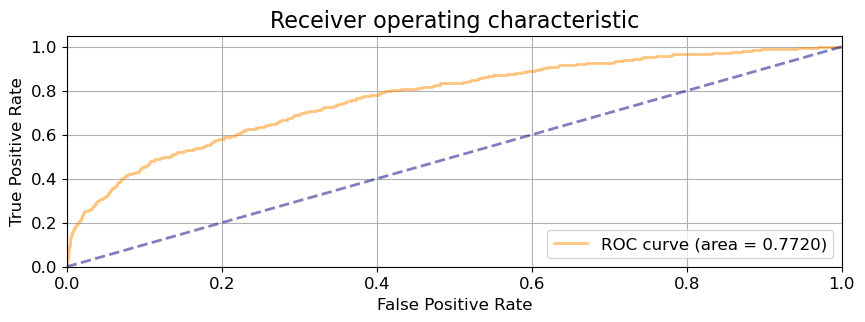

0.7719643286991686

In [231]:
# Для рассчета ROC-AUC на baseline моделе используем тестовые данные
y_pred = model_clf.predict_proba(X_test)[:,1]
# Строим график ROC-AUC
roc_auc = plot_roc_auc(y_true=y_test, y_pred=y_pred)
roc_auc

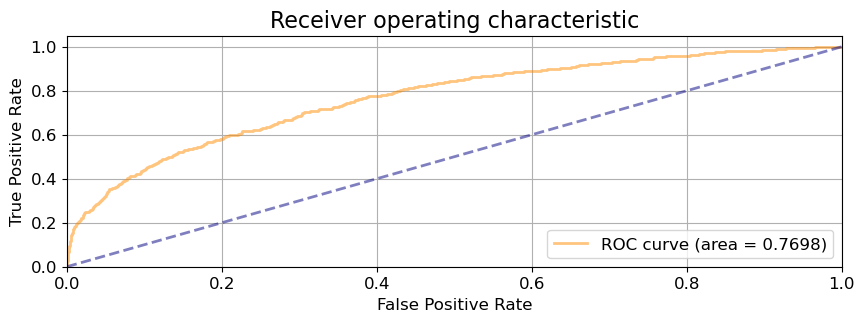

0.7697805389058147

In [66]:
# Для рассчета ROC-AUC на baseline моделе используем тестовые данные
y_pred = model_clf.predict_proba(X_test)[:,1]
# Строим график ROC-AUC
roc_auc = plot_roc_auc(y_true=y_test, y_pred=y_pred)
roc_auc

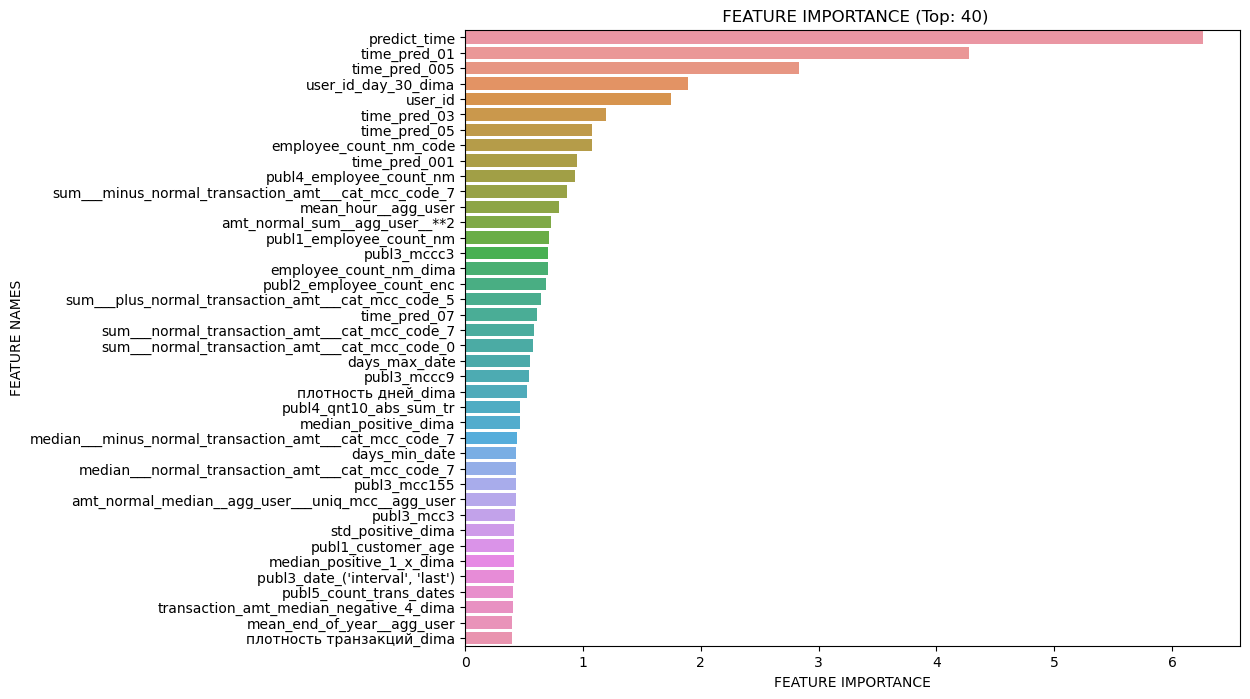

In [67]:
# Важность признаков
fi_df = plot_feature_importance(model_clf.get_feature_importance(), X_train.columns, model_name='', top_n=40)  

In [75]:
fi_df[:100]
# publ5_count_trans_dates
# publ5_trans_negative_last
# publ5_trans_positive_last
# publ5_report
# publ5_mcc_code_nunique
# publ5_day_diff_nunique

,feature_names,feature_importance
534,predict_time,6.265893
734,time_pred_01,4.278053
651,time_pred_005,2.832505
428,user_id_day_30_dima,1.888348
742,user_id,1.749099
767,time_pred_03,1.198130
188,time_pred_05,1.077934
171,employee_count_nm_code,1.075125
477,time_pred_001,0.951148
993,publ4_employee_count_nm,0.927251


In [ ]:
# Подбор гиперпараметров 

# # 1 hour 4 m  0.7081081915291669 and parameters: {'random_strength': 0.4877835608541662, 'bagging_temperature': 7.328762300265087, 'border_count': 64, 'l2_leaf_reg': 0.0007188656778274362, 'learning_rate': 0.03087417961724621, 'max_depth': 15, 'subsample': 0.6060460481741542, 'colsample_bylevel': 0.37109270105885217, 'min_data_in_leaf': 40}. Best is trial 3 with value: 0.7677449956472935.
# # 1h 5m  0.7553564746982396 and parameters: {'random_strength': 0.7819699890386805, 'bagging_temperature': 9.754135319676179, 'border_count': 16, 'l2_leaf_reg': 12.104897228001908, 'learning_rate': 0.0983824932143533, 'max_depth': 15, 'subsample': 0.23933532903265448, 'colsample_bylevel': 0.2705278505465295, 'min_data_in_leaf': 98}. Best is trial 3 with value: 0.7677449956472935.
# # 1h 50m 0.732127446743911 and parameters: {'random_strength': 0.6663800374289677, 'bagging_temperature': 5.417199896472974, 'border_count': 256, 'l2_leaf_reg': 0.028645043290344903, 'learning_rate': 0.004970153667357669, 'max_depth': 13, 'subsample': 0.48360105226679184, 'colsample_bylevel': 0.6068555377131062, 'min_data_in_leaf': 23}. Best is trial 15 with value: 0.770365123419073.
# # 45m 0.7600597284566222 and parameters: {'random_strength': 0.41591580937930017, 'bagging_temperature': 6.58006403058364, 'border_count': 1024, 'l2_leaf_reg': 0.11546521431985014, 'learning_rate': 0.001889071936354402, 'max_depth': 10, 'subsample': 0.5320376571604306, 'colsample_bylevel': 0.9547286589569808, 'min_data_in_leaf': 13}. Best is trial 3 with value: 0.7677449956472935.
# # 28m  0.7651472298266855 and parameters: {'random_strength': 0.9639904775650652, 'bagging_temperature': 9.802421965693892, 'border_count': 32, 'l2_leaf_reg': 2.1876733497044576, 'learning_rate': 0.004815280638331712, 'max_depth': 12, 'subsample': 0.379165594314427, 'colsample_bylevel': 0.7703767777160331, 'min_data_in_leaf': 99}. Best is trial 3 with value: 0.7677449956472935.
# # 13m 0.7185726398062888 and parameters: {'random_strength': 0.36215143542851874, 'bagging_temperature': 4.412510211606131, 'border_count': 512, 'l2_leaf_reg': 0.0003745496093343704, 'learning_rate': 0.016777863904997845, 'max_depth': 9, 'subsample': 0.9240379583912689, 'colsample_bylevel': 0.6892579066981328, 'min_data_in_leaf': 47}. Best is trial 15 with value: 0.770365123419073.
# # 10m 0.7623220650096566 and parameters: {'random_strength': 0.356860344004182, 'bagging_temperature': 4.618962404969036, 'border_count': 512, 'l2_leaf_reg': 0.18815865484252067, 'learning_rate': 0.0023937889983948325, 'max_depth': 9, 'subsample': 0.9235562227095705, 'colsample_bylevel': 0.69242799618673, 'min_data_in_leaf': 41}. Best is trial 0 with value: 0.7623220650096566.

# # 4m 0.6853226231135647 and parameters: {'random_strength': 0.18235950929436537, 'bagging_temperature': 6.858830199410246, 'border_count': 32, 'l2_leaf_reg': 0.0040295486593562016, 'learning_rate': 0.07184200324965376, 'max_depth': 11, 'subsample': 0.15207869271589394, 'colsample_bylevel': 0.08600944919729483, 'min_data_in_leaf': 81}. Best is trial 3 with value: 0.7677449956472935.
# # 3m 0.7586165952134087 and parameters: {'random_strength': 0.1200919298190417, 'bagging_temperature': 4.465601655563133, 'border_count': 256, 'l2_leaf_reg': 0.04563038629317424, 'learning_rate': 0.054820778828215594, 'max_depth': 5, 'subsample': 0.7434866228117001, 'colsample_bylevel': 0.4746647518284687, 'min_data_in_leaf': 33}. Best is trial 0 with value: 0.7623220650096566.
# # 1m  0.7666656378069414 and parameters: {'random_strength': 0.5438113421389065, 'bagging_temperature': 3.961233875660944, 'border_count': 1024, 'l2_leaf_reg': 0.0024789745613403103, 'learning_rate': 0.00980034933463799, 'max_depth': 4, 'subsample': 0.7309059610265581, 'colsample_bylevel': 0.19050169842753084, 'min_data_in_leaf': 29}. Best is trial 2 with value: 0.7666656378069414.
# # 2m 0.7677449956472935 and parameters: {'random_strength': 0.1411360960399606, 'bagging_temperature': 8.880332018146513, 'border_count': 32, 'l2_leaf_reg': 1.019314171350347, 'learning_rate': 0.031914830167293746, 'max_depth': 5, 'subsample': 0.6041617528697946, 'colsample_bylevel': 0.3886648645462683, 'min_data_in_leaf': 87}. Best is trial 3 with value: 0.7677449956472935.
# # 4m 0.7578928238923904 and parameters: {'random_strength': 0.23756234585080094, 'bagging_temperature': 6.42214658244568, 'border_count': 512, 'l2_leaf_reg': 0.001059515046384789, 'learning_rate': 0.021354963214691967, 'max_depth': 6, 'subsample': 0.893689226400846, 'colsample_bylevel': 0.8168397041380171, 'min_data_in_leaf': 59}. Best is trial 3 with value: 0.7677449956472935.
# # 3 m 0.7676243670937904 and parameters: {'random_strength': 0.28511109102872495, 'bagging_temperature': 2.515830746301902, 'border_count': 32, 'l2_leaf_reg': 0.21796527115330408, 'learning_rate': 0.008885334556583689, 'max_depth': 6, 'subsample': 0.4892525374098944, 'colsample_bylevel': 0.7912954323696259, 'min_data_in_leaf': 45}. Best is trial 3 with value: 0.7677449956472935.
# # 3 m 0.7660502117141349 and parameters: {'random_strength': 0.20553110785537693, 'bagging_temperature': 7.138717386553042, 'border_count': 128, 'l2_leaf_reg': 0.000972297706864629, 'learning_rate': 0.010386219006941828, 'max_depth': 3, 'subsample': 0.40582883336095293, 'colsample_bylevel': 0.9679514745790526, 'min_data_in_leaf': 38}. Best is trial 3 with value: 0.7677449956472935.
# # 3m 0.7662190286976273 and parameters: {'random_strength': 0.7562070644244083, 'bagging_temperature': 0.9247199505507142, 'border_count': 32, 'l2_leaf_reg': 1.9559958310038787, 'learning_rate': 0.005600438489798872, 'max_depth': 7, 'subsample': 0.34983776043333037, 'colsample_bylevel': 0.627587017306623, 'min_data_in_leaf': 62}. Best is trial 3 with value: 0.7677449956472935.
# # 3m 0.7592786349509109 and parameters: {'random_strength': 0.3106200304995529, 'bagging_temperature': 1.9260051433957923, 'border_count': 32, 'l2_leaf_reg': 0.45952852798531907, 'learning_rate': 0.021767747307190978, 'max_depth': 8, 'subsample': 0.6456700291799148, 'colsample_bylevel': 0.5311773377096795, 'min_data_in_leaf': 77}. Best is trial 3 with value: 0.7677449956472935.
# # 3m 0.7686249856694538 and parameters: {'random_strength': 0.12168306459684444, 'bagging_temperature': 3.054442548463664, 'border_count': 32, 'l2_leaf_reg': 0.012371254057154354, 'learning_rate': 0.011695884594447392, 'max_depth': 6, 'subsample': 0.4836430136668511, 'colsample_bylevel': 0.43693190185925523, 'min_data_in_leaf': 8}. Best is trial 14 with value: 0.7686249856694538.
# # 2m 0.770365123419073 and parameters: {'random_strength': 0.10423136716481986, 'bagging_temperature': 2.937470362067582, 'border_count': 16, 'l2_leaf_reg': 0.012170839103780163, 'learning_rate': 0.03806092816877672, 'max_depth': 3, 'subsample': 0.7327560678589216, 'colsample_bylevel': 0.39430569420892153, 'min_data_in_leaf': 8}. Best is trial 15 with value: 0.770365123419073.
# # 2m 0.7677330272790608 and parameters: {'random_strength': 0.6436402884136181, 'bagging_temperature': 2.99541302061361, 'border_count': 16, 'l2_leaf_reg': 0.00999207256359148, 'learning_rate': 0.017115678744046063, 'max_depth': 3, 'subsample': 0.7823886942005437, 'colsample_bylevel': 0.3299066493456262, 'min_data_in_leaf': 6}. Best is trial 15 with value: 0.770365123419073.
# # 2m 0.7436857408860876 and parameters: {'random_strength': 0.11329380924303452, 'bagging_temperature': 0.7213560956117973, 'border_count': 16, 'l2_leaf_reg': 0.00013351963347124513, 'learning_rate': 0.0010898556854082634, 'max_depth': 3, 'subsample': 0.08245022583969724, 'colsample_bylevel': 0.5012574147627783, 'min_data_in_leaf': 18}. Best is trial 15 with value: 0.770365123419073.
# # 3 m 0.7187581495138952 and parameters: {'random_strength': 0.4311070714949682, 'bagging_temperature': 3.334236157804488, 'border_count': 64, 'l2_leaf_reg': 0.023195976251140456, 'learning_rate': 0.044917126588457534, 'max_depth': 7, 'subsample': 0.9942253909672493, 'colsample_bylevel': 0.20157600138684834, 'min_data_in_leaf': 1}. Best is trial 15 with value: 0.770365123419073.
# # 3m 0.7690511225699489 and parameters: {'random_strength': 0.37186763151947955, 'bagging_temperature': 1.7154788183066343, 'border_count': 128, 'l2_leaf_reg': 0.00011736187149090363, 'learning_rate': 0.014947547431915422, 'max_depth': 5, 'subsample': 0.837273997330367, 'colsample_bylevel': 0.4307656088410189, 'min_data_in_leaf': 10}. Best is trial 15 with value: 0.770365123419073.
# # 2m 0.7685796318529932 and parameters: {'random_strength': 0.25394919082490486, 'bagging_temperature': 1.857381963749643, 'border_count': 128, 'l2_leaf_reg': 0.004185836770724565, 'learning_rate': 0.013506480144289332, 'max_depth': 5, 'subsample': 0.8489484318148801, 'colsample_bylevel': 0.4366413387252729, 'min_data_in_leaf': 11}. Best is trial 15 with value: 0.770365123419073.
# # 2m 0.7674010625391334 and parameters: {'random_strength': 0.34102674703366276, 'bagging_temperature': 0.17427920975756628, 'border_count': 128, 'l2_leaf_reg': 0.0001544572878642479, 'learning_rate': 0.034343061548256996, 'max_depth': 4, 'subsample': 0.6925149496557448, 'colsample_bylevel': 0.27572891153281753, 'min_data_in_leaf': 19}. Best is trial 15 with value: 0.770365123419073.
# # 3m 0.7587797429698435 and parameters: {'random_strength': 0.10114941390464927, 'bagging_temperature': 1.7803952866129829, 'border_count': 16, 'l2_leaf_reg': 0.009564943526882154, 'learning_rate': 0.007153755831638318, 'max_depth': 8, 'subsample': 0.8081208567067153, 'colsample_bylevel': 0.51388835594809, 'min_data_in_leaf': 1}. Best is trial 15 with value: 0.770365123419073.
# # 2m 0.7674224796191287 and parameters: {'random_strength': 0.208970062934476, 'bagging_temperature': 3.60714396586842, 'border_count': 128, 'l2_leaf_reg': 0.00021141487216976514, 'learning_rate': 0.014794556827658326, 'max_depth': 4, 'subsample': 0.9850965465081523, 'colsample_bylevel': 0.5715795678321548, 'min_data_in_leaf': 23}. Best is trial 15 with value: 0.770365123419073.
# # 2m 0.7579605396600226 and parameters: {'random_strength': 0.40350491986043185, 'bagging_temperature': 5.5339785439725455, 'border_count': 16, 'l2_leaf_reg': 0.0004700395324613062, 'learning_rate': 0.024498532918250805, 'max_depth': 6, 'subsample': 0.5524553225150555, 'colsample_bylevel': 0.4188771787966754, 'min_data_in_leaf': 13}. Best is trial 15 with value: 0.770365123419073.
# # 3 m 0.7643670811921502 and parameters: {'random_strength': 0.5166365186058708, 'bagging_temperature': 2.5823784156927, 'border_count': 128, 'l2_leaf_reg': 0.06765132539290941, 'learning_rate': 0.0035396001126239965, 'max_depth': 7, 'subsample': 0.6768533747312123, 'colsample_bylevel': 0.29979695001660445, 'min_data_in_leaf': 30}. Best is trial 15 with value: 0.770365123419073.
# # 2m 0.7639973216051723 and parameters: {'random_strength': 0.17400368569232882, 'bagging_temperature': 1.1996883681471529, 'border_count': 64, 'l2_leaf_reg': 0.016405712463422255, 'learning_rate': 0.050299236571476266, 'max_depth': 4, 'subsample': 0.27010903910620854, 'colsample_bylevel': 0.19313514080595415, 'min_data_in_leaf': 8}. Best is trial 15 with value: 0.770365123419073.
# # 3m 0.7392845309470507 and parameters: {'random_strength': 0.6211670192991839, 'bagging_temperature': 2.5451556699511375, 'border_count': 256, 'l2_leaf_reg': 0.002105591253628826, 'learning_rate': 0.012627892937413811, 'max_depth': 9, 'subsample': 0.8461975993636881, 'colsample_bylevel': 0.09290272968356755, 'min_data_in_leaf': 18}. Best is trial 15 with value: 0.770365123419073.
# Best hyperparameters: {'random_strength': 0.10423136716481986, 'bagging_temperature': 2.937470362067582, 'border_count': 16, 'l2_leaf_reg': 0.012170839103780163, 'learning_rate': 0.03806092816877672, 'max_depth': 3, 'subsample': 0.7327560678589216, 'colsample_bylevel': 0.39430569420892153, 'min_data_in_leaf': 8}
# Best AUC: 0.770365123419073
# CPU times: total: 1d 18h 51min 51s
# Wall time: 6h 41min 48s

In [ ]:
# fi_df[:100][98:99]['feature_names'].item()
# amt_normal_sum__agg_user ** 2
# amt_normal_median__agg_user ** 2
# amt_normal_max__agg_user ** 2
# minus_amt_normal_skew__agg_user ** 2
# fi_df[:100].reset_index()
# fi_df[49:50]['feature_names'].item()

In [ ]:
# from typing import List
# def gen_num_features(df:pd.DataFrame, columns:List[str]):
#     add_features = []
#     for column_1 in columns:
#         # df[f'sin_{column_1}'] = np.sin(df[column_1])
#         # add_features.append(f'sin_{column_1}')
#         for column_2 in columns:
#             df[f'{column_1}_{column_2}'] = df[column_1] * df[column_2]
#             add_features.append(f'{column_1}_{column_2}')
#     return df, add_features
# amt_normal_count__agg_user
# # gen_num_feat_columns = ['amt_count__agg_user', 'amt_var__agg_user',  'amt_mad__agg_user',  'amt_skew__agg_user', 'amt_normal_count__agg_user',  'amt_normal_sum__agg_user', 'amt_normal_std__agg_user', 'amt_normal_median__agg_user', 'amt_normal_min__agg_user', 'uniq_mcc__agg_user',]
# # [ 'amt_normal_count__agg_user', 'amt_normal_sum__agg_user', 'amt_normal_std__agg_user', 'amt_normal_median__agg_user', 'amt_normal_min__agg_user', 'amt_normal_max__agg_user', 'amt_normal_var__agg_user', 'amt_normal_skew__agg_user' ]
# # gen_num_feat_columns = ['plus_amt_normal_count__agg_user', 'plus_amt_normal_sum__agg_user', 'plus_amt_normal_median__agg_user', 'plus_amt_normal_min__agg_user', 'plus_amt_normal_max__agg_user', 'amt_normal_count__agg_user', 'amt_normal_sum__agg_user', 'amt_normal_median__agg_user', 'amt_normal_min__agg_user', 'amt_normal_max__agg_user', 'minus_amt_normal_count__agg_user', 'minus_amt_normal_sum__agg_user', 'minus_amt_normal_std__agg_user', 'minus_amt_normal_median__agg_user', 'minus_amt_normal_min__agg_user', 'minus_amt_normal_max__agg_user', 'minus_amt_normal_var__agg_user', 'minus_amt_normal_skew__agg_user',]
# gen_num_feat_columns = ['amt_normal_sum__agg_user', 'amt_normal_median__agg_user', 'amt_normal_max__agg_user', 
#                         'minus_amt_normal_sum__agg_user', 'minus_amt_normal_skew__agg_user',]
# df, add_features = gen_num_features(df=train_df, columns=gen_num_feat_columns)
# num_features += add_features 
# num_features = list(set(num_features))
# feature_columns = num_features + cat_features
# len(feature_columns)

In [ ]:
#train_df.shape
publ1_df = pd.read_csv('public_notebooks/publ1.csv')
publ1_df = publ1_df.set_index('user_id').add_prefix('publ1_').reset_index()

publ2_df = pd.read_csv('public_notebooks/publ2.csv')
publ2_df = publ2_df.set_index('user_id').add_prefix('publ2_').reset_index()

publ3_df = pd.read_csv('public_notebooks/publ3.csv')
publ3_df = publ3_df.set_index('user_id').add_prefix('publ3_').reset_index()

publ4_df = pd.read_csv('public_notebooks/publ4.csv')
publ4_df = publ4_df.set_index('user_id').add_prefix('publ4_').reset_index()

publ5_df = pd.read_csv('public_notebooks/publ5.csv')
publ5_df = publ5_df.set_index('user_id').add_prefix('publ5_').reset_index()

publ1_df.shape, publ2_df.shape, publ3_df.shape, publ4_df.shape

In [ ]:
publ2_df = publ2_df[list(set(publ2_df.columns) - set(['publ2_report_dt', 'publ2_last', 'publ2_employee_count_nm']))]

In [ ]:
publ2_df = publ2_df[list(set(publ2_df.columns) - set(['publ2_report_dt', 'publ2_last', 'publ2_employee_count_nm']))]

bad_feats_publ3 = ['publ3_mcc407',  'publ3_mcc309',  'publ3_mccc144',  'publ3_mcc323',  'publ3_mcc228',  'publ3_mccc111',  'publ3_mccc199',  'publ3_mcc154',  'publ3_mccc296',  'publ3_mccc173',  'publ3_mccc234',  'publ3_mccc163',  'publ3_mccc346',  'publ3_mccc287',  'publ3_mccc317',  'publ3_mcc360',  'publ3_mccc340',  'publ3_mccc284',  'publ3_mccc413',  'publ3_mccc297',  'publ3_mccc237',  'publ3_mccc116',  'publ3_mcc330',  'publ3_mccc304',  'publ3_mcc263',  'publ3_mccc407',  'publ3_mccc217',  'publ3_mccc392',  'publ3_mcc297',  'publ3_mccc250',  'publ3_mcc292',  'publ3_mccc228',  'publ3_mcc342',  'publ3_mccc300',  'publ3_mcc287',  'publ3_mccc252',  'publ3_mccc207',  'publ3_mccc356',  'publ3_mccc273',  'publ3_mccc201',  'publ3_mccc168',  'publ3_mcc322',  'publ3_mccc246',  'publ3_mccc342',  'publ3_mccc283',  'publ3_mcc195',  'publ3_mccc259',  'publ3_mccc332',  'publ3_mcc284',  'publ3_mccc322',  'publ3_mcc298',  'publ3_mcc307',  'publ3_mccc310',  'publ3_mcc434',  'publ3_mcc283',  'publ3_mccc382',  'publ3_mccc271',  'publ3_mccc372',  'publ3_mccc154',  'publ3_mccc314',  'publ3_mccc316',  'publ3_mccc278',  'publ3_mccc238',  'publ3_mccc227',  'publ3_mcc221',  'publ3_mccc220',  'publ3_mccc151',  'publ3_mcc276',  'publ3_mccc364',  'publ3_mcc303',  'publ3_mccc309',  'publ3_mcc291',  'publ3_mcc208',  'publ3_mccc298',  'publ3_mccc291',  'publ3_mccc330',  'publ3_mccc226',  'publ3_mccc239',  'publ3_mcc424',  'publ3_mccc177',  'publ3_mcc239',  'publ3_mccc360',  'publ3_mcc392',  'publ3_mccc449',  'publ3_mccc104',  'publ3_mccc253',  'publ3_mccc240',  'publ3_mcc243',  'publ3_mccc243',  'publ3_mccc198',  'publ3_mccc272',  'publ3_mccc235',  'publ3_mccc307',  'publ3_mccc293',  'publ3_mccc269',  'publ3_mccc208',  'publ3_mcc372',  'publ3_mccc270',  'publ3_mcc371',  'publ3_mccc323',  'publ3_mcc413',  'publ3_mcc314',  'publ3_mcc48',  'publ3_mcc293',  'publ3_mcc304',  'publ3_mccc424',  'publ3_mcc300',  'publ3_mccc232',  'publ3_mccc280',  'publ3_mccc241',  'publ3_mcc246',  'publ3_mccc311',  'publ3_mcc238',  'publ3_mcc449',  'publ3_mccc327',  'publ3_mcc273',  'publ3_mccc124',  'publ3_mccc305',  'publ3_mccc274',  'publ3_mccc258',  'publ3_mccc263',  'publ3_mccc266',  'publ3_mccc302',  'publ3_mccc202',  'publ3_mccc92',  'publ3_mccc318',  'publ3_mccc276',  'publ3_mccc167',  'publ3_mccc95',  'publ3_mccc185',  'publ3_mccc242',  'publ3_mcc227',  'publ3_mccc222',  'publ3_mccc251',  'publ3_mccc264',  'publ3_mccc282',  'publ3_mcc198',  'publ3_mcc346',  'publ3_mccc434',  'publ3_mccc338',  'publ3_mcc271',  'publ3_mccc221',  'publ3_mccc231',  'publ3_mccc277',  'publ3_mccc196',  'publ3_mccc200',  'publ3_mcc141',  'publ3_mccc193',  'publ3_mcc250',  'publ3_mcc259',  'publ3_mccc306',  'publ3_mccc236',  'publ3_mccc40',  'publ3_mcc106',  'publ3_mccc303',  'publ3_mccc150',  'publ3_mcc312',  'publ3_mcc274',  'publ3_mccc149',  'publ3_mccc191',  'publ3_mccc412',  'publ3_mccc368',  'publ3_mccc268'] 
publ3_df = publ3_df[list(set(publ3_df.columns) - set(['publ3_employee_count_nm', 'publ2_employee_count_nm']) -set(bad_feats_publ3))]
publ3_df = publ3_df.fillna(0)
publ3_df.shape

In [ ]:
publ_df = publ1_df.merge(publ2_df, on='user_id')
publ_df = publ_df.merge(publ3_df, on='user_id')
publ_df = publ_df.merge(publ4_df, on='user_id')
publ_df = publ_df.merge(publ5_df, on='user_id')
publ_df.shape

In [ ]:
# publ1_df_columns = ['publ1_min_day_trans', 'publ1_sum_trans_m', 'publ1_sum_trans_p', 'publ1_count_trans', 'publ1_customer_age', 'publ1_max_day_trans', 'publ1_employee_count_nm', 'publ1_sum_trans', 'publ1_bankemplstatus']
#  publ1_df.clumns
publ_columns = list(set(publ_df.columns) - set(['user_id']))
len(publ_columns)
# publ_df.isna().sum()

In [ ]:
src_train_df = src_train_df.merge(publ_df, on='user_id')
src_train_df.shape

In [ ]:
src_X_submit = X_submit.merge(publ_df, on='user_id')
src_X_submit.shape

In [ ]:
train_df, val_df = train_test_split(src_train_df, test_size = 0.2, random_state = 53, stratify=train_df['target'])
test_df, val_df = train_test_split(val_df, test_size = 0.5, random_state = 53, stratify=val_df['target'])
train_df.shape, val_df.shape, test_df.shape

In [ ]:
# important_features = feature_columns
# important_features = feature_columns

In [ ]:
# len(publ_columns)

In [ ]:
target_column = 'target'
# select_features = list(set(feature_columns)&set(important_features))
# select_features = list(set(feature_columns) - set(['user_id']))
select_features = list(set(feature_columns) - set([]))

X_train = train_df[select_features + publ_columns + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']]
y_train = train_df[target_column]

X_val = val_df[select_features + publ_columns  + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']]
y_val = val_df[target_column]

X_test = test_df[select_features + publ_columns  + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']]
y_test = test_df[target_column]

X_test_submit = X_submit[select_features + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']]

X_train.shape, X_val.shape, X_test.shape, X_test_submit.shape

In [ ]:
# # X_train.iloc[:,600]
# (select_features + publ_columns)[600]
# feat_important = fi_df[:300]['feature_names'].values
feat_important = ['predict_time', 'time_pred_005', 'time_pred_01', 'user_id_day_30_dima', 'user_id', 'employee_count_nm_code', 'time_pred_03', 'sum___minus_normal_transaction_amt___cat_mcc_code_7', 'mean_hour__agg_user', 'publ2_employee_count_enc', 'time_pred_07', 'publ4_employee_count_nm', "publ3_date_('interval', 'max')", 'sum___normal_transaction_amt___cat_mcc_code_7', 'amt_normal_sum__agg_user__**2', 'publ1_employee_count_nm', 'publ3_msumm4', 'плотность дней_dima', 'publ3_mccc3', 'publ3_mccc9', "publ3_date_('interval', 'last')", 'publ3_mcc155', 'days_max_date', 'publ4_qnt10_abs_sum_tr', 'publ3_customer_age', 'employee_count_nm_dima', 'sum___plus_normal_transaction_amt___cat_mcc_code_5', 'mean_begin_of_year__agg_user', 'days_min_date', 'median___normal_transaction_amt___cat_mcc_code_7', 'median_positive_dima', 'mean_end_of_year__agg_user', 'sum___normal_transaction_amt___cat_mcc_code_0', 'publ3_mcc3', 'publ3_mcc0', 'publ5_count_trans_dates', 'плотность транзакций_dima', 'std_positive_dima', 'amt_normal_median__agg_user___uniq_mcc__agg_user', 'publ3_mcc51', 'skew_weekday__agg_user', 'publ3_mcc42', 'currency_daydiff_100_sum_1_dima', 'mean_is_holiday__agg_user', 'sum___minus_normal_transaction_amt___cat_mcc_code_6', 'transaction_amt_median_positive_5_dima', 'transaction_amt_median_negative_4_dima', 'median___normal_transaction_amt___cat_mcc_code_0', 'median___minus_normal_transaction_amt___cat_mcc_code_7', 'publ3_mcc28', 'sum___minus_normal_transaction_amt___cat_mcc_code_0', 'publ3_mccc0', 'publ3_msumm7', 'publ5_trans_negative_last', 'median___minus_normal_transaction_amt___cat_mcc_code_6', 'publ3_count_trans_ss_sum', 'publ3_mcc181', 'transaction_amt_sum_positive_0_dima', 'publ1_customer_age', 'publ3_mcc32', 'publ4_sum_abs_sum_tr', 'publ3_mccc26', 'publ3_mcc17', 'transaction_amt_median_positive_2_dima', 'amt_skew__agg_user', 'transaction_amt_median_negative_1_dima', 'publ2_report', 'transaction_amt_median_negative_3_dima', 'median___normal_transaction_amt___cat_mcc_code_6', 'positive_general_trans_info_100_median_dima', 'publ3_msumm8', 'currency_daydiff_1000_sum_1_dima', 'publ2_customer_age', 'publ3_mccc33', 'publ4_median_abs_sum_tr', 'publ4_std_abs_sum_tr', 'median___plus_normal_transaction_amt___cat_mcc_code_7', 'publ3_mcc65', 'publ3_mccc155', 'publ4_qnt90_abs_sum_tr', 'transaction_amt_std_positive_1_dima', 'count_day_ bin_1_day_ bin_x_dima', 'median_negative_1_y_dima', 'minus_amt_normal_skew__agg_user', 'customer_age_dima', 'median___normal_transaction_amt___cat_mcc_code_4', 'median___normal_transaction_amt___cat_mcc_code_2', 'amt_std__agg_user', 'publ5_trans_positive_last', 'publ3_msumm3', 'amt_normal_mad__agg_user', 'count_most_time_of_day__agg_user', 'count_day_ bin_3_day_ bin_x_dima', 'currency_daydiff_500_sum_1_dima', 'amt_normal_max__agg_user__**2', 'publ3_mccc13', 'transaction_amt_sum_positive_2_dima', 'publ3_mccc15', 'median___minus_normal_transaction_amt___cat_mcc_code_0', 'transaction_amt_sum_positive_3_dima', 'median___minus_normal_transaction_amt___cat_mcc_code_4', 'median_positive_1_x_dima', 'median___minus_normal_transaction_amt___cat_mcc_code_2', 'publ3_mccc53', 'new_positive_day_30_dima', 'transaction_amt_median_negative_2_dima', 'publ5_report', 'publ3_report', 'std_negative_1_y_dima', 'mcc_code_nunique_positive_5_y_dima', 'sum_positive_dima', 'sum___normal_transaction_amt___cat_mcc_code_2', 'count___normal_transaction_amt___cat_mcc_code_2', 'publ3_msumm5', 'minus_amt_normal_skew__agg_user__**2', 'sum___normal_transaction_amt___cat_mcc_code_4', 'sum_negative_1_y_dima', 'publ3_mcc9', 'mcc_code_count_positive_4_y_dima', 'minus_amt_normal_sum__agg_user', 'publ3_mcc33', 'negative_general_trans_info_100_median_dima', 'publ1_min_day_trans', 'publ3_mcc94', 'transaction_amt_median_positive_3_dima', 'publ4_skew', 'report_dima', 'transaction_amt_median_positive_4_dima', 'currency_daydiff_1500_sum_1_dima', 'publ3_mccc14', 'sum___minus_normal_transaction_amt___cat_mcc_code_2', 'general_trans_info_100_sum_dima', 'count_unique_negative_mcc_dima', 'amt_normal_sum__agg_user', 'negative_general_trans_info_100_sum_dima', 'sum___minus_normal_transaction_amt___cat_mcc_code_4', 'count___plus_normal_transaction_amt___cat_mcc_code_2', 'std_negative_dima', 'delta_first_last_date', 'amt_normal_skew__agg_user', 'publ2_logsumabs_1', 'general_trans_info_100_median_dima', 'publ3_msump6', 'new_positive_dima', 'publ3_mcc15', 'publ3_mcc14', 'publ4_customer_age', 'transaction_amt_median_positive_0_dima', 'publ4_kurtosis', 'report', 'most_weekday__agg_user', 'publ3_mccc18', 'sum___plus_normal_transaction_amt___cat_mcc_code_0', 'publ3_count_trans_dates', 'customer_age', 'employee_count_nm', 'publ3_logsumabs_1', 'publ3_mcc126', 'publ3_mcc4', 'min_diff_dttm_dima', 'transaction_amt_sum_positive_5_dima', 'amt_normal_median__agg_user__**2', 'publ3_count_trans_transaction_amt_min', 'amt_normal_median__agg_user', 'publ3_spc5', 'general_trans_info_1000_sum_dima', 'publ4_report', 'publ3_spc6', 'publ3_msumm6', 'transaction_amt_sum_positive_1_dima', 'publ3_mccc51', 'sum___normal_transaction_amt___cat_mcc_code_6', 'publ1_max_day_trans', 'days_report_dt', 'positive_general_trans_info_500_median_dima', 'publ3_mccc125', 'std_positive_1_x_dima', 'count_most_weekday__agg_user', 'publ3_mccc108', 'transaction_amt_median_negative_0_dima', 'count___normal_transaction_amt___cat_mcc_code_1', 'sum_positive_1_x_dima', 'transaction_amt_sum_negative_3_dima', 'median_negative_1_x_dima', 'publ3_count_trans_sm_sum', 'negative_general_trans_info_500_median_dima', 'currency_daydiff_100_median_1_dima', 'publ3_mcc63', 'publ4_mean_abs_sum_tr', 'positive_general_trans_info_1000_count_dima', 'transaction_amt_median_positive_1_dima', 'publ3_mcc8', 'transaction_amt_sum_positive_4_dima', 'median___normal_transaction_amt___cat_mcc_code_5', 'count_most_month__agg_user', 'publ3_count_trans_transaction_amt_sum', 'count___minus_normal_transaction_amt___cat_mcc_code_0', 'amt_normal_std__agg_user', 'median___plus_normal_transaction_amt___cat_mcc_code_0', 'count_most_season_of_year__agg_user', 'nunique_1_amt_30_dima', 'median_positive_1_y_dima', 'count___minus_normal_transaction_amt___cat_mcc_code_2', 'count_day_ bin_4_day_ bin_x_dima', 'positive_general_trans_info_1500_count_dima', 'amt_median__agg_user', 'publ3_mccc1', 'count_day_ bin_1_day_ bin_y_dima', 'new_negative_day_30_dima', 'publ3_mcc107', 'publ3_mccc12', 'std_negative_1_x_dima', 'sum___normal_transaction_amt___cat_mcc_code_5', 'general_trans_info_100_count_dima', 'amt_var__agg_user', 'sum_positive_1_y_dima', 'count___normal_transaction_amt___cat_mcc_code_0', 'plus_amt_normal_sum__agg_user', 'publ3_mcc13', 'transaction_amt_std_positive_2_dima', 'publ3_mccc28', 'publ3_mcc39', 'publ3_mcc22', 'publ5_mcc_code_nunique', 'transaction_amt_std_negative_1_dima', 'transaction_amt_std_negative_5_dima', 'currency_daydiff_1000_median_0_dima', 'publ3_msump7', 'publ3_mcc123', 'transaction_amt_nunique_positive_1_dima', 'sum___minus_normal_transaction_amt___cat_mcc_code_5', 'count_day_ bin_6_day_ bin_x_dima', 'publ3_mcc36', 'median___minus_normal_transaction_amt___cat_mcc_code_1', 'publ3_spc7', 'max_min_diff_dttm_dima', 'currency_daydiff_1000_count_0_norm_dima', 'transaction_amt_std_positive_5_dima', 'amt_mad__agg_user', 'amt_count__agg_user', 'transaction_amt_std_negative_3_dima', 'publ3_mcc214', 'publ3_mcc2', 'sum_negative_1_x_dima', 'publ5_trans_positive_max', '1_positivecurrency_rk_dima', 'publ5_day_diff_nunique', 'publ3_mcc19', 'publ3_mcc30', 'count_day_ bin_5_day_ bin_x_dima', 'currency_daydiff_500_sum_0_dima', 'publ3_mcc6', 'publ5_trans_negative_max', 'positive_date_dima', 'publ3_count_trans_mcc_code_nunique', 'sum_1_amt_30_dima', 'publ3_msum(5, 1)', 'amt_min__agg_user', 'transaction_amt_std_positive_4_dima', 'publ3_mcc81', 'general_trans_info_1000_count_dima', 'publ3_msumm9', 'std_positive_1_y_dima', 'negative_general_trans_info_1000_count_dima', 'currency_daydiff_1500_median_1_dima', 'negative_general_trans_info_500_count_dima', 'publ3_msump4', 'publ3_mcc23', 'median_negative_dima', 'count___plus_normal_transaction_amt___cat_mcc_code_0', 'publ3_mccc89', 'publ5_trans_negative_median', 'publ4_life', 'mcc_code_count_positive_5_y_dima', 'publ3_mcc131', 'publ3_spc4', 'publ4_unique_days', 'publ3_count_trans_transaction_amt_max', 'sum_1_amt_dima', 'publ5_transaction_dttm_count', 'publ3_mccc35', 'mcc_code_nunique_positive_1_y_dima', 'nunique_mcc_codes_dima', 'positive_general_trans_info_1000_median_dima', 'delta_report_first_date', 'new_negative_dima', 'publ3_count_trans_transaction_amt_count', 'plus_amt_normal_skew__agg_user', 'publ3_mcc96', 'count___plus_normal_transaction_amt___cat_mcc_code_4', 'publ3_msump5', 'publ3_mcc122', 'transaction_amt_std_positive_3_dima', 'plus_amt_normal_count__agg_user', 'negative_general_trans_info_1500_count_dima', 'positive_general_trans_info_500_sum_dima', 'publ3_smc(6, 1)', '1_negativecurrency_rk_dima', 'median___minus_normal_transaction_amt___cat_mcc_code_5', 'count___normal_transaction_amt___cat_mcc_code_3'] 
len(feat_important)

In [ ]:
target_column = 'target'
# select_features = list(set(feature_columns)&set(important_features))
# select_features = list(set(feature_columns) - set(['user_id']))
select_features = list(set(feature_columns) - set([]))

X_train = train_df[feat_important]
y_train = train_df[target_column]

X_val = val_df[feat_important]
y_val = val_df[target_column]

X_test = test_df[feat_important]
y_test = test_df[target_column]

X_test_submit = X_submit[select_features + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']]

X_train.shape, X_val.shape, X_test.shape, X_test_submit.shape

In [ ]:
# # Сохраняем итоговый набор фичей
# save_train_df[select_features + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07'] + ['target']].to_csv('features_X_train__v2.csv', index=False)
# X_submit[select_features + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']].to_csv('features_X_test__v2.csv', index=False)
# save_train_df.shape, X_submit.shape

In [ ]:
# from sksurv.datasets import load_flchain
# 0.7715
# 0.7559
# 0.7550
# 0.7553
# 0.7599 + soft_max mcc
# 0.7540
# 0.7644 / 0.76660 все фичи - ignore user_id
# 0.7664 / 0.76622 все фичи + user_id
# 0.766488317 / 0.7662259651407585
# 0.765666909 / 0.766446489420671 # + publ1.csv
# 0.7654149433 / 0.7671632722017314  # + publ2.csv
# 0.7655966 / 0.7683315145601235 # + publ3.csv
# 0.7658061 / 0.7688807746049413 # + publ3.csv without zero_FI publ3
# 0.7658823396 / 0.7698089325899236 # + publ4.csv
# 0.7673856296 / 0.7685495149570041 # + publ5.csv
# 0.7655503749 / 0.7676794062817556 # + publ5.csv  top 300 feats
# 0.7673138194 / 0.7697805389058147 # + embedding publ6.csv
# 0.7677191692 / 0.768448559635728 # + publ6 top 300 feats
# 0.7654136835 / 0.7719643286991686 / 7000 # + publ6 remove correlation 0.9

# param = {'random_strength': 0.10423136716481986, 
# 'bagging_temperature': 2.937470362067582, 
# 'border_count': 16, 
# 'l2_leaf_reg': 0.012170839103780163, 
# 'learning_rate': 0.03806092816877672, 
# 'max_depth': 3, 
# 'subsample': 0.7327560678589216, 
# 'colsample_bylevel': 0.39430569420892153, 
# 'min_data_in_leaf': 8} # 0.77


model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=500, iterations=7000, random_state=53, cat_features=cat_features, learning_rate=0.01)
# model_clf = CatBoostClassifier(**param, eval_metric="AUC", early_stopping_rounds=500, iterations=7000, random_state=53, cat_features=cat_features)

model_clf.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)

In [ ]:
model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=500, iterations=7000, random_state=53, cat_features=cat_features, learning_rate=0.01, ignored_features=['user_id'])

# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=50, iterations=1000, random_state=53, cat_features=cat_features)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=3000, random_state=53, cat_features=cat_features, class_weights=class_weights, learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=7000, random_state=53, cat_features=cat_features, learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=3000, random_state=53, cat_features=cat_features, class_weights=class_weights, learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=50, iterations=1000, random_state=53, cat_features=cat_features, auto_class_weights='Balanced')
model_clf.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)

In [ ]:
res_X_train = save_train_df.copy()
res_X_train, res_y_train = res_X_train[select_features + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']], res_X_train[target_column]

res_X_test_submit = X_submit[select_features + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']]

res_X_train.shape, res_y_train.shape, res_X_test_submit.shape

In [ ]:
%%time
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=500, iterations=2500, random_state=53, cat_features=cat_features, learning_rate=0.01, ignored_features=['user_id'])
submit_model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=300, iterations=3500, random_state=53, cat_features=cat_features, learning_rate=0.01)
submit_model_clf.fit(res_X_train, res_y_train, plot=False, verbose=False)

In [ ]:
# res_X_test_submit['predict'] = submit_model_clf.predict_proba(res_X_test_submit)[:,1]
# res_X_test_submit[['user_id', 'predict']].to_csv('submit_v5.csv', index=False)
# res_X_test_submit.shape

## Подбор гиперпараметров

## Подбор гиперпараметров CatBoost

In [ ]:
train_df = save_train_df.copy()

train_df, test_df = train_test_split(train_df, test_size = 0.1, random_state = 53, stratify=train_df['target'])
train_df.shape, test_df.shape

In [ ]:
target_column = 'target'
# select_features = list(set(feature_columns)&set(important_features))
# select_features = list(set(feature_columns) - set(['user_id']))
select_features = list(set(feature_columns) - set([]))

X_train = train_df[select_features + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']]
y_train = train_df[target_column]

X_test = test_df[select_features + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']]
y_test = test_df[target_column]

X_train.shape, X_test.shape

In [ ]:
%%time
import optuna

def objective(trial):
    params = {
        # "iterations": trial.suggest_int("iterations", 00, 100),
        'iterations': 2000,
        'early_stopping_rounds': 200,
        # 'early_stopping_rounds': trial.suggest_int("early_stopping_rounds", 100, 500),
        'random_state': 53,
        'random_strength': trial.suggest_float("random_strength", 0.1, 1),
        'bagging_temperature': trial.suggest_float("bagging_temperature", 1e-3, 10),
        'border_count' : trial.suggest_categorical('border_count', [16, 32, 64, 128, 256, 512, 1024]),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 20.0, log = True),
        # 'max_bin': trial.suggest_int('max_bin', 200, 400),
        #'random_state': trial.suggest_int("iterations", 51, 55),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        # "depth": trial.suggest_int("depth", 1, 10),
        'max_depth': trial.suggest_int('max_depth', 3, 16),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        # 'task_type': 'GPU',
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),        
    }
    
    # model = CatBoostClassifier(**params, eval_metric="AUC", cat_features=list(set(cat_features)&set(important_features)))
    print(params)
    cv_model = CatBoostClassifier(**params, cat_features=cat_features, )
    cv_model.fit(X_train, y_train)
    y_pred = cv_model.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_true=y_test, y_score=y_pred)
    return roc_auc


#  model_clf.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print('Best hyperparameters:', study.best_params)
print('Best AUC:', study.best_value)


# 22 min: {'iterations': 2000, 'early_stopping_rounds': 200, 'random_state': 53, 'random_strength': 0.18494737845850068, 'bagging_temperature': 9.08226897657154, 'border_count': 32, 'l2_leaf_reg': 0.1074294116924661, 'learning_rate': 0.028429291192060474, 'max_depth': 13, 'subsample': 0.7272629474759197, 'colsample_bylevel': 0.30662767874560265, 'min_data_in_leaf': 65}
# 3 min: {'iterations': 2000, 'early_stopping_rounds': 200, 'random_state': 53, 'random_strength': 0.5972477975285083, 'bagging_temperature': 2.605315509095001, 'border_count': 128, 'l2_leaf_reg': 1.5232245331321652, 'learning_rate': 0.006709917646816667, 'max_depth': 6, 'subsample': 0.7041525062287023, 'colsample_bylevel': 0.7200058227535646, 'min_data_in_leaf': 17}
# 13 min: {'iterations': 2000, 'early_stopping_rounds': 200, 'random_state': 53, 'random_strength': 0.356860344004182, 'bagging_temperature': 4.618962404969036, 'border_count': 512, 'l2_leaf_reg': 0.18815865484252067, 'learning_rate': 0.0023937889983948325, 'max_depth': 9, 'subsample': 0.9235562227095705, 'colsample_bylevel': 0.69242799618673, 'min_data_in_leaf': 41}


# 0.770 {'random_strength': 0.10423136716481986, 'bagging_temperature': 2.937470362067582, 'border_count': 16, 'l2_leaf_reg': 0.012170839103780163, 'learning_rate': 0.03806092816877672, 'max_depth': 3, 'subsample': 0.7327560678589216, 'colsample_bylevel': 0.39430569420892153, 'min_data_in_leaf': 8}
# 2m 0.770365123419073 and parameters: {'random_strength': 0.10423136716481986, 'bagging_temperature': 2.937470362067582, 'border_count': 16, 'l2_leaf_reg': 0.012170839103780163, 'learning_rate': 0.03806092816877672, 'max_depth': 3, 'subsample': 0.7327560678589216, 'colsample_bylevel': 0.39430569420892153, 'min_data_in_leaf': 8}. Best is trial 15 with value: 0.770365123419073.


In [ ]:
{'random_strength': 0.515865926602303, 'bagging_temperature': 3.644323605308037, 'border_count': 256, 'l2_leaf_reg': 0.00022389945416213016, 'learning_rate': 0.006952759495181764, 'max_depth': 16, 'subsample': 0.2372103883406267, 'colsample_bylevel': 0.07549644846435086, 'min_data_in_leaf': 43} 

## Blending на различных моделях 


In [ ]:
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, KFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# from sklearn.tree import DecisionTreeClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.neural_network import MLPClassifier
# from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, RandomForestClassifier


In [ ]:
# from xgboost import XGBClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.linear_model import LogisticRegression
# from lightgbm import LGBMClassifier
# from sklearn.linear_model import SGDClassifier
# from catboost import CatBoostClassifier
# models = {}
# models['XGB'] = XGBClassifier(random_state = 0)
# models['RF'] = RandomForestClassifier(random_state=0)
# models['ADA'] = AdaBoostClassifier(random_state=0)
# models['LR'] = LogisticRegression(random_state=0)
# models['LGBM'] = LGBMClassifier(random_state=0)
# models['SGDC'] = SGDClassifier(random_state=0)

# model_scores = []
# model_names = []

# for model_name in models.keys():
#     model_names.append(model_name)
#     model_scores.append(evaluateModel(models[model_name]))

In [ ]:
target_column = 'target'
# select_features = list(set(feature_columns)&set(important_features))
# select_features = list(set(feature_columns) - set(['user_id']))
select_features = list(set(feature_columns) - set([]))

X_train = train_df[select_features + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']]
y_train = train_df[target_column]

X_val = val_df[select_features + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']]
y_val = val_df[target_column]

X_test = test_df[select_features + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']]
y_test = test_df[target_column]

X_test_submit = X_submit[select_features + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']]

X_train.shape, X_val.shape, X_test.shape, X_test_submit.shape

In [ ]:
# train_df = save_train_df.copy()
save_train_df.shape, train_df.shape

In [ ]:
cv_X_train, cv_y_train = train_df[select_features + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']], train_df[target_column]
cv_X_train.shape, cv_y_train.shape

In [ ]:
cv_y_train.value_counts()

In [ ]:
%%time
# Кроссвалидация для блендинга
from sklearn.model_selection import KFold, StratifiedKFold

# kf = KFold(n_splits=5, random_state=53, shuffle=True)
kf = StratifiedKFold(n_splits=5, random_state=53, shuffle=True)

# train_df['predict_time'] = np.nan
# qnt_columns = ['time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']
# train_df[qnt_columns] = np.nan

# for i, (train_index, test_index) in enumerate(kf.split(cv_X_train, cv_y_train)):
for i, (train_index, test_index) in enumerate(kf.split(cv_X_train, cv_y_train)):
    print(f'fold: {i+1}')
    print(f'train_index: {len(train_index)}, test_index: {len(test_index)}')
    
    fold_X_train = cv_X_train.iloc[train_index]
    fold_y_train = cv_y_train.iloc[train_index]
    fold_X_train, fold_X_val, fold_y_train, fold_y_val = train_test_split(fold_X_train, fold_y_train, test_size = 0.05, random_state = 53)
    
    fold_X_test = cv_X_train.iloc[test_index]
    fold_y_test = cv_y_train.iloc[test_index]
    
    # fold_model_reg = CatBoostRegressor(eval_metric="RMSE", early_stopping_rounds=20, iterations=2000, random_state=53, cat_features=cat_features)
    fold_model_reg = CatBoostRegressor(eval_metric="MAE", early_stopping_rounds=100, iterations=2000, random_state=53, cat_features=cat_features, ignored_features=['user_id'])
    fold_model_reg.fit(fold_X_train, fold_y_train, eval_set=(fold_X_val, fold_y_val), plot=True, verbose=False)
    
    continue
    qnt_fold_model_reg = CatBoostRegressor(loss_function='MultiQuantile:alpha=0.05, 0.1, 0.3, 0.7',
                                       early_stopping_rounds=100, iterations=2000, random_state=53, cat_features=cat_features, ignored_features=['user_id'])
    qnt_fold_model_reg.fit(fold_X_train, fold_y_train, eval_set=(fold_X_val, fold_y_val), plot=True, verbose=False)
    # train_df[qnt_columns].iloc[test_index] = qnt_fold_model_reg.predict(fold_X_test)
    train_df.loc[test_index, qnt_columns] = qnt_fold_model_reg.predict(fold_X_test)
    
    predict_time = fold_model_reg.predict(fold_X_test)
    train_df['predict_time'].iloc[test_index] = predict_time
    fold_mae = mean_absolute_error(y_true=fold_y_test, y_pred=predict_time)
    print(f'MAE fold #{i}: {fold_mae}')
    
#     submit_predict_time = fold_model_reg.predict(X_submit[feature_columns])
#     X_submit[f'predict_time_{i+1}'] = submit_predict_time    

# train_df[qnt_columns] = np.sort(train_df[qnt_columns].values)
# save_train_df = train_df.copy()


# X_submit
# save_X_submit = X_submit.copy()
#     X_submit[sorted_qnt_columns] = qnt_fold_model_reg.predict(X_submit[feature_columns])
#     X_submit[sorted_qnt_columns] = np.sort(X_submit[sorted_qnt_columns].values)
    


In [ ]:
# X_train[list(Dima_current_time_df.set_index('user_id').add_suffix('_dima').columns)]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
# Расчет дисбалнса классов
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

In [ ]:
!pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
ros = RandomOverSampler(random_state=53)
# X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
# X_resampled, y_resampled = SMOTE().fit_resample(X_train[set(X_train.columns) - set(cat_features)], y_train)
X_resampled, y_resampled = ADASYN().fit_resample(X_train[set(X_train.columns) - set(cat_features)], y_train)
from collections import Counter
print(sorted(Counter(y_resampled).items()))


In [ ]:
%%time
from imblearn.under_sampling import ClusterCentroids
# from imblearn.under_sampling import RandomUnderSampler
# cc = ClusterCentroids(random_state=53)
# X_resampled, y_resampled = cc.fit_resample(X_train[set(X_train.columns) - set(cat_features)], y_train)

from imblearn.under_sampling import EditedNearestNeighbours
enn = EditedNearestNeighbours()

# rus = RandomUnderSampler(random_state=0)
# X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

X_train.shape, X_resampled.shape

In [ ]:
X_train.shape, X_resampled.shape

In [ ]:
X_train = X_train[blue_area + ['user_id']]
X_val = X_val[blue_area + ['user_id']]
X_test = X_test[blue_area + ['user_id']]

X_train.shape, X_val.shape, X_test.shape, X_test_submit.shape

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
# Расчет дисбалнса классов
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

In [ ]:
# from sksurv.datasets import load_flchain
# 0.7715
# 0.7559
# 0.7550
# 0.7553
# 0.7599 + soft_max mcc
# 0.7540

# model_clf = CatBoostClassifier(eval_metric='Cox', loss_function='Cox', early_stopping_rounds=200, iterations=7000, random_state=53, cat_features=list(set(cat_features)&set(important_features)), learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=500, iterations=7000, random_state=53, cat_features=list(set(cat_features)&set(blue_area)), learning_rate=0.01, ignored_features=['user_id'], class_weights=class_weights)
model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=500, iterations=7000, random_state=53, learning_rate=0.01, ignored_features=['user_id'], class_weights=class_weights)

# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=50, iterations=1000, random_state=53, cat_features=cat_features)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=3000, random_state=53, cat_features=cat_features, class_weights=class_weights, learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=7000, random_state=53, cat_features=cat_features, learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=3000, random_state=53, cat_features=cat_features, class_weights=class_weights, learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=50, iterations=1000, random_state=53, cat_features=cat_features, auto_class_weights='Balanced')
# model_clf.fit(X_resampled, y_resampled, eval_set=(X_val, y_val), plot=True, verbose=False)
X_val_resampled = X_val[set(X_train.columns) - set(cat_features)]
model_clf.fit(X_resampled[set(X_train.columns) - set(cat_features)], y_resampled, eval_set=(X_val_resampled, y_val), plot=True, verbose=False)




In [ ]:
# Для рассчета ROC-AUC на baseline моделе используем тестовые данные
y_pred = model_clf.predict_proba(X_test[set(X_train.columns) - set(cat_features)])[:,1]
# Строим график ROC-AUC
roc_auc = plot_roc_auc(y_true=y_test, y_pred=y_pred)
roc_auc

In [ ]:
# Важность признаков
fi_df = plot_feature_importance(model_clf.get_feature_importance(), X_train.columns, model_name='', top_n=40)  

In [ ]:
feature_importance_columns = list(fi_df[fi_df['feature_importance'] > 0]['feature_names'].values)
len(feature_importance_columns)

In [ ]:
# from sksurv.datasets import load_flchain
# 0.7715
# 0.7559
# 0.7550
# 0.7553
# 0.7599 + soft_max mcc
# 0.7540



# model_clf = CatBoostClassifier(eval_metric='Cox', loss_function='Cox', early_stopping_rounds=200, iterations=7000, random_state=53, cat_features=list(set(cat_features)&set(important_features)), learning_rate=0.01)
model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=500, iterations=7000, random_state=53, cat_features=cat_features, learning_rate=0.01, ignored_features=['user_id'])

# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=50, iterations=1000, random_state=53, cat_features=cat_features)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=3000, random_state=53, cat_features=cat_features, class_weights=class_weights, learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=7000, random_state=53, cat_features=cat_features, learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=3000, random_state=53, cat_features=cat_features, class_weights=class_weights, learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=50, iterations=1000, random_state=53, cat_features=cat_features, auto_class_weights='Balanced')
model_clf.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)




In [ ]:
# train_df, val_df = train_test_split(train_df, test_size = 0.2, random_state = 53, stratify=train_df['target'])
# test_df, val_df = train_test_split(val_df, test_size = 0.5, random_state = 53, stratify=val_df['target'])
# train_df.shape, val_df.shape, test_df.shape

# X_train, X_val = train_test_split(train_df, test_size = 0.02, random_state = 53, stratify=train_df['target'])
X_train = train_df.copy()

target_column = 'target'

select_features = feature_columns

X_train, y_train = X_train[select_features + ['predict_time']], X_train[target_column]

# X_val, y_val = X_val[select_features + ['predict_time']], X_val[target_column]

X_test_submit = X_submit[select_features + ['predict_time']]

# X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test_submit.shape
X_train.shape, y_train.shape, X_test_submit.shape

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
# Расчет дисбалнса классов
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

In [ ]:
%%time
# from sksurv.datasets import load_flchain
# 0.7564
# 0.7532
# 0.7524
# 0.7557
# 0.7715
# 0.7559
# 0.7550
# 0.7553
# 0.7599 + soft_max mcc
# 0.7540



# model_clf = CatBoostClassifier(eval_metric='Cox', loss_function='Cox', early_stopping_rounds=200, iterations=7000, random_state=53, cat_features=list(set(cat_features)&set(important_features)), learning_rate=0.01)
model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=500, iterations=2300, random_state=53, cat_features=list(set(cat_features)&set(important_features)), ignored_features=['user_id'], learning_rate=0.01)

# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=50, iterations=1000, random_state=53, cat_features=cat_features)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=3000, random_state=53, cat_features=cat_features, class_weights=class_weights, learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=7000, random_state=53, cat_features=cat_features, learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=3000, random_state=53, cat_features=cat_features, class_weights=class_weights, learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=50, iterations=1000, random_state=53, cat_features=cat_features, auto_class_weights='Balanced')
model_clf.fit(X_train, y_train, plot=False, verbose=False)




In [ ]:
# X_test_submit['predict'] = model_clf.predict_proba(X_test_submit[select_features + ['predict_time']])[:,1]
# X_test_submit.shape

In [ ]:
X_train[select_features + ['predict_time']].set_index('user_id').to_csv('features_X_train__v1.csv')

In [ ]:
X_test_submit[select_features + ['predict_time']].set_index('user_id').to_csv('features_X_test__v1.csv')

In [ ]:
X_test_submit[['user_id', 'predict']].to_csv('submit_1.csv', index=False)

In [ ]:
X_test_submit.merge(submit_df['user_id'], left_index=True, right_index=True)#[['user_id', 'predict']]

In [ ]:
X_test_submit

In [ ]:
# from sksurv.datasets import load_flchain
# 0.7564
# 0.7532
# 0.7524
# 0.7557
# 0.7715
# 0.7559
# 0.7550
# 0.7553
# 0.7599 + soft_max mcc
# 0.7540



# model_clf = CatBoostClassifier(eval_metric='Cox', loss_function='Cox', early_stopping_rounds=200, iterations=7000, random_state=53, cat_features=list(set(cat_features)&set(important_features)), learning_rate=0.01)
model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=500, iterations=7000, random_state=53, cat_features=list(set(cat_features)&set(important_features)), learning_rate=0.01)

# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=50, iterations=1000, random_state=53, cat_features=cat_features)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=3000, random_state=53, cat_features=cat_features, class_weights=class_weights, learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=7000, random_state=53, cat_features=cat_features, learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=3000, random_state=53, cat_features=cat_features, class_weights=class_weights, learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=50, iterations=1000, random_state=53, cat_features=cat_features, auto_class_weights='Balanced')
model_clf.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)




In [ ]:
from lifelines.utils import concordance_index
print(f'Concordance Index: {concordance_index(y_test, model_clf.predict_proba(X_test)[:,1])}')

In [ ]:
from lifelines.utils import concordance_index
print(f'Concordance Index: {concordance_index(y_test, model_clf.predict_proba(X_test)[:,1])}')

In [ ]:
# model_clf.get_borders()#.tree_count_
# for i in model_clf.iterate_leaf_indexes(X_train):
#     print(i)
#     break
# for i in model_clf.get_borders()#.tree_count_
pool = Pool(X_train, y_train, cat_features=cat_features)
# train_OHE_df = pd.DataFrame(X_train.index)
# val_OHE_df = pd.DataFrame()
train_OHE_df = X_train[['user_id']]
val_OHE_df = X_val[['user_id']]
test_OHE_df = X_test[['user_id']]

for tree_idx in trange(min(model_clf.tree_count_, 200)):
    tree_splits = model_clf._get_tree_splits(tree_idx, pool)
    for t_split in tree_splits:
        if 'counter_type' in t_split:
            continue
        feat_name, bin_val = t_split.split(',')
        if feat_name not in train_OHE_df:
            if feat_name in cat_features:
                cat_val = t_split.split('=')[1].strip()
                train_OHE_df[feat_name] = np.where(X_train[feat_name] == cat_val, 1, 0)
                val_OHE_df[feat_name] = np.where(X_val[feat_name] == cat_val, 1, 0)
                test_OHE_df[feat_name] = np.where(X_test[feat_name] == cat_val, 1, 0)
            else:
                bin_val = float(t_split.split('=')[1].strip())
                train_OHE_df[feat_name] = np.where(X_train[feat_name] > bin_val, 1, 0)
                val_OHE_df[feat_name] = np.where(X_val[feat_name] > bin_val, 1, 0)
                test_OHE_df[feat_name] = np.where(X_test[feat_name] > bin_val, 1, 0)

#### Формируем вектор на основе сплитов

In [ ]:
# model_clf.get_borders()#.tree_count_
# for i in model_clf.iterate_leaf_indexes(X_train):
#     print(i)
#     break
# for i in model_clf.get_borders()#.tree_count_
pool = Pool(X_train, y_train, cat_features=cat_features)
# train_OHE_df = pd.DataFrame(X_train.index)
# val_OHE_df = pd.DataFrame()
train_OHE_df = X_train[['user_id']]
val_OHE_df = X_val[['user_id']]
test_OHE_df = X_test[['user_id']]

for tree_idx in trange(min(model_clf.tree_count_, 200)):
    tree_splits = model_clf._get_tree_splits(tree_idx, pool)
    for t_split in tree_splits:
        if 'counter_type' in t_split:
            continue
        feat_name, bin_val = t_split.split(',')
        if feat_name not in train_OHE_df:
            if feat_name in cat_features:
                cat_val = t_split.split('=')[1].strip()
                train_OHE_df[feat_name] = np.where(X_train[feat_name] == cat_val, 1, 0)
                val_OHE_df[feat_name] = np.where(X_val[feat_name] == cat_val, 1, 0)
                test_OHE_df[feat_name] = np.where(X_test[feat_name] == cat_val, 1, 0)
            else:
                bin_val = float(t_split.split('=')[1].strip())
                train_OHE_df[feat_name] = np.where(X_train[feat_name] > bin_val, 1, 0)
                val_OHE_df[feat_name] = np.where(X_val[feat_name] > bin_val, 1, 0)
                test_OHE_df[feat_name] = np.where(X_test[feat_name] > bin_val, 1, 0)

####### Построение NN модели

In [ ]:
nn_train_df = pd.concat([
        train_OHE_df.set_index('user_id'),
        val_OHE_df.set_index('user_id'),
        test_OHE_df.set_index('user_id')
])
nn_train_df.shape

In [ ]:
# expense_user_mcc_transactions_df.shape, income_user_mcc_transactions_df.shape, train_OHE_df.shape
# nn_train_df = train_OHE_df.set_index('user_id').copy()
nn_train_df = nn_train_df.merge(income_user_mcc_transactions_df.drop(columns=['user_group_income'], errors='ignore'), left_index=True, right_index=True, how='left')
nn_train_df = nn_train_df.merge(expense_user_mcc_transactions_df.drop(columns=['user_group_expense'], errors='ignore'), left_index=True, right_index=True, how='left')
nn_train_df = nn_train_df.merge(src_train_df.set_index('user_id')[['target']], left_index=True, right_on='user_id', how='left')
nn_train_df.shape


In [ ]:
nn_train_df = nn_train_df.fillna(0)
nn_train_df.shape

In [ ]:
# train_df.shape


In [ ]:
# pd.concat([
#     income_user_mcc_transactions_df.drop(columns=['user_group_income'], errors='ignore'), 
#     expense_user_mcc_transactions_df.drop(columns=['user_group_expense'], errors='ignore'),
    
    
# ])

# train_OHE_df

In [ ]:
# expense_user_mcc_transactions_df
# income_user_mcc_transactions_df.drop(columns=['user_group_income'], errors='ignore')
# expense_user_mcc_transactions_df.drop(columns=['user_group_income'], errors='ignore')
# train_OHE_df.shape

In [ ]:
# train_df#['target']
# train_df[['user_id', 'employee_count_nm_code', 'predict_time', 'customer_age', 'mean_hour__agg_user', 'delta_first_last_date', 'target']]

In [ ]:
import torch
import torch.nn as nn

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(self.__class__,self).__init__()
        self.fc1 = nn.Linear(675, 300)
        self.act1 = nn.ReLU() # можно заменить на nn.Sigmoid / nn.Tanh / nn.ReLU / ...

        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 10)
        
        self.fc4 = nn.Linear(10, 1)
        self.act2 = nn.Sigmoid()
        
    def forward(self, x):
        """
        params:
            x (torch.Tensor): данные, поданные на вход сети
        """
        x = self.act1(self.fc1(x))
        x = self.act1(self.fc2(x))
        x = self.act1(self.fc3(x))
        x = self.act2(self.fc4(x))
        return x
model = Net()

In [ ]:
import tqdm
from tqdm.auto import tqdm

# def train(model, X, y, criterion, optimizer, num_epoch):
#     '''
#     args:
#         model - модель нейронной сети
#         X и y - обучающая выборка
#         criterion - функция потерь, взятая из модуля `torch.nn`
#         optimizer - оптимизатор, взятый из модуля `torch.optim`
#         num_epoch - количество эпох обучения.
#     '''
#     # цикл по количеству эпох обучения
#     for t in tqdm(range(num_epoch)):
#         # Вычислим предсказания нашей модели
#         y_pred = model(X)[:,0]
# #         print(y_pred[:,0])
#         # Посчитаем значение функции потерь  на полученном предсказании
#         loss = criterion(y_pred, y)

#         # Выполним подсчёт новых градиентов
#         loss.backward()
#         # Выполним шаг градиентного спуска
#         optimizer.step()
#         # Обнулим сохраненные у оптимизатора значения градиентов
#         # перед следующим шагом обучения
#         optimizer.zero_grad()

#     return model

def train_stochastic(model, loader, criterion, optimizer, num_epoch):
    '''
    args:
        model - модель нейронной сети
        X и y - обучающая выборка
        criterion - функция потерь, взятая из модуля `torch.nn`
        optimizer - оптимизатор, взятый из модуля `torch.optim`
        num_epoch - количество эпох обучения.
    '''
    # цикл по количеству эпох обучения
    for t in tqdm(range(num_epoch)):
        epoch_loss = []

        # цикл по батчам даталоадера
        for X_batch, y_batch in loader:
            # Вычислим предсказания нашей модели
            # y_pred = model(X_batch)
            y_pred = model(X_batch)

            # Посчитаем значение функции потерь  на полученном предсказании
            loss = criterion(y_pred, y_batch)
            epoch_loss.append(loss.item())

            # Выполним подсчёт новых градиентов
            loss.backward()
            # Выполним шаг градиентного спуска
            optimizer.step()
            # Обнулим сохраненные у оптимизатора значения градиентов
            # перед следующим шагом обучения
            optimizer.zero_grad()

        print("curr_loss", np.mean(epoch_loss))

    return model

In [ ]:
model = Net()
# лосс-функция — бинарная кросс-энтропия (aka LogLoss)
criterion = torch.nn.BCELoss()
# оптимизатор — SGD (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
nn_train_data_df, nn_test_data_df = train_test_split(nn_train_df, test_size = 0.1, random_state = 53, stratify=nn_train_df['target'])
nn_train_data_df.shape, nn_test_data_df.shape

In [ ]:
nn_train_data_df

In [ ]:
X_train = torch.FloatTensor(nn_train_data_df[set(nn_train_data_df.columns) - set(['target'])].values)
y_train = torch.FloatTensor(nn_train_data_df['target'].values).view(-1, 1) # size [1000] -> [1000, 1]

X_test = torch.FloatTensor(nn_test_data_df[set(nn_test_data_df.columns) - set(['target'])].values)
y_test = torch.FloatTensor(nn_test_data_df['target'].values).view(-1, 1) # size [1000] -> [1000, 1]

# model = train(model, X_train, y_train, criterion, optimizer, 150)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
batch_size = 64
train_dataset = list(zip(X_train, y_train))
val_dataset = list(zip(X_test, y_test))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
model = train_stochastic(model, train_loader, criterion, optimizer, 50)

In [ ]:
nn_prediction = model(X_test)

In [ ]:
# X_test = torch.FloatTensor(nn_test_data_df[set(nn_test_data_df.columns) - set(['target'])].values)
y_test

In [ ]:
# torch.Tensor.numpy(nn_prediction)
# nn_prediction.numpy()
pd.DataFrame(nn_prediction.detach().cpu().numpy()).value_counts()

In [ ]:
# Для рассчета ROC-AUC на baseline моделе используем тестовые данные
y_pred = nn_prediction.detach().cpu().numpy()
# Строим график ROC-AUC
roc_auc = plot_roc_auc(y_true=y_test, y_pred=y_pred)
roc_auc

In [ ]:
# torch.from_numpy(nn_train_df.values).float().to(device)

In [ ]:
# nn_train_df = nn_train_df.fillna(0)
# nn_train_df.reset_index()['user_id'].unique().shape
# nn_train_df.reset_index()['user_id'].unique().shape


In [ ]:
# https://github.com/girafe-ai/ml-course/blob/master/week0_10_cnn/week10_cnn_seminar.ipynb
class Runner():
    """Runner for experiments with supervised model."""
    def __init__(self, model, opt, device, checkpoint_name=None):
        self.model = model
        self.opt = opt
        self.device = device
        self.checkpoint_name = checkpoint_name
        
        self.epoch = 0
        self.output = None
        self.metrics = None
        self._global_step = 0
        self._set_events()
        self._top_val_accuracy = -1
        self.log_dict = {
            "train": [],
            "val": [],
            "test": []
        }
    
    def _set_events(self):
        """
        Additional method to initialize variables, which may store logging and evaluation info.
        The implementation below is extremely simple and only provided to help monitor performance.
        """
        self._phase_name = ''
        self.events = {
            "train": defaultdict(list),
            "val": defaultdict(list),
            "test": defaultdict(list)
        }
    
    def _reset_events(self, event_name):
        self.events[event_name] = defaultdict(list)
    
    def forward(self, img_batch, **kwargs):
        """
        Forward method for your Runner.
        Should not be called directly outside your Runner.
        In simple case, this method should only implement your model forward pass.
        It should also return the model predictions and/or other meta info.
        
        Args:
            batch (mapping[str, Any]): dictionary with data batches from DataLoader.
            **kwargs: additional parameters to pass to the model.
        """
        logits = self.model(img_batch)
        output = {
            "logits": logits,
        }
        return output
    
    def run_criterion(self, batch):
        """
        Applies the criterion to the data batch and the model output, saved in self.output.
        
        Args:
            batch (mapping[str, Any]): dictionary with data batches from DataLoader.
        """
        raise NotImplementedError("To be implemented")
    
    def output_log(self):
        """
        Output log using the statistics collected in self.events[self._phase_name].
        Implement this method for logging purposes.
        """
        raise NotImplementedError("To be implemented")
    
    def _run_batch(self, batch):
        """
        Runs batch of data through the model, performing forward pass.
        This implementation performs data passing to necessary device and is adapted to the default pyTorch DataLoader.
        
        Args:
            batch (mapping[str, Any]): dictionary with data batches from DataLoader.
        """
        # split batch tuple into data batch and label batch
        X_batch, y_batch = batch

        # update the global step in iterations over source data
        self._global_step += len(y_batch)
        
        # move data to target device
        X_batch = X_batch.to(device)
        
        # run the batch through the model
        self.output = self.forward(X_batch)
    
    def _run_epoch(self, loader, train_phase=True, output_log=False, **kwargs):
        """
        Method that runs one epoch of the training process.
        
        Args:
            loader (DataLoader): data loader to iterate
            train_phase (bool): boolean value to determine if this is the training phase.
                Changes behavior for dropout, batch normalization, etc.
        """
        # Train phase
        # enable or disable dropout / batch_norm training behavior
        self.model.train(train_phase)
        
        _phase_description = 'Training' if train_phase else 'Evaluation'
        for batch in tqdm(loader, desc=_phase_description, leave=False):
            
            # forward pass through the model using preset device
            self._run_batch(batch)
            
            # train on batch: compute loss and gradients
            with torch.set_grad_enabled(train_phase):
                loss = self.run_criterion(batch)
            
            # compute backward pass if training phase
            # reminder: don't forget the optimizer step and zeroing the grads
            if train_phase:
                # <YOUR CODE HERE>
        
        self.log_dict[self._phase_name].append(np.mean(self.events[self._phase_name]['loss']))
        
        if output_log:
            self.output_log(**kwargs)
    
    def train(self, train_loader, val_loader, n_epochs, model=None, opt=None, **kwargs):
        """
        Training process method, that runs for n_epochs over train_loader and performs validation using val_loader.
        
        Args:
            train_loader (DataLoader): training set data loader to iterate over
            val_loader (DataLoader): validation set data loader to iterate over
            n_epochs (int): epoch number to train for
            model (Model): torch nn.Module or nested class, that implements the model. Overwrites self.model.
            opt (Optimizer): torch optimizer to be used for loss minimization. Overwrites self.opt.
            **kwargs: additional parameters to pass to self.validate.
        """
        self.opt = (opt or self.opt)
        self.model = (model or self.model)
        
        for _epoch in range(n_epochs):
            start_time = time.time()
            self.epoch += 1
            print(f"epoch {self.epoch:3d}/{n_epochs:3d} started")
            
            # training part
            self._set_events()
            self._phase_name = 'train'
            self._run_epoch(train_loader, train_phase=True)
            
            print(f"epoch {self.epoch:3d}/{n_epochs:3d} took {time.time() - start_time:.2f}s")
            
            # validation part
            self._phase_name = 'val'
            self.validate(val_loader, **kwargs)
            self.save_checkpoint()
    
    @torch.no_grad() # we do not need to save gradients during validation
    def validate(self, loader, model=None, phase_name='val', **kwargs):
        """
        Validation process method, that estimates the performance of self.model on validation data in loader.
        
        Args:
            loader (DataLoader): validation set data loader to iterate over
            model (Model): torch nn.Module or nested class, that implements the model. Overwrites self.model.
            opt (Optimizer): torch optimizer to be used for loss minimization. Overwrites self.opt.
            **kwargs: additional parameters to pass to self.validate.
        """
        self._phase_name = phase_name
        self._reset_events(phase_name)
        self._run_epoch(loader, train_phase=False, output_log=True, **kwargs)
        return self.metrics